### Imports

In [70]:
import os
import time
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import tensorflow as tf

warnings.filterwarnings('ignore')

### Understanding the Dataset

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
os.makedirs('visualizations', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('figures/rf', exist_ok=True)
os.makedirs('figures/knn', exist_ok=True)
os.makedirs('figures/ann', exist_ok=True)
os.makedirs('figures/lstm', exist_ok=True)
os.makedirs('figures/cnn', exist_ok=True)

In [19]:
df = pd.read_csv('generated_datasets/main.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (1000, 134)

First 5 rows:
   sample_id  V_sourcebus  Angle_sourcebus       V_1   Angle_1       V_2  \
0        0.0     1.036247        -1.892540  1.033998 -1.939335  1.021994   
1        1.0     1.035681        -1.927076  1.033378 -1.973933  1.021086   
2        2.0     1.036158        -1.898386  1.033900 -1.945209  1.021848   
3        3.0     1.034170        -2.014092  1.031727 -2.060886  1.018690   
4        4.0     1.037232        -1.833515  1.035076 -1.880254  1.023569   

    Angle_2       V_3   Angle_3       V_4  ...        P_29       Q_29  \
0 -2.187912  1.014394 -2.373972  1.008017  ...  140.344078  93.562719   
1 -2.222826  1.013062 -2.409803  1.006632  ...  129.623625  86.415750   
2 -2.193933  1.014281 -2.379916  1.007966  ...  122.044074  81.362716   
3 -2.309379  1.010252 -2.495909  1.003398  ...  117.967465  78.644976   
4 -2.128563  1.016091 -2.314264  1.009927  ...  149.313076  99.542051   

         P_30        Q_30        P_31       Q_31        P_32  

In [20]:
print("\nData Types and Missing Values:")
print(df.info())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 134 entries, sample_id to Q_33
dtypes: float64(134)
memory usage: 1.0 MB
None


In [21]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
         sample_id  V_sourcebus  Angle_sourcebus          V_1      Angle_1  \
count  1000.000000  1000.000000      1000.000000  1000.000000  1000.000000   
mean    499.500000     1.035557        -1.933444     1.033243    -1.980262   
std     288.819436     0.001171         0.063697     0.001276     0.063494   
min       0.000000     1.031870        -2.140012     1.029220    -2.186423   
25%     249.750000     1.034766        -1.975829     1.032376    -2.022615   
50%     499.500000     1.035584        -1.930829     1.033272    -1.977781   
75%     749.250000     1.036342        -1.890305     1.034098    -1.937412   
max     999.000000     1.038916        -1.742304     1.036898    -1.789256   

               V_2      Angle_2          V_3      Angle_3          V_4  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      1.020893    -2.228933     1.013018    -2.415271     1.006482  ...   
std       0.001835     0.062381     0.002

In [22]:
# Identify different types of columns
sample_id_cols = [col for col in df.columns if 'sample_id' in col]
voltage_cols = [col for col in df.columns if col.startswith('V_')]
angle_cols = [col for col in df.columns if col.startswith('Angle_')]
load_p_cols = [col for col in df.columns if col.startswith('P_')]
load_q_cols = [col for col in df.columns if col.startswith('Q_')]
loss_cols = [col for col in df.columns if 'losses' in col]

print("\nColumn Categories:")
print(f"Sample ID Columns: {len(sample_id_cols)}")
print(f"Voltage Columns: {len(voltage_cols)}")
print(f"Angle Columns: {len(angle_cols)}")
print(f"Active Power Load Columns: {len(load_p_cols)}")
print(f"Reactive Power Load Columns: {len(load_q_cols)}")
print(f"Loss Columns: {len(loss_cols)}")


Column Categories:
Sample ID Columns: 1
Voltage Columns: 34
Angle Columns: 34
Active Power Load Columns: 32
Reactive Power Load Columns: 32
Loss Columns: 1


### Exploratory Data Analysis (EDA)

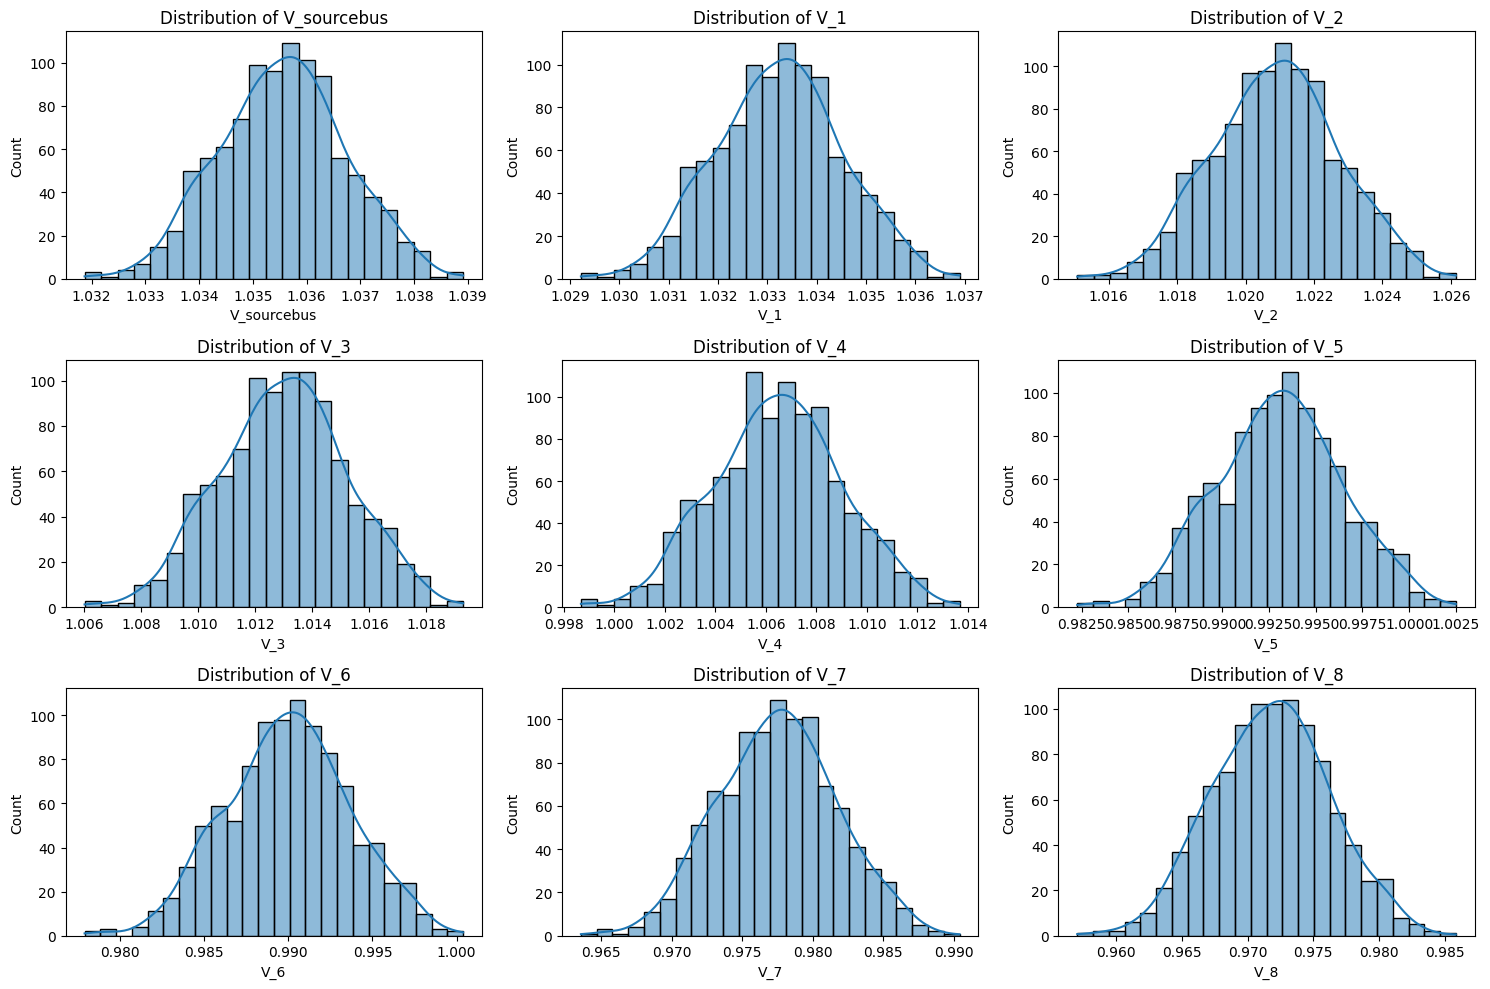

In [23]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(voltage_cols[:9]):  # First 9 voltage columns for clarity
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.savefig('visualizations/voltage_distributions.png')
plt.show()
plt.close()

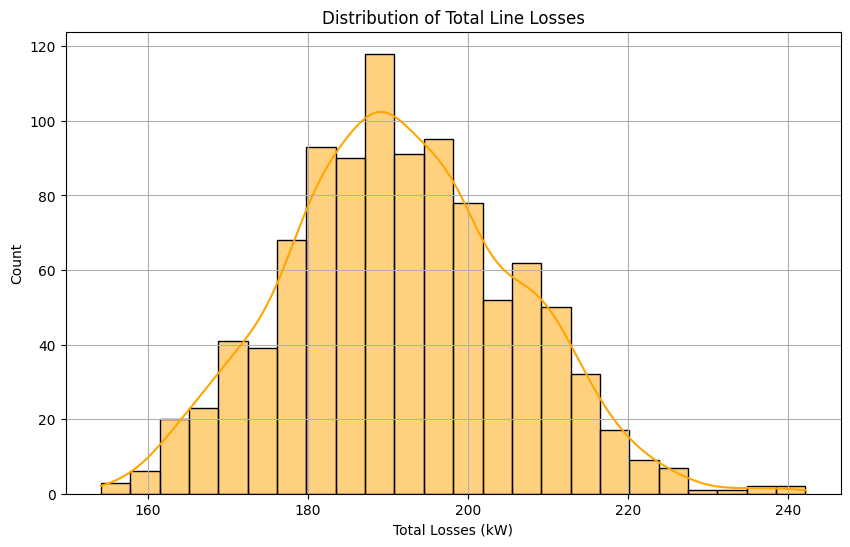

In [24]:
# Distribution of total losses
plt.figure(figsize=(10, 6))
sns.histplot(df[loss_cols[0]], kde=True, color='orange')
plt.title('Distribution of Total Line Losses')
plt.xlabel('Total Losses (kW)')
plt.grid(True)
plt.savefig('visualizations/losses_distribution_detailed.png')
plt.show()
plt.close()

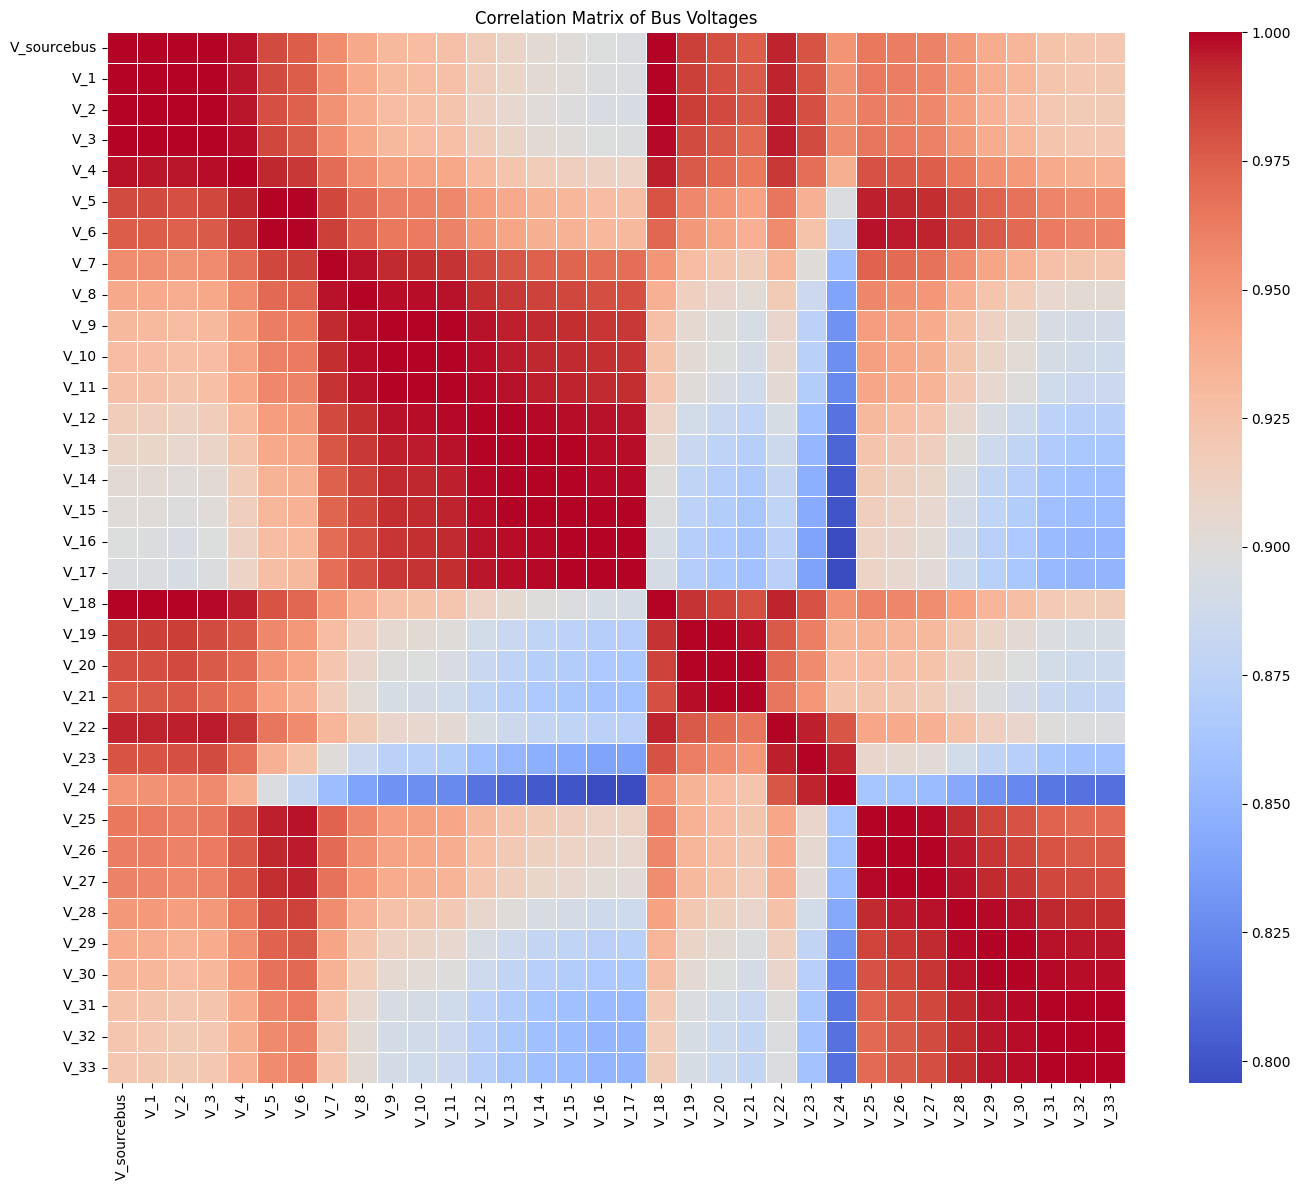

In [25]:
# Correlation matrix between voltages
plt.figure(figsize=(14, 12))
voltage_corr = df[voltage_cols].corr()
sns.heatmap(voltage_corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Bus Voltages')
plt.tight_layout()
plt.savefig('visualizations/voltage_correlation.png')
plt.show()
plt.close()

<Figure size 1500x1000 with 0 Axes>

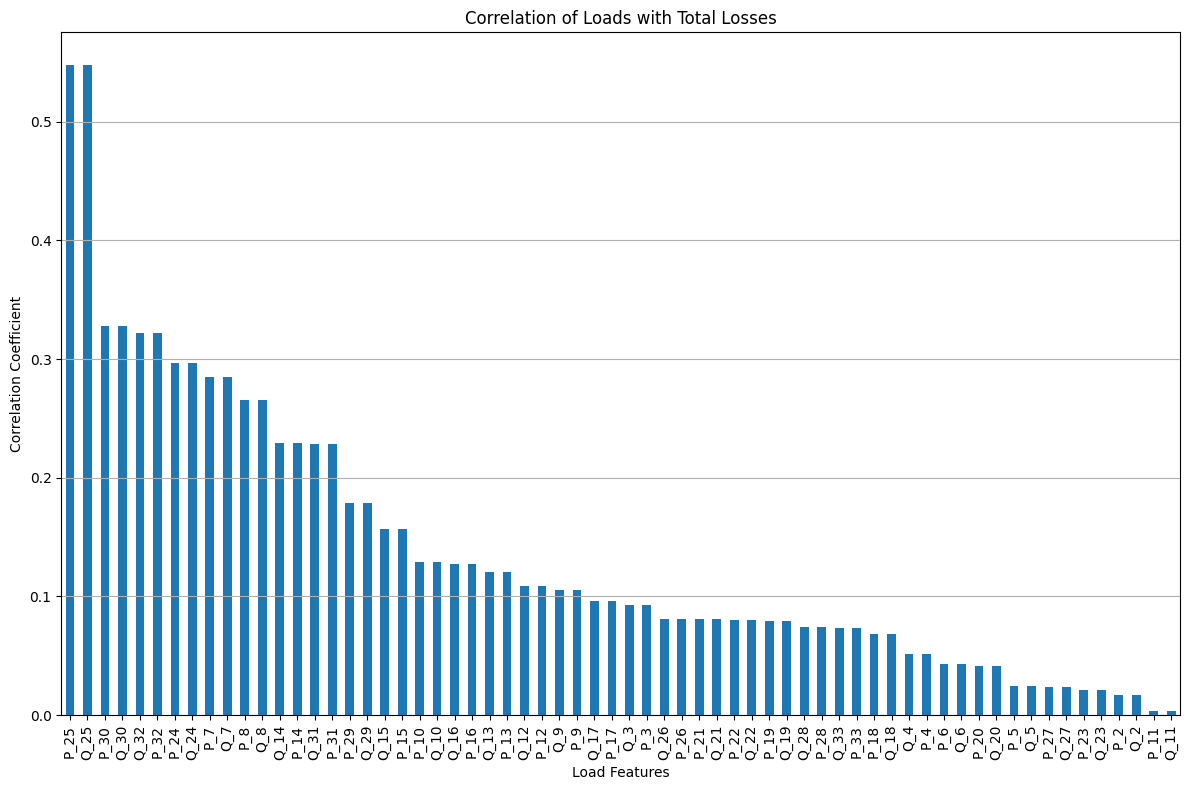

In [26]:
# Correlation between loads and total losses
load_loss_cols = load_p_cols + load_q_cols + loss_cols
plt.figure(figsize=(15, 10))
load_loss_corr = df[load_loss_cols].corr()[loss_cols[0]].drop(loss_cols)
load_loss_corr = load_loss_corr.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
load_loss_corr.plot(kind='bar')
plt.title('Correlation of Loads with Total Losses')
plt.xlabel('Load Features')
plt.ylabel('Correlation Coefficient')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('visualizations/load_loss_correlation.png')
plt.show()
plt.close()

<Figure size 1200x1000 with 0 Axes>

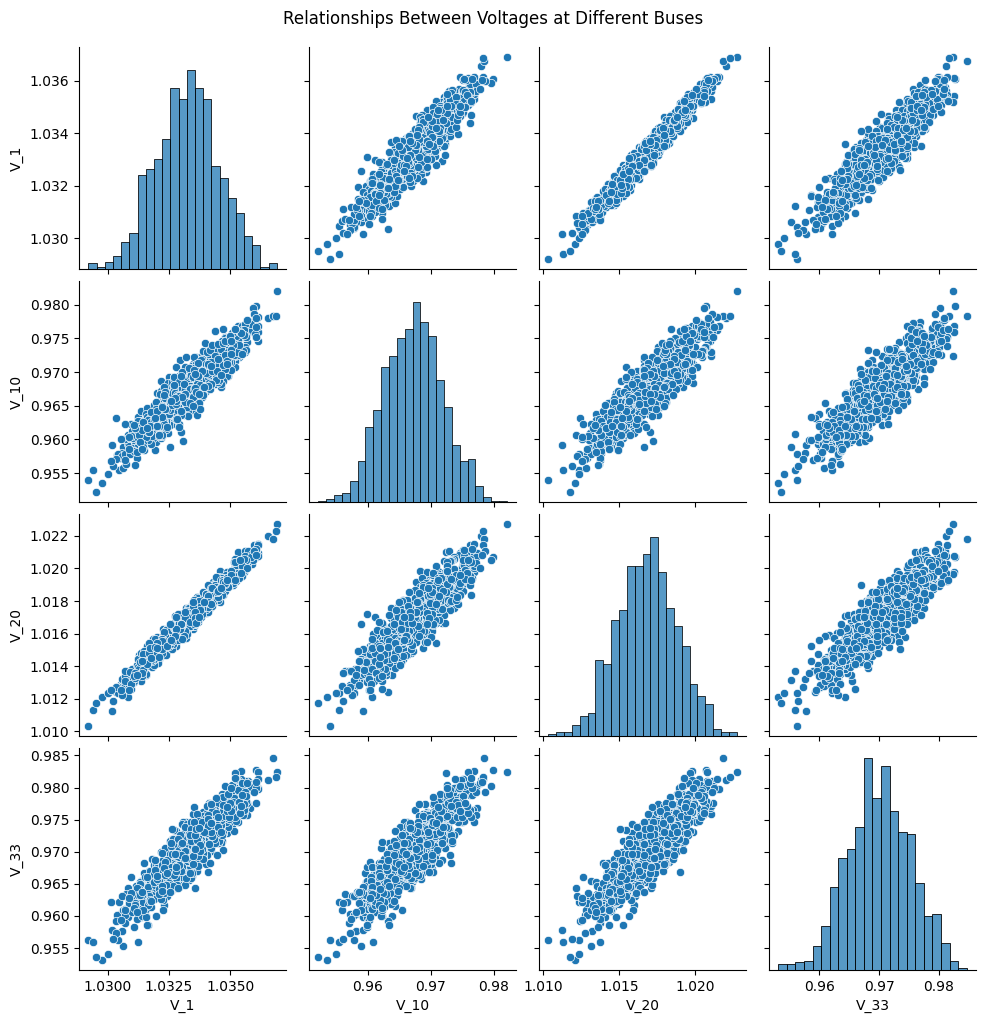

In [27]:
# Scatterplot matrix for selected buses
selected_buses = ['V_1', 'V_10', 'V_20', 'V_33']
plt.figure(figsize=(12, 10))
sns.pairplot(df[selected_buses])
plt.suptitle('Relationships Between Voltages at Different Buses', y=1.02)
plt.savefig('visualizations/voltage_pairplot.png')
plt.show()
plt.close()

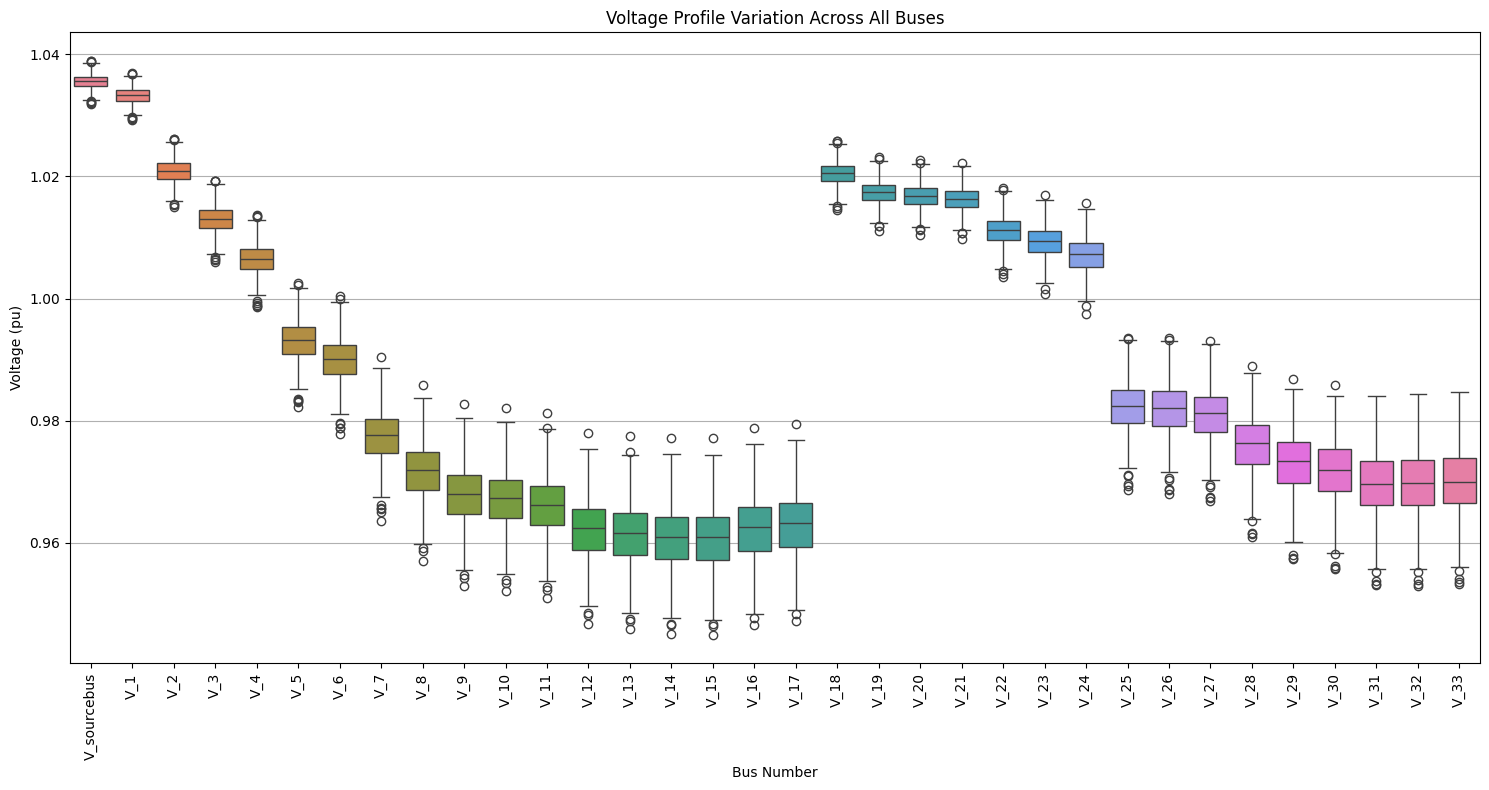

In [28]:
# Box plots for voltage profiles
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[voltage_cols])
plt.title('Voltage Profile Variation Across All Buses')
plt.xlabel('Bus Number')
plt.ylabel('Voltage (pu)')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('visualizations/voltage_boxplot.png')
plt.show()
plt.close()

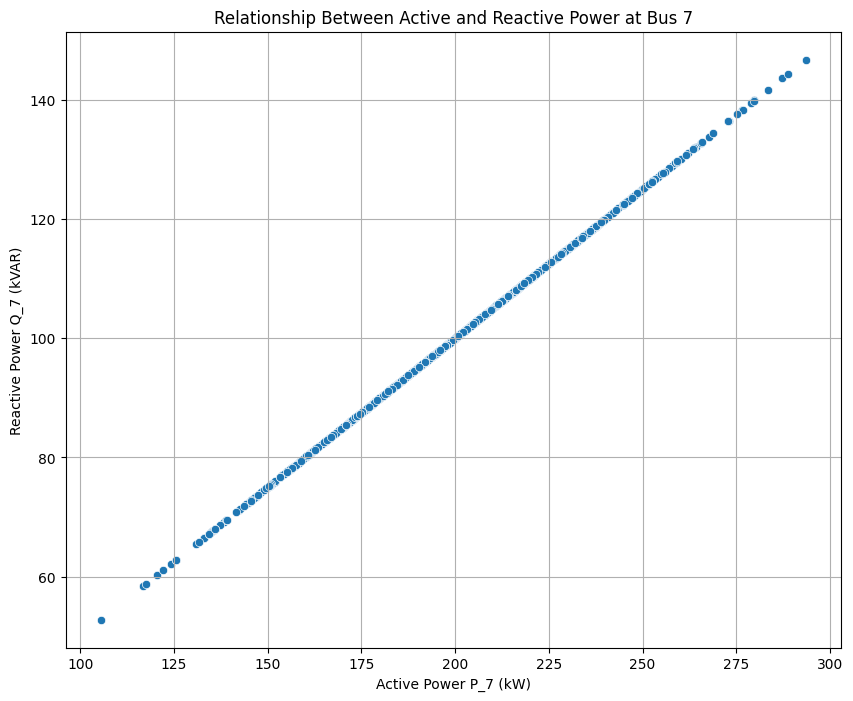

In [29]:
# Relationship between active and reactive power for a specific bus
bus_to_analyze = '7'
plt.figure(figsize=(10, 8))
sns.scatterplot(x=f'P_{bus_to_analyze}', y=f'Q_{bus_to_analyze}', data=df)
plt.title(f'Relationship Between Active and Reactive Power at Bus {bus_to_analyze}')
plt.xlabel(f'Active Power P_{bus_to_analyze} (kW)')
plt.ylabel(f'Reactive Power Q_{bus_to_analyze} (kVAR)')
plt.grid(True)
plt.savefig(f'visualizations/P_Q_relationship_bus_{bus_to_analyze}.png')
plt.show()
plt.close()

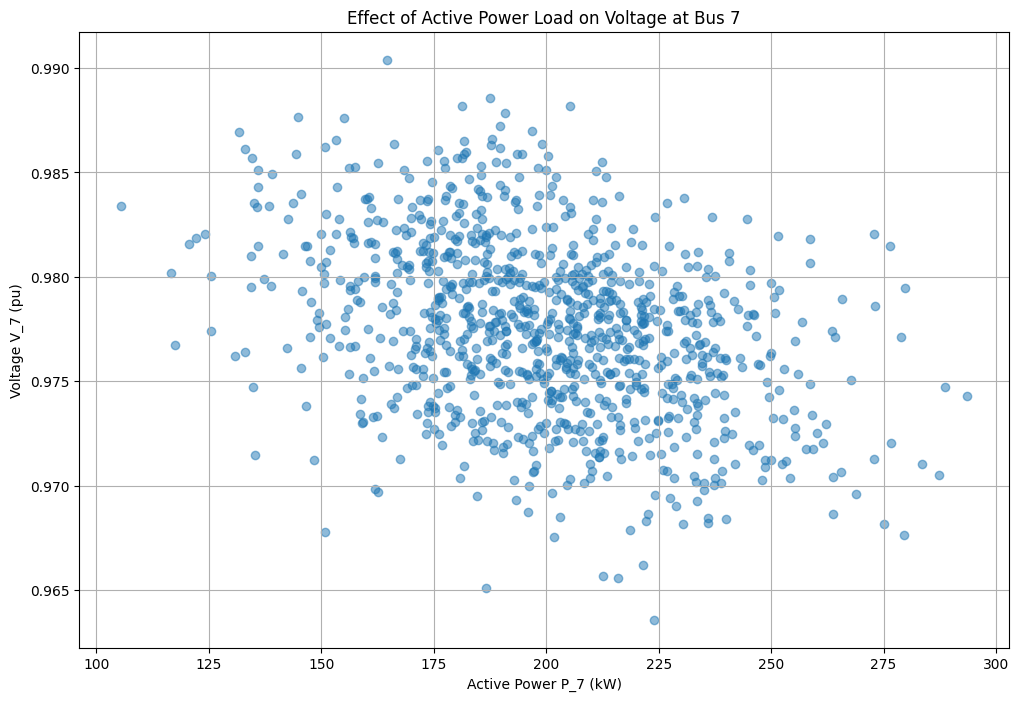

In [30]:
# Effect of load on voltage for a specific bus
plt.figure(figsize=(12, 8))
plt.scatter(df[f'P_{bus_to_analyze}'], df[f'V_{bus_to_analyze}'], alpha=0.5)
plt.title(f'Effect of Active Power Load on Voltage at Bus {bus_to_analyze}')
plt.xlabel(f'Active Power P_{bus_to_analyze} (kW)')
plt.ylabel(f'Voltage V_{bus_to_analyze} (pu)')
plt.grid(True)
plt.savefig(f'visualizations/load_voltage_effect_bus_{bus_to_analyze}.png')
plt.show()
plt.close()

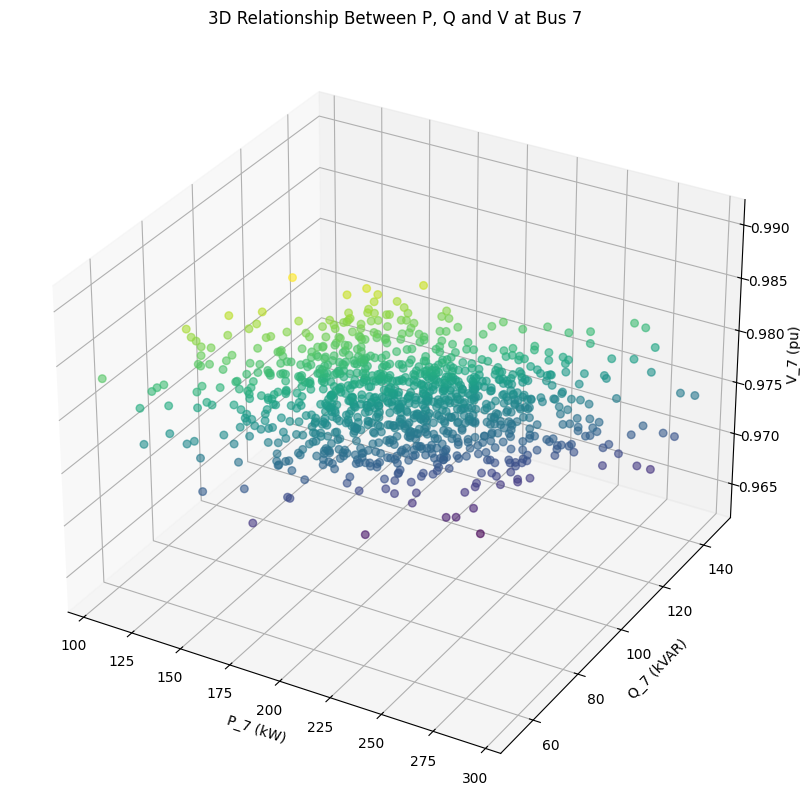

In [31]:
# 3D plot showing relationship between P, Q and V for a specific bus
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[f'P_{bus_to_analyze}'], df[f'Q_{bus_to_analyze}'], 
           df[f'V_{bus_to_analyze}'], c=df[f'V_{bus_to_analyze}'], cmap='viridis', s=30, alpha=0.6)
ax.set_xlabel(f'P_{bus_to_analyze} (kW)')
ax.set_ylabel(f'Q_{bus_to_analyze} (kVAR)')
ax.set_zlabel(f'V_{bus_to_analyze} (pu)')
ax.set_title(f'3D Relationship Between P, Q and V at Bus {bus_to_analyze}')
plt.savefig(f'visualizations/3D_PQV_relationship_bus_{bus_to_analyze}.png')
plt.show()
plt.close()

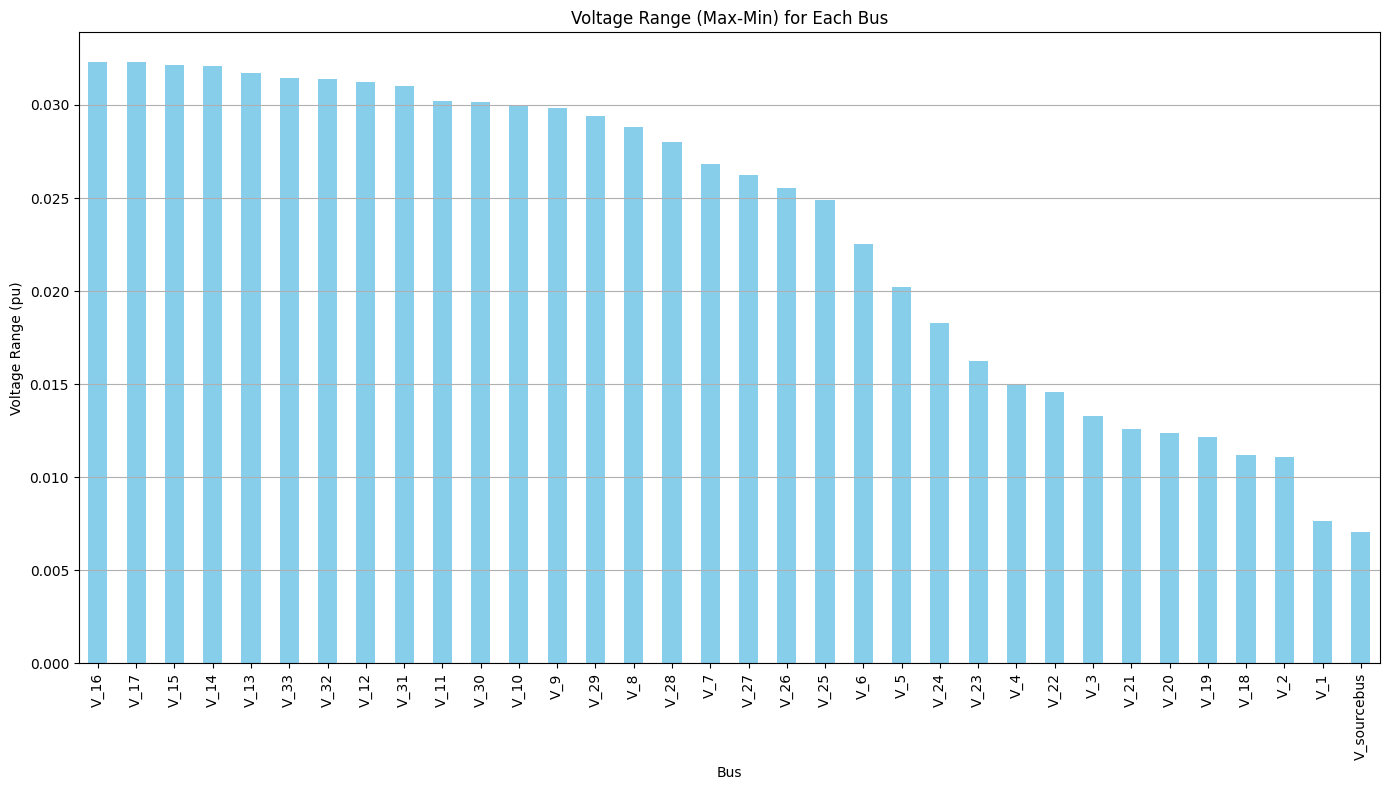

In [32]:
# Summary statistics of voltage profiles
voltage_stats = df[voltage_cols].describe().T
voltage_stats['range'] = voltage_stats['max'] - voltage_stats['min']
voltage_stats['coefficient_of_variation'] = voltage_stats['std'] / voltage_stats['mean'] * 100

# Sort by range to identify buses with highest voltage variations
voltage_stats_sorted = voltage_stats.sort_values(by='range', ascending=False)

plt.figure(figsize=(14, 8))
voltage_stats_sorted['range'].plot(kind='bar', color='skyblue')
plt.title('Voltage Range (Max-Min) for Each Bus')
plt.xlabel('Bus')
plt.ylabel('Voltage Range (pu)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('visualizations/voltage_range_by_bus.png')
plt.show()
plt.close()

In [33]:
# Save the voltage statistics to a CSV file
voltage_stats_sorted.to_csv('visualizations/voltage_statistics.csv')

### Data Preprocessing for ML Models

In [34]:
def prepare_data(df, target_type='voltage', specific_target=None, test_size=0.2):
    """
    Prepare data for machine learning models
    
    Parameters:
    df: pandas DataFrame - The input dataset
    target_type: str - 'voltage', 'loss', or 'all_voltages'
    specific_target: str - Specific column to predict (e.g., 'V_7')
    test_size: float - Proportion of data to use for testing
    
    Returns:
    X_train, X_test, y_train, y_test, scaler_X, scaler_y (if applicable)
    """
    features = load_p_cols + load_q_cols
    
    # Define target based on target_type
    if target_type == 'voltage' and specific_target:
        # Predict a specific bus voltage
        if specific_target not in voltage_cols:
            raise ValueError(f"Specific target {specific_target} not found in voltage columns")
        targets = [specific_target]
    elif target_type == 'loss':
        # Predict total losses
        targets = loss_cols
    elif target_type == 'all_voltages':
        # Predict all bus voltages
        targets = voltage_cols
    else:
        raise ValueError("Invalid target_type. Must be 'voltage', 'loss', or 'all_voltages'")
    
    X = df[features]
    y = df[targets]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Scale features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    if len(targets) == 1:
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)
        return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y
    else:
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)
        return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y

print("\nPreparing datasets for different prediction tasks...")

# 1. Dataset for predicting voltage at a specific bus (e.g., bus 16 which might be more sensitive)
bus_to_predict = 'V_16'
X_train_v16, X_test_v16, y_train_v16, y_test_v16, scaler_X_v16, scaler_y_v16 = prepare_data(
    df, target_type='voltage', specific_target=bus_to_predict
)
print(f"Prepared dataset for predicting {bus_to_predict}")

# 2. Dataset for predicting total losses
X_train_loss, X_test_loss, y_train_loss, y_test_loss, scaler_X_loss, scaler_y_loss = prepare_data(
    df, target_type='loss'
)
print("Prepared dataset for predicting total losses")

# 3. Dataset for predicting all voltages (multi-output regression)
X_train_all_v, X_test_all_v, y_train_all_v, y_test_all_v, scaler_X_all_v, scaler_y_all_v = prepare_data(
    df, target_type='all_voltages'
)
print("Prepared dataset for predicting all bus voltages")


Preparing datasets for different prediction tasks...
Prepared dataset for predicting V_16
Prepared dataset for predicting total losses
Prepared dataset for predicting all bus voltages


In [35]:
print("\nDataset shapes:")
print(f"Single voltage prediction ({bus_to_predict}):")
print(f"  X_train: {X_train_v16.shape}, y_train: {y_train_v16.shape}")
print(f"  X_test: {X_test_v16.shape}, y_test: {y_test_v16.shape}")

print("\nTotal losses prediction:")
print(f"  X_train: {X_train_loss.shape}, y_train: {y_train_loss.shape}")
print(f"  X_test: {X_test_loss.shape}, y_test: {y_test_loss.shape}")

print("\nAll voltages prediction:")
print(f"  X_train: {X_train_all_v.shape}, y_train: {y_train_all_v.shape}")
print(f"  X_test: {X_test_all_v.shape}, y_test: {y_test_all_v.shape}")

# save prepared data for later use
def save_prepared_data(name, X_train, X_test, y_train, y_test):
    np.save(f'prepared_data/X_train_{name}.npy', X_train)
    np.save(f'prepared_data/X_test_{name}.npy', X_test)
    np.save(f'prepared_data/y_train_{name}.npy', y_train)
    np.save(f'prepared_data/y_test_{name}.npy', y_test)

os.makedirs('prepared_data', exist_ok=True)
save_prepared_data('v16', X_train_v16, X_test_v16, y_train_v16, y_test_v16)
save_prepared_data('loss', X_train_loss, X_test_loss, y_train_loss, y_test_loss)
save_prepared_data('all_v', X_train_all_v, X_test_all_v, y_train_all_v, y_test_all_v)

print("\nPrepared datasets saved to 'prepared_data' directory")


Dataset shapes:
Single voltage prediction (V_16):
  X_train: (800, 64), y_train: (800, 1)
  X_test: (200, 64), y_test: (200, 1)

Total losses prediction:
  X_train: (800, 64), y_train: (800, 1)
  X_test: (200, 64), y_test: (200, 1)

All voltages prediction:
  X_train: (800, 64), y_train: (800, 34)
  X_test: (200, 64), y_test: (200, 34)

Prepared datasets saved to 'prepared_data' directory


In [36]:
os.makedirs('models', exist_ok=True)

# Save feature and target column names
feature_cols = {
    'load_p_cols': load_p_cols,
    'load_q_cols': load_q_cols,
    'voltage_cols': voltage_cols,
    'loss_cols': loss_cols
}

with open('models/column_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Save scalers
scalers = {
    'v16': {'X': scaler_X_v16, 'y': scaler_y_v16},
    'loss': {'X': scaler_X_loss, 'y': scaler_y_loss},
    'all_v': {'X': scaler_X_all_v, 'y': scaler_y_all_v}
}

with open('models/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print("Column names and scalers saved to 'models' directory")

Column names and scalers saved to 'models' directory


In [37]:
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Function to load prepared data
def load_prepared_data(name):
    X_train = np.load(f'prepared_data/X_train_{name}.npy')
    X_test = np.load(f'prepared_data/X_test_{name}.npy')
    y_train = np.load(f'prepared_data/y_train_{name}.npy')
    y_test = np.load(f'prepared_data/y_test_{name}.npy')
    return X_train, X_test, y_train, y_test

# Function to load scalers
def load_scalers():
    with open('models/scalers.pkl', 'rb') as f:
        scalers = pickle.load(f)
    return scalers

# Function to load column names
def load_column_names():
    with open('models/column_names.pkl', 'rb') as f:
        column_names = pickle.load(f)
    return column_names

In [38]:
# Load all data sets
X_train_v16, X_test_v16, y_train_v16, y_test_v16 = load_prepared_data('v16')
X_train_loss, X_test_loss, y_train_loss, y_test_loss = load_prepared_data('loss')
X_train_all_v, X_test_all_v, y_train_all_v, y_test_all_v = load_prepared_data('all_v')

# Load scalers and column names
scalers = load_scalers()
column_names = load_column_names()

# Create feature names for plotting
load_feature_names = column_names['load_p_cols'] + column_names['load_q_cols']
voltage_feature_names = column_names['voltage_cols']

In [39]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Custom metrics for power system applications
    # Normalized RMSE (NRMSE)
    y_range = np.max(y_true) - np.min(y_true)
    nrmse = rmse / y_range if y_range != 0 else rmse
    
    # Mean Absolute Percentage Error (MAPE)
    non_zero_mask = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(y_true - y_pred))
    
    # Additional power system specific metric: Voltage Deviation Index (for voltage predictions)
    # Assumeing values close to 1.0 pu are optimal
    if "V_" in column_names['voltage_cols'][0]:  # Only for voltage predictions
        nominal_voltage = 1.0  # Assuming 1.0 pu as nominal
        vdi = np.mean(np.abs(y_pred - nominal_voltage))
    else:
        vdi = None
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'NRMSE': nrmse,
        'MAPE': mape if not np.isnan(mape) else None,
        'Max Error': max_error,
        'VDI': vdi
    }

In [40]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_true, y_pred, title, filename):
    plt.figure(figsize=(10, 6))
    
    # If multi-output, plot for first few outputs
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        for i in range(min(5, y_true.shape[1])):
            plt.subplot(2, 3, i+1)
            plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
            plt.plot([y_true[:, i].min(), y_true[:, i].max()], 
                     [y_true[:, i].min(), y_true[:, i].max()], 
                     'r--', lw=2)
            plt.title(f'Output {i+1}')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.grid(True)
        
        plt.tight_layout()
    else:
        # Single output
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], 
                 [y_true.min(), y_true.max()], 
                 'r--', lw=2)
        plt.title(title)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True)
    
    plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
    plt.close()

In [41]:
print(f"V_16 dataset shapes: X_train: {X_train_v16.shape}, y_train: {y_train_v16.shape}")
print(f"Loss dataset shapes: X_train: {X_train_loss.shape}, y_train: {y_train_loss.shape}")
print(f"All voltages dataset shapes: X_train: {X_train_all_v.shape}, y_train: {y_train_all_v.shape}")

V_16 dataset shapes: X_train: (800, 64), y_train: (800, 1)
Loss dataset shapes: X_train: (800, 64), y_train: (800, 1)
All voltages dataset shapes: X_train: (800, 64), y_train: (800, 34)


### Random Forest Model

In [43]:
def train_rf_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    # Training convergence tracking
    train_errors = []
    val_errors = []
    
    # 1. Base model for quick evaluation
    print(f"\nTraining base Random Forest model for {target_name}...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train)
    
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        y_train_pred = y_train_pred.reshape(-1, 1)
        y_test_pred = y_test_pred.reshape(-1, 1)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base RF Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base RF Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': rf_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred
    }
    
    # 2. Sensitivity Analysis
    print(f"\nPerforming sensitivity analysis on number of trees...")
    n_estimators_list = [10, 50, 100, 200]
    trees_results = []
    
    for n_trees in n_estimators_list:
        print(f"Training with {n_trees} trees...")
        start_time = time.time()
        
        rf = RandomForestRegressor(n_estimators=n_trees, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train)
        
        train_pred = rf.predict(X_train)
        test_pred = rf.predict(X_test)
        
        if len(y_train.shape) == 2 and y_train.shape[1] == 1:
            train_pred = train_pred.reshape(-1, 1)
            test_pred = test_pred.reshape(-1, 1)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        
        trees_results.append({
            'n_trees': n_trees,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time
        })
        
        train_errors.append(train_rmse)
        val_errors.append(test_rmse)
    
    # Plot sensitivity analysis results
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs number of trees
    plt.subplot(2, 2, 1)
    plt.plot([r['n_trees'] for r in trees_results], [r['train_rmse'] for r in trees_results], 'b-o', label='Training RMSE')
    plt.plot([r['n_trees'] for r in trees_results], [r['test_rmse'] for r in trees_results], 'r-o', label='Testing RMSE')
    plt.xlabel('Number of Trees')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of Trees')
    plt.legend()
    plt.grid(True)
    
    # Plot R² vs number of trees
    plt.subplot(2, 2, 2)
    plt.plot([r['n_trees'] for r in trees_results], [r['train_r2'] for r in trees_results], 'b-o', label='Training R²')
    plt.plot([r['n_trees'] for r in trees_results], [r['test_r2'] for r in trees_results], 'r-o', label='Testing R²')
    plt.xlabel('Number of Trees')
    plt.ylabel('R²')
    plt.title('R² vs Number of Trees')
    plt.legend()
    plt.grid(True)
    
    # Plot training time vs number of trees
    plt.subplot(2, 2, 3)
    plt.plot([r['n_trees'] for r in trees_results], [r['training_time'] for r in trees_results], 'g-o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Number of Trees')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/rf/{target_name}_trees_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['trees_sensitivity'] = trees_results
    
    # 3. Hyperparameter tuning
    print(f"\nPerforming hyperparameter tuning for {target_name}...")
    
    # parameter grid
    param_grid = {
        'n_estimators': [100],
        'max_depth': [None, 20],
        'min_samples_split': [2, 5]
    }
    
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        param_grid = {
            'n_estimators': [100],
            'max_depth': [None, 20]
        }
    
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    rf_grid.fit(X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train)
    
    # Get best model
    best_rf = rf_grid.best_estimator_
    best_params = rf_grid.best_params_
    
    print(f"Best parameters: {best_params}")
    
    # Generate predictions with best model
    best_train_pred = best_rf.predict(X_train)
    best_test_pred = best_rf.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        best_train_pred = best_train_pred.reshape(-1, 1)
        best_test_pred = best_test_pred.reshape(-1, 1)
    
    # Calculate metrics for best model
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best RF Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best RF Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    results['best_model'] = {
        'model': best_rf,
        'params': best_params,
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred
    }
    
    # 4. Feature importance analysis
    if len(y_train.shape) == 1 or y_train.shape[1] == 1:
        print("\nAnalyzing feature importance...")
        
        importances = best_rf.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        indices = np.argsort(importances)[::-1]
        plt.title(f'Random Forest Feature Importance - {target_name}')
        plt.bar(range(min(20, len(feature_names))), importances[indices][:min(20, len(feature_names))], align='center')
        plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices][:min(20, len(feature_names))], rotation=90)
        plt.tight_layout()
        plt.savefig(f'figures/rf/{target_name}_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store top 10 important features
        top_features = [(feature_names[idx], importances[idx]) for idx in indices[:10]]
        results['feature_importance'] = {
            'importances': importances,
            'top_features': top_features
        }
    
    # 5. Plot actual vs predicted values for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Random Forest: Actual vs Predicted - {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/rf/{target_name}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Learning curve
    print("\nGenerating learning curves...")
    
    train_sizes, train_scores, test_scores = learning_curve(
        best_rf, X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train,
        cv=3,
        n_jobs=-1, 
        train_sizes=np.linspace(0.2, 1.0, 5),
        scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Random Forest Learning Curve - {target_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'figures/rf/{target_name}_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Store the learning curve data
    results['learning_curve'] = {
        'train_sizes': train_sizes,
        'train_scores_mean': train_scores_mean,
        'train_scores_std': train_scores_std,
        'test_scores_mean': test_scores_mean,
        'test_scores_std': test_scores_std
    }
    
    # Save all results and metrics to CSV
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error'],
        'Base Train': [results['base_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Base Test': [results['base_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Train': [results['best_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Test': [results['best_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']]
    })
    
    results_df.to_csv(f'results/rf_{target_name}_metrics.csv', index=False)
    
    return results


1. Training Random Forest for single voltage prediction (V_16)...

Training base Random Forest model for V_16...
Base RF Model - Training R²: 0.9447, RMSE: 0.2351
Base RF Model - Testing R²: 0.6413, RMSE: 0.6056

Performing sensitivity analysis on number of trees...
Training with 10 trees...
Training with 50 trees...
Training with 100 trees...
Training with 200 trees...


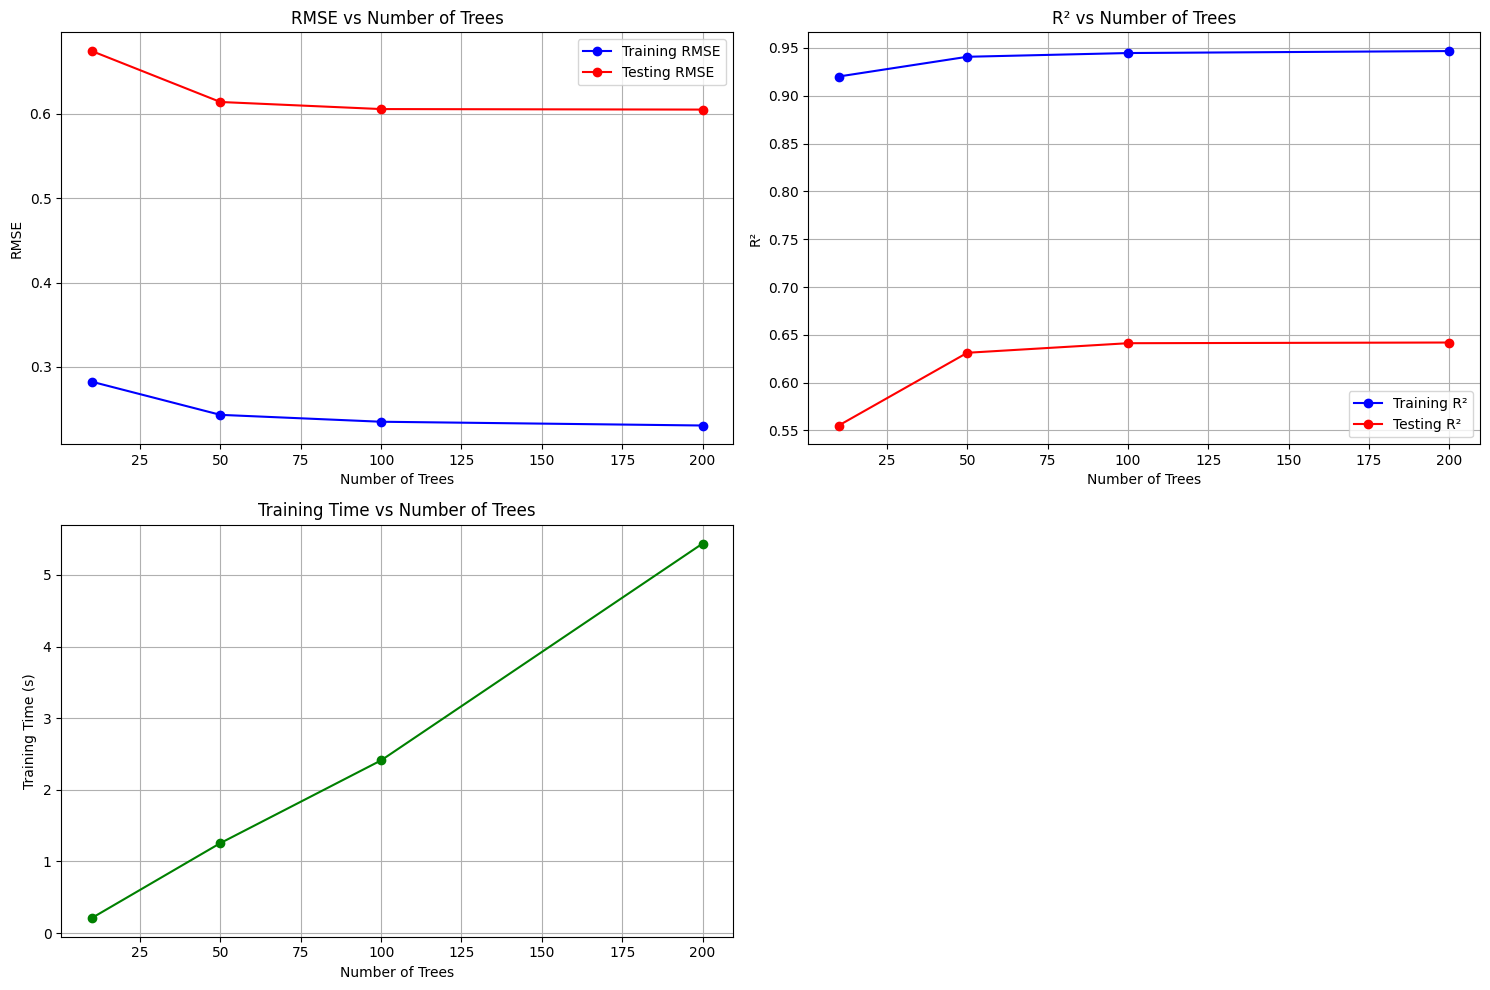


Performing hyperparameter tuning for V_16...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best RF Model - Training R²: 0.9447, RMSE: 0.2352
Best RF Model - Testing R²: 0.6412, RMSE: 0.6056

Analyzing feature importance...


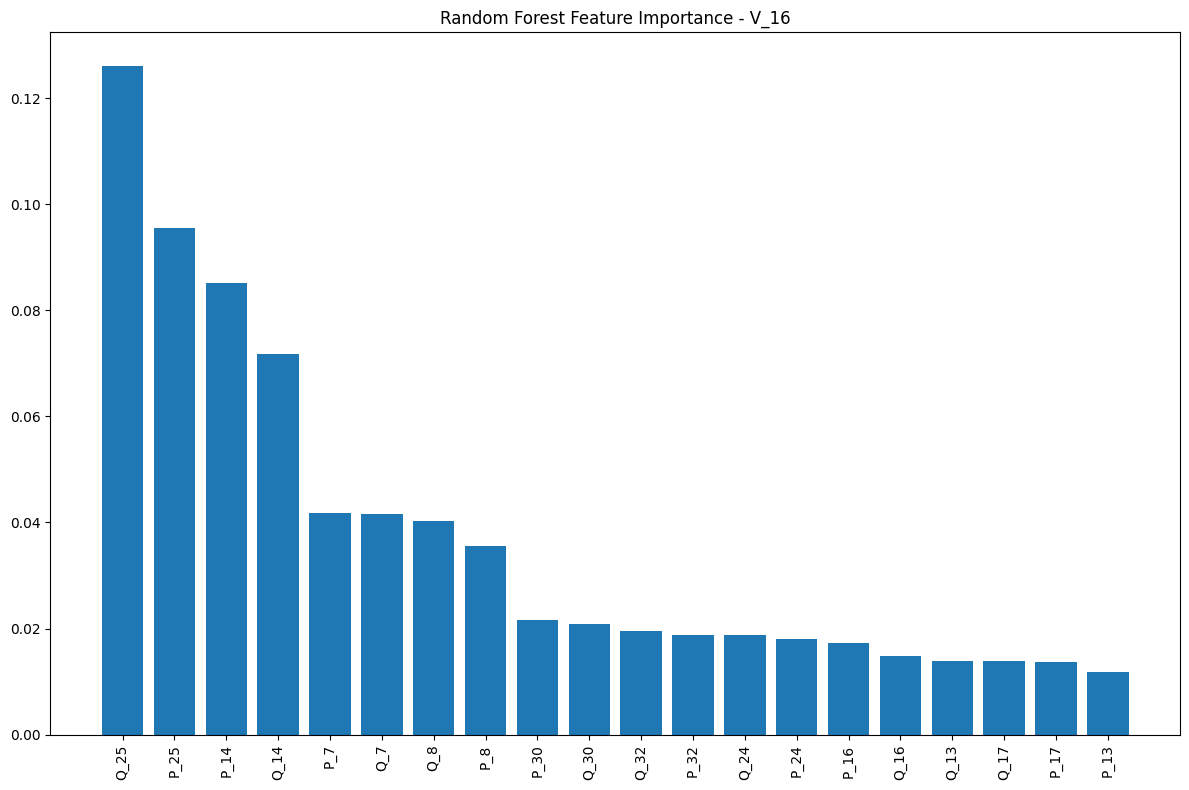

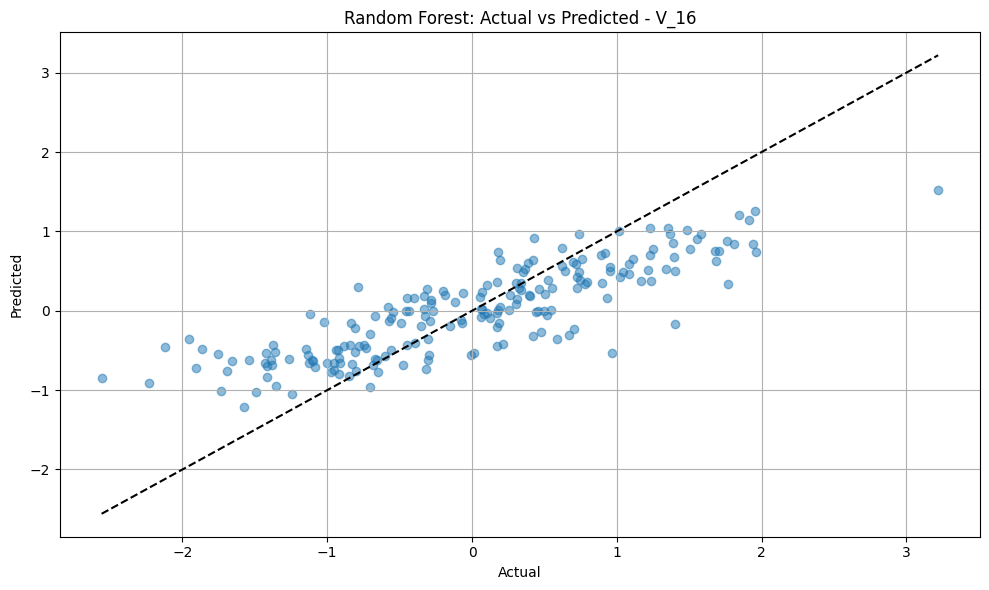


Generating learning curves...


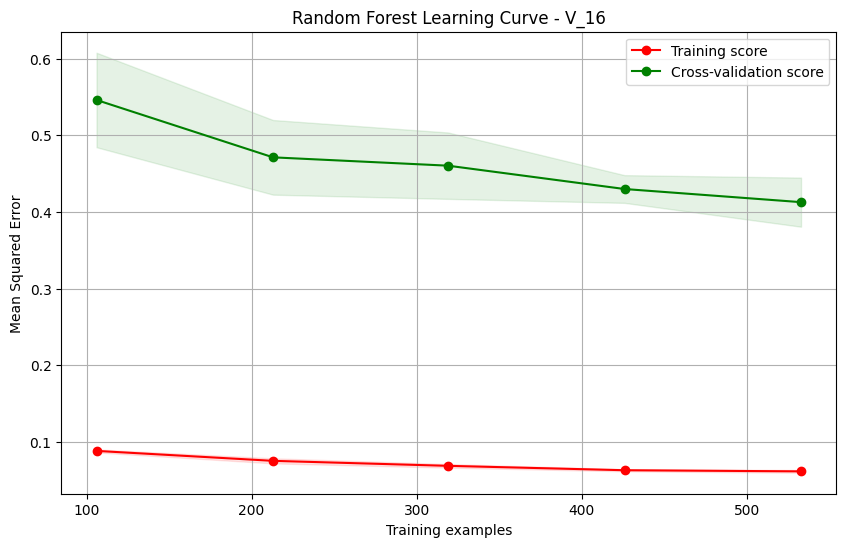

In [44]:
print("\n1. Training Random Forest for single voltage prediction (V_16)...")
rf_v16_results = train_rf_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


2. Training Random Forest for loss prediction...

Training base Random Forest model for loss...
Base RF Model - Training R²: 0.9491, RMSE: 0.2256
Base RF Model - Testing R²: 0.6814, RMSE: 0.5610

Performing sensitivity analysis on number of trees...
Training with 10 trees...
Training with 50 trees...
Training with 100 trees...
Training with 200 trees...


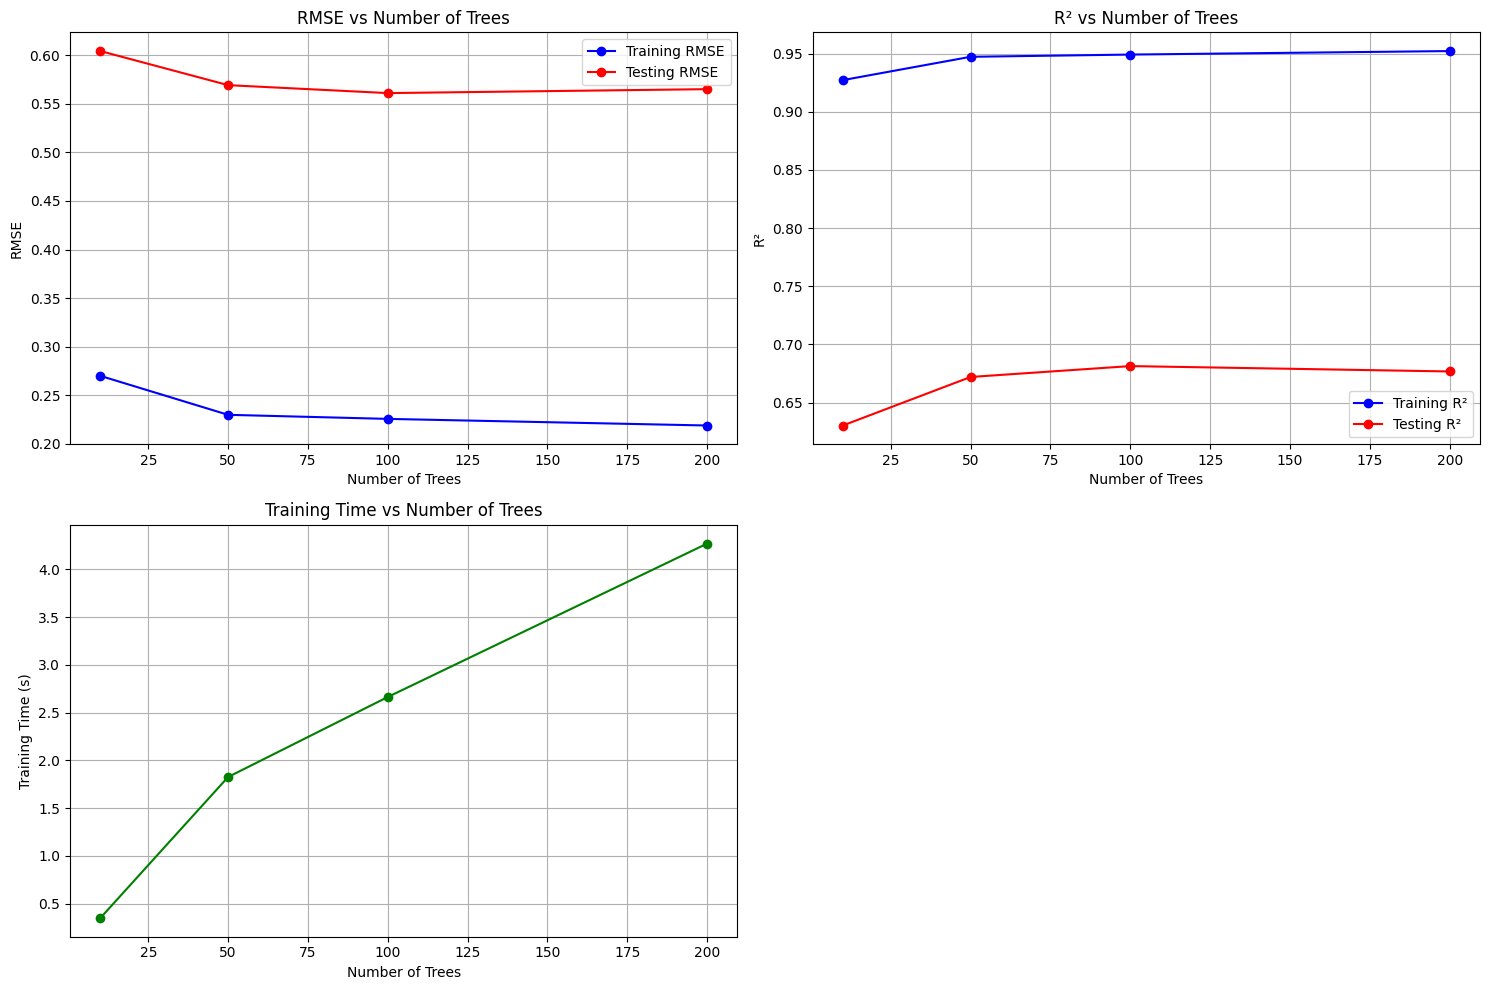


Performing hyperparameter tuning for loss...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best RF Model - Training R²: 0.9394, RMSE: 0.2462
Best RF Model - Testing R²: 0.6784, RMSE: 0.5637

Analyzing feature importance...


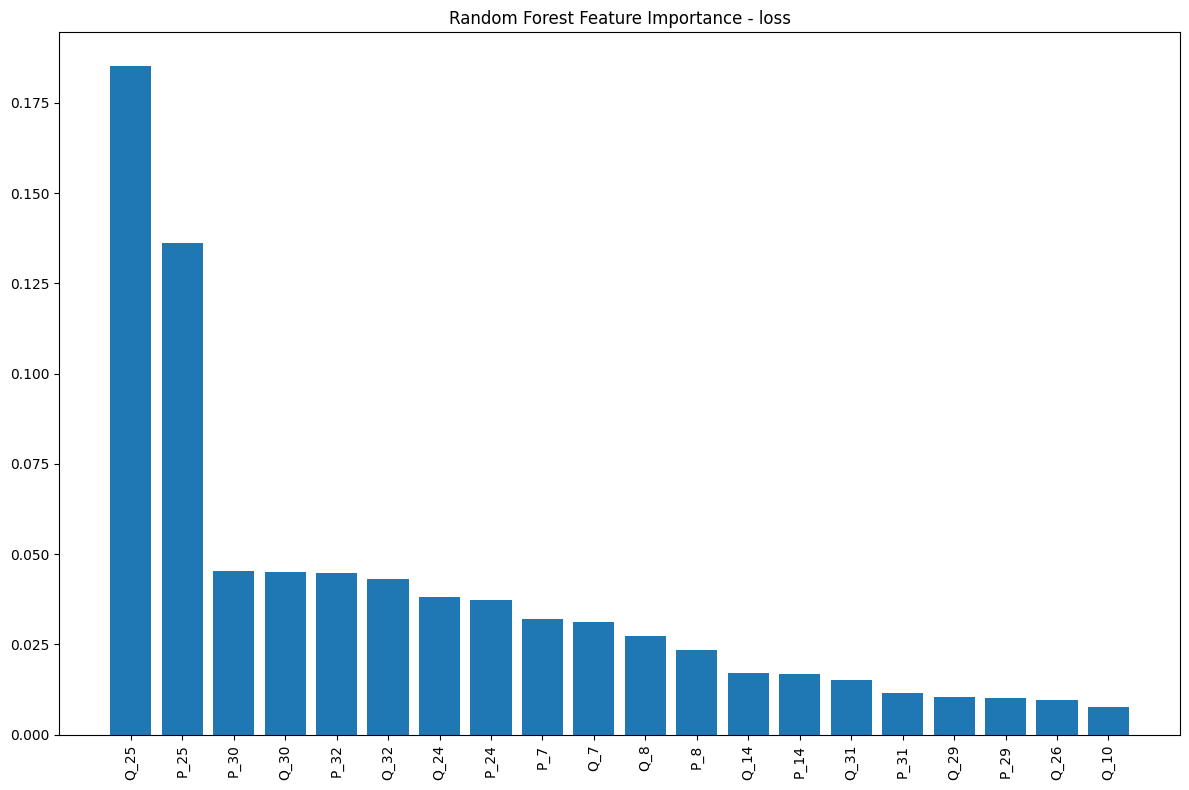

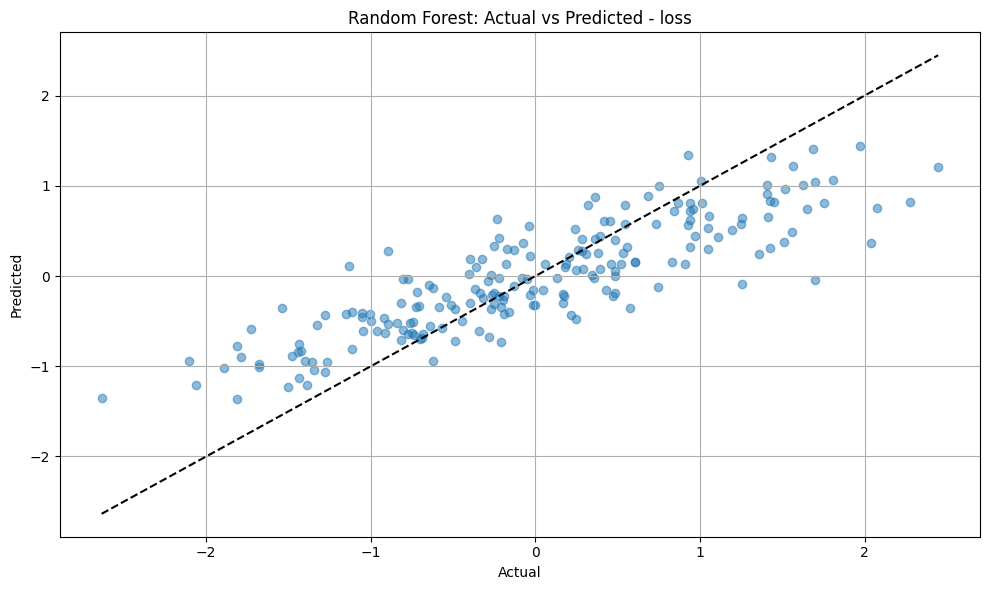


Generating learning curves...


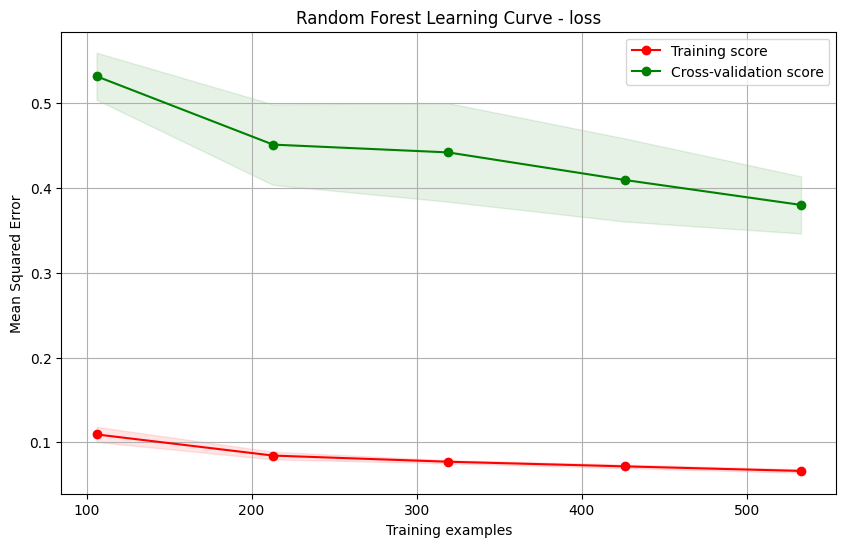

In [45]:
print("\n2. Training Random Forest for loss prediction...")
rf_loss_results = train_rf_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


3. Training Random Forest for all voltages prediction...

Training base Random Forest model for all_voltages...
Base RF Model - Training R²: 0.9452, RMSE: 0.2341
Base RF Model - Testing R²: 0.6569, RMSE: 0.5864

Performing sensitivity analysis on number of trees...
Training with 10 trees...
Training with 50 trees...
Training with 100 trees...
Training with 200 trees...


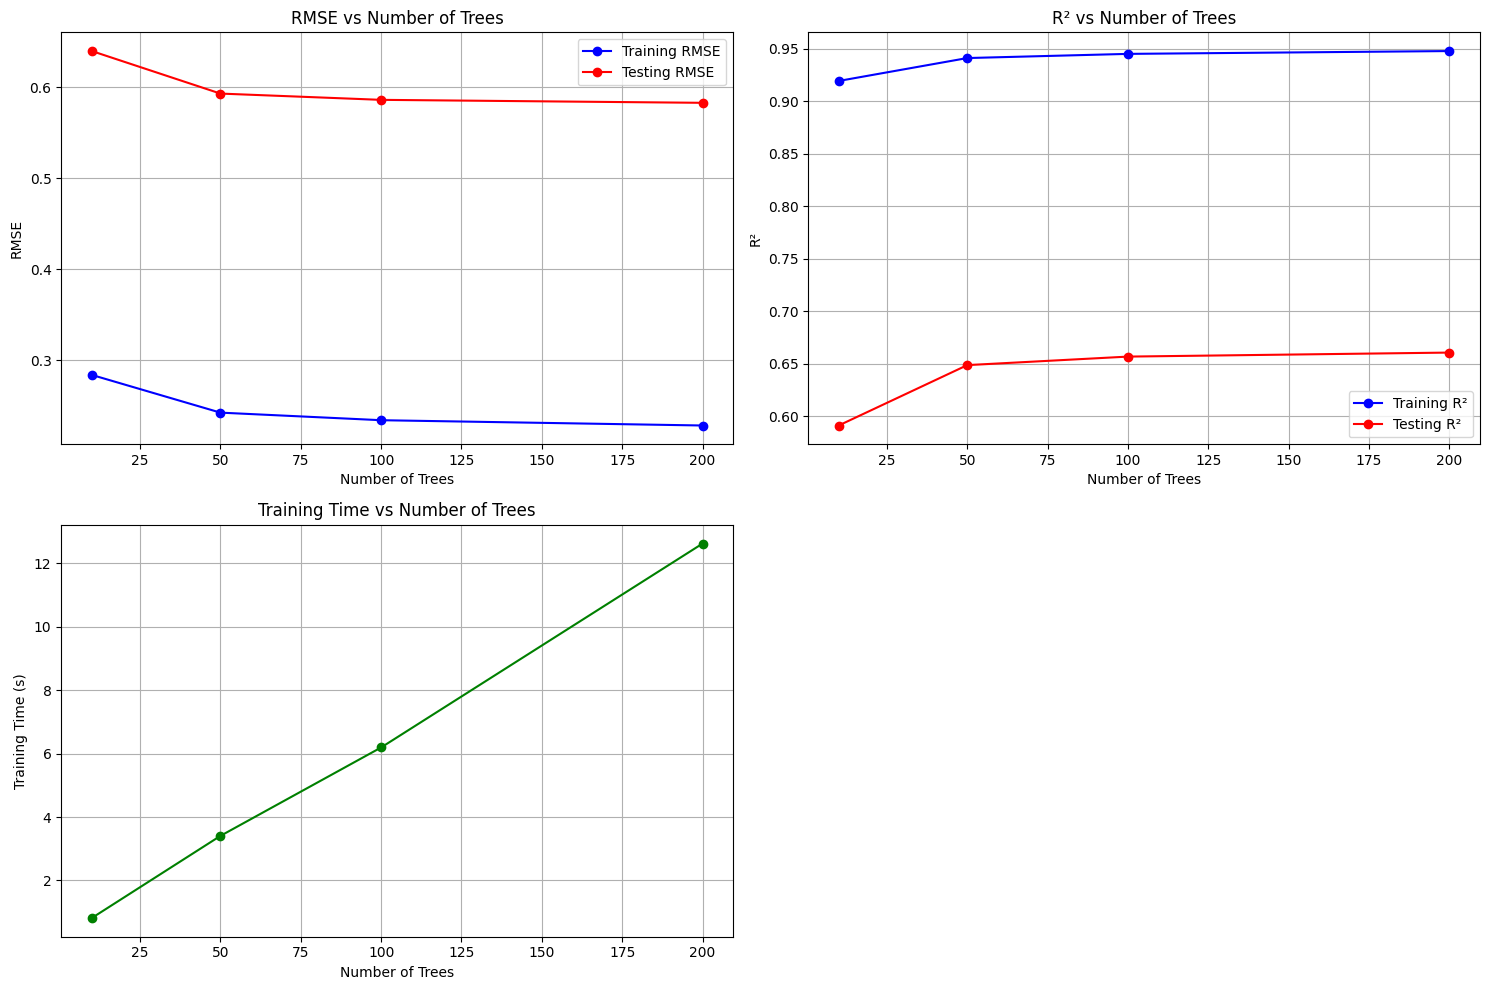


Performing hyperparameter tuning for all_voltages...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'max_depth': None, 'n_estimators': 100}
Best RF Model - Training R²: 0.9452, RMSE: 0.2341
Best RF Model - Testing R²: 0.6569, RMSE: 0.5864


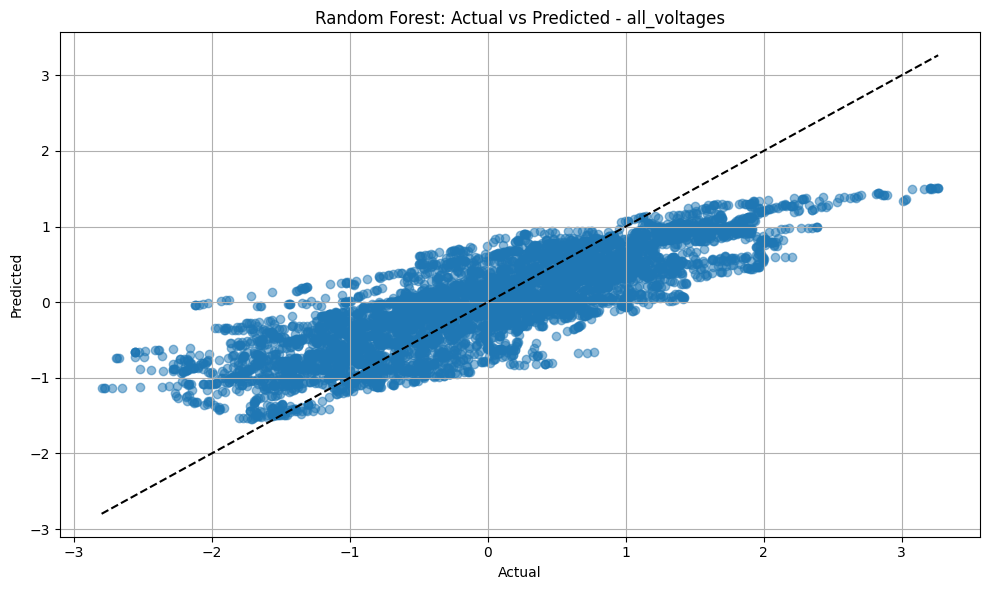


Generating learning curves...


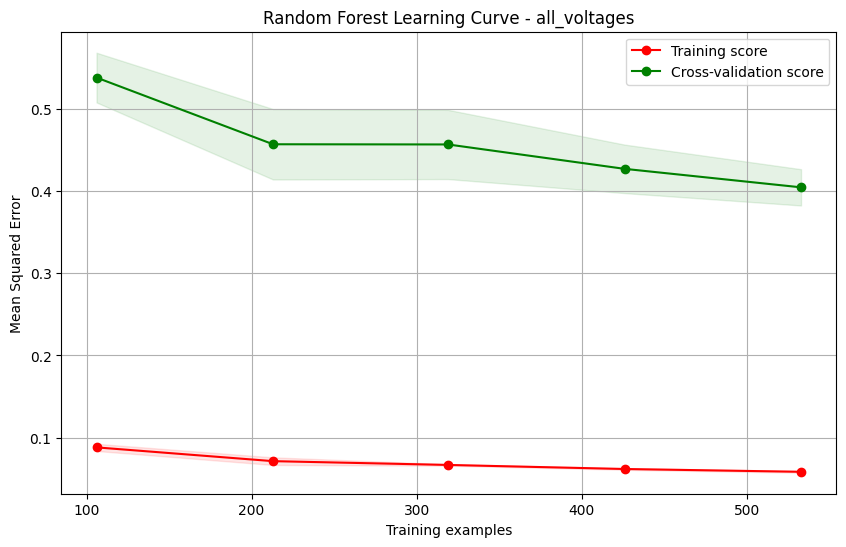

In [46]:
print("\n3. Training Random Forest for all voltages prediction...")
rf_all_v_results = train_rf_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [47]:
# Save the trained models
print("\nSaving trained Random Forest models...")
os.makedirs('models/random_forest', exist_ok=True)

with open('models/random_forest/rf_v16_best_model.pkl', 'wb') as f:
    pickle.dump(rf_v16_results['best_model']['model'], f)

with open('models/random_forest/rf_loss_best_model.pkl', 'wb') as f:
    pickle.dump(rf_loss_results['best_model']['model'], f)

with open('models/random_forest/rf_all_v_best_model.pkl', 'wb') as f:
    pickle.dump(rf_all_v_results['best_model']['model'], f)

print("Random Forest models saved successfully!")


Saving trained Random Forest models...
Random Forest models saved successfully!


In [48]:
print("\n=== Random Forest Models Summary ===")
print(f"V_16 Prediction - Test R²: {rf_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {rf_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {rf_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {rf_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {rf_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {rf_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")



=== Random Forest Models Summary ===
V_16 Prediction - Test R²: 0.6412, RMSE: 0.6056
Loss Prediction - Test R²: 0.6784, RMSE: 0.5637
All Voltages Prediction - Test R²: 0.6569, RMSE: 0.5864


### K-Nearest Neighbours (KNN)

In [51]:
def train_knn_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    # Training convergence tracking
    train_errors = []
    val_errors = []
    
    # 1. Base model for quick evaluation
    print(f"\nTraining base KNN model for {target_name}...")
    knn_model = KNeighborsRegressor(n_neighbors=5)
    
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        knn_model.fit(X_train, y_train)
    else:
        knn_model.fit(X_train, y_train.ravel())
    
    y_train_pred = knn_model.predict(X_train)
    y_test_pred = knn_model.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        y_train_pred = y_train_pred.reshape(-1, 1)
        y_test_pred = y_test_pred.reshape(-1, 1)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base KNN Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base KNN Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': knn_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred
    }
    
    # 2. Sensitivity Analysis: Vary number of neighbors
    print(f"\nPerforming sensitivity analysis on number of neighbors...")
    n_neighbors_list = [1, 3, 5, 7, 10, 15, 20, 30, 50]
    neighbors_results = []
    
    for n_neighbors in n_neighbors_list:
        print(f"Training with {n_neighbors} neighbors...")
        start_time = time.time()
        
        knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        
        if len(y_train.shape) > 1 and y_train.shape[1] > 1:
            knn.fit(X_train, y_train)
        else:
            knn.fit(X_train, y_train.ravel())
        
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        
        if len(y_train.shape) == 2 and y_train.shape[1] == 1:
            train_pred = train_pred.reshape(-1, 1)
            test_pred = test_pred.reshape(-1, 1)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        
        neighbors_results.append({
            'n_neighbors': n_neighbors,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time
        })
        
        train_errors.append(train_rmse)
        val_errors.append(test_rmse)
    
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs number of neighbors
    plt.subplot(2, 2, 1)
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['train_rmse'] for r in neighbors_results], 'b-o', label='Training RMSE')
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['test_rmse'] for r in neighbors_results], 'r-o', label='Testing RMSE')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of Neighbors')
    plt.legend()
    plt.grid(True)
    
    # Plot R² vs number of neighbors
    plt.subplot(2, 2, 2)
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['train_r2'] for r in neighbors_results], 'b-o', label='Training R²')
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['test_r2'] for r in neighbors_results], 'r-o', label='Testing R²')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('R²')
    plt.title('R² vs Number of Neighbors')
    plt.legend()
    plt.grid(True)
    
    # Plot training time vs number of neighbors
    plt.subplot(2, 2, 3)
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['training_time'] for r in neighbors_results], 'g-o')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Number of Neighbors')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/knn/{target_name}_neighbors_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    results['neighbors_sensitivity'] = neighbors_results
    
    # 3. Hyperparameter tuning with GridSearchCV
    print(f"\nPerforming hyperparameter tuning for {target_name}...")
    
    # Find optimal n_neighbors from sensitivity analysis
    optimal_n_neighbors = min(neighbors_results, key=lambda x: x['test_rmse'])['n_neighbors']
    print(f"Optimal number of neighbors from sensitivity analysis: {optimal_n_neighbors}")
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [optimal_n_neighbors-2, optimal_n_neighbors, optimal_n_neighbors+2],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'p': [1, 2]  # 1 for manhattan_distance, 2 for euclidean_distance
    }
    
    # If the target is multi-dimensional, use a simpler grid to save time
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        param_grid = {
            'n_neighbors': [optimal_n_neighbors],
            'weights': ['uniform', 'distance'],
            'p': [2]
        }
    
    # grid search object
    knn_grid = GridSearchCV(
        KNeighborsRegressor(),
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        knn_grid.fit(X_train, y_train)
    else:
        knn_grid.fit(X_train, y_train.ravel())
    
    # Get best model
    best_knn = knn_grid.best_estimator_
    best_params = knn_grid.best_params_
    
    print(f"Best parameters: {best_params}")
    
    # Generate predictions with best model
    best_train_pred = best_knn.predict(X_train)
    best_test_pred = best_knn.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        best_train_pred = best_train_pred.reshape(-1, 1)
        best_test_pred = best_test_pred.reshape(-1, 1)
    
    # Calculate metrics for best model
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best KNN Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best KNN Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    # Store best model results
    results['best_model'] = {
        'model': best_knn,
        'params': best_params,
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred
    }
    
    # 5. Plot actual vs predicted values for testing data
    plot_actual_vs_predicted(y_test, best_test_pred, 
                           f'KNN: Actual vs Predicted - {target_name}',
                           f'knn/{target_name}_actual_vs_predicted')
    
    # 6. Learning curve to analyze model bias-variance tradeoff
    print("\nGenerating learning curves...")
    
    train_sizes, train_scores, test_scores = learning_curve(
        best_knn, X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train,
        cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.title(f"KNN Learning Curve - {target_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'figures/knn/{target_name}_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Store the learning curve data
    results['learning_curve'] = {
        'train_sizes': train_sizes,
        'train_scores_mean': train_scores_mean,
        'train_scores_std': train_scores_std,
        'test_scores_mean': test_scores_mean,
        'test_scores_std': test_scores_std
    }
    
    # Save all results and metrics to CSV
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error'],
        'Base Train': [results['base_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Base Test': [results['base_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Train': [results['best_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Test': [results['best_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']]
    })
    
    results_df.to_csv(f'results/knn_{target_name}_metrics.csv', index=False)
    
    return results


1. Training KNN for single voltage prediction (V_16)...

Training base KNN model for V_16...
Base KNN Model - Training R²: 0.6912, RMSE: 0.5557
Base KNN Model - Testing R²: 0.5384, RMSE: 0.6869

Performing sensitivity analysis on number of neighbors...
Training with 1 neighbors...
Training with 3 neighbors...
Training with 5 neighbors...
Training with 7 neighbors...
Training with 10 neighbors...
Training with 15 neighbors...
Training with 20 neighbors...
Training with 30 neighbors...
Training with 50 neighbors...


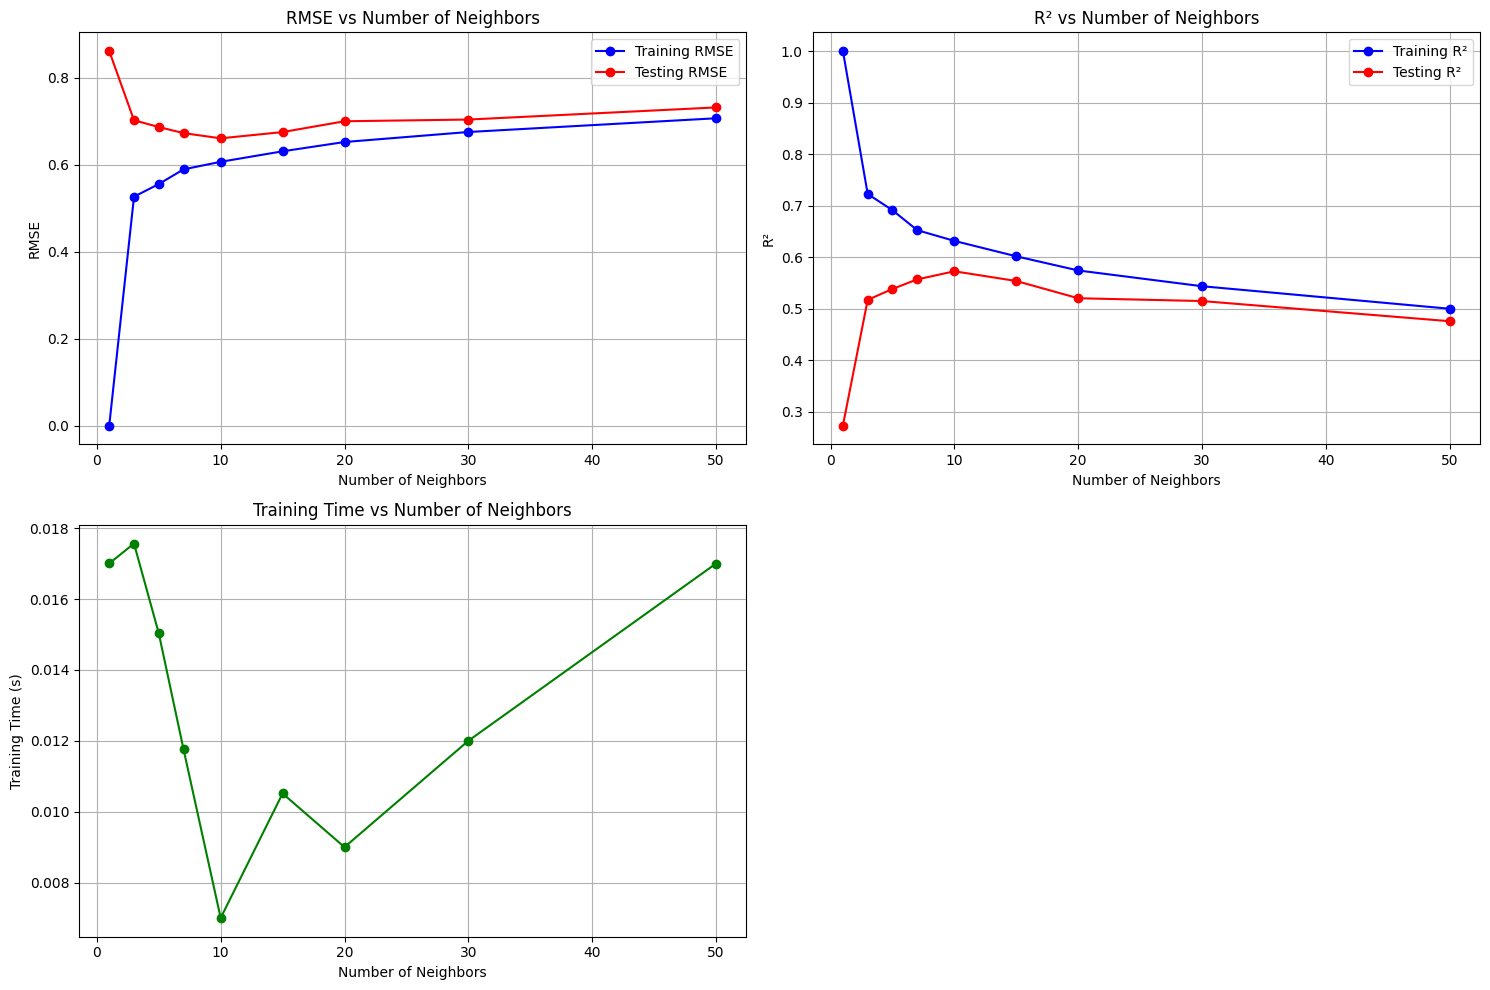


Performing hyperparameter tuning for V_16...
Optimal number of neighbors from sensitivity analysis: 10
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Best KNN Model - Training R²: 1.0000, RMSE: 0.0000
Best KNN Model - Testing R²: 0.5658, RMSE: 0.6662

Generating learning curves...


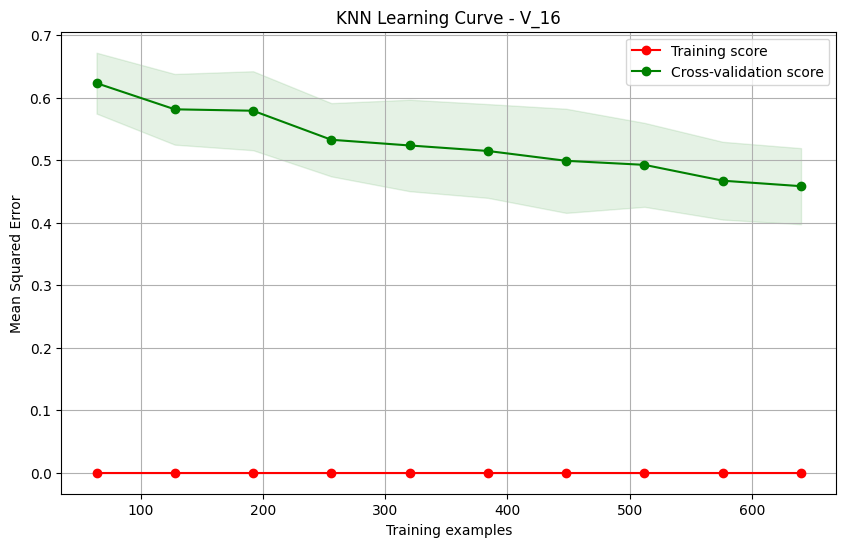

In [52]:
print("\n1. Training KNN for single voltage prediction (V_16)...")
knn_v16_results = train_knn_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


2. Training KNN for loss prediction...

Training base KNN model for loss...
Base KNN Model - Training R²: 0.6978, RMSE: 0.5497
Base KNN Model - Testing R²: 0.5522, RMSE: 0.6652

Performing sensitivity analysis on number of neighbors...
Training with 1 neighbors...
Training with 3 neighbors...
Training with 5 neighbors...
Training with 7 neighbors...
Training with 10 neighbors...
Training with 15 neighbors...
Training with 20 neighbors...
Training with 30 neighbors...
Training with 50 neighbors...


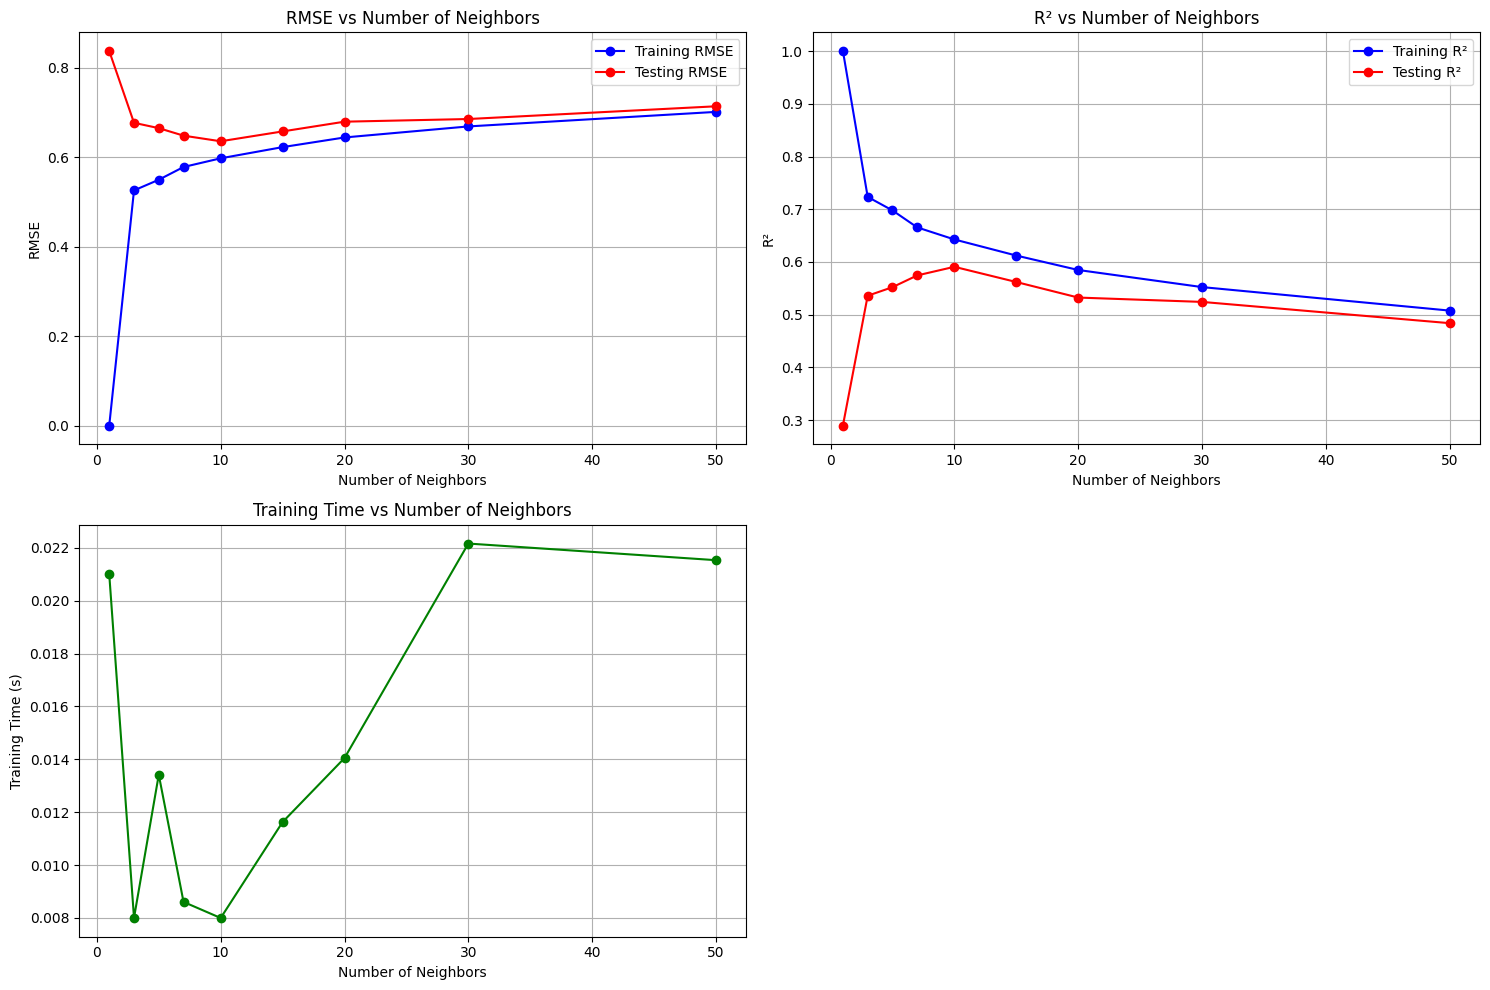


Performing hyperparameter tuning for loss...
Optimal number of neighbors from sensitivity analysis: 10
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Best KNN Model - Training R²: 1.0000, RMSE: 0.0000
Best KNN Model - Testing R²: 0.5865, RMSE: 0.6392

Generating learning curves...


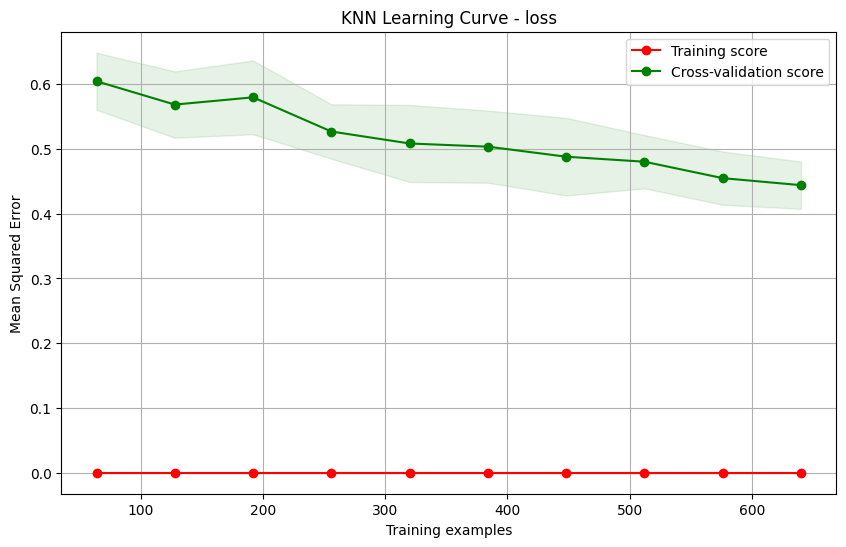

In [53]:
print("\n2. Training KNN for loss prediction...")
knn_loss_results = train_knn_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


3. Training KNN for all voltages prediction...

Training base KNN model for all_voltages...
Base KNN Model - Training R²: 0.6948, RMSE: 0.5525
Base KNN Model - Testing R²: 0.5481, RMSE: 0.6727

Performing sensitivity analysis on number of neighbors...
Training with 1 neighbors...
Training with 3 neighbors...
Training with 5 neighbors...
Training with 7 neighbors...
Training with 10 neighbors...
Training with 15 neighbors...
Training with 20 neighbors...
Training with 30 neighbors...
Training with 50 neighbors...


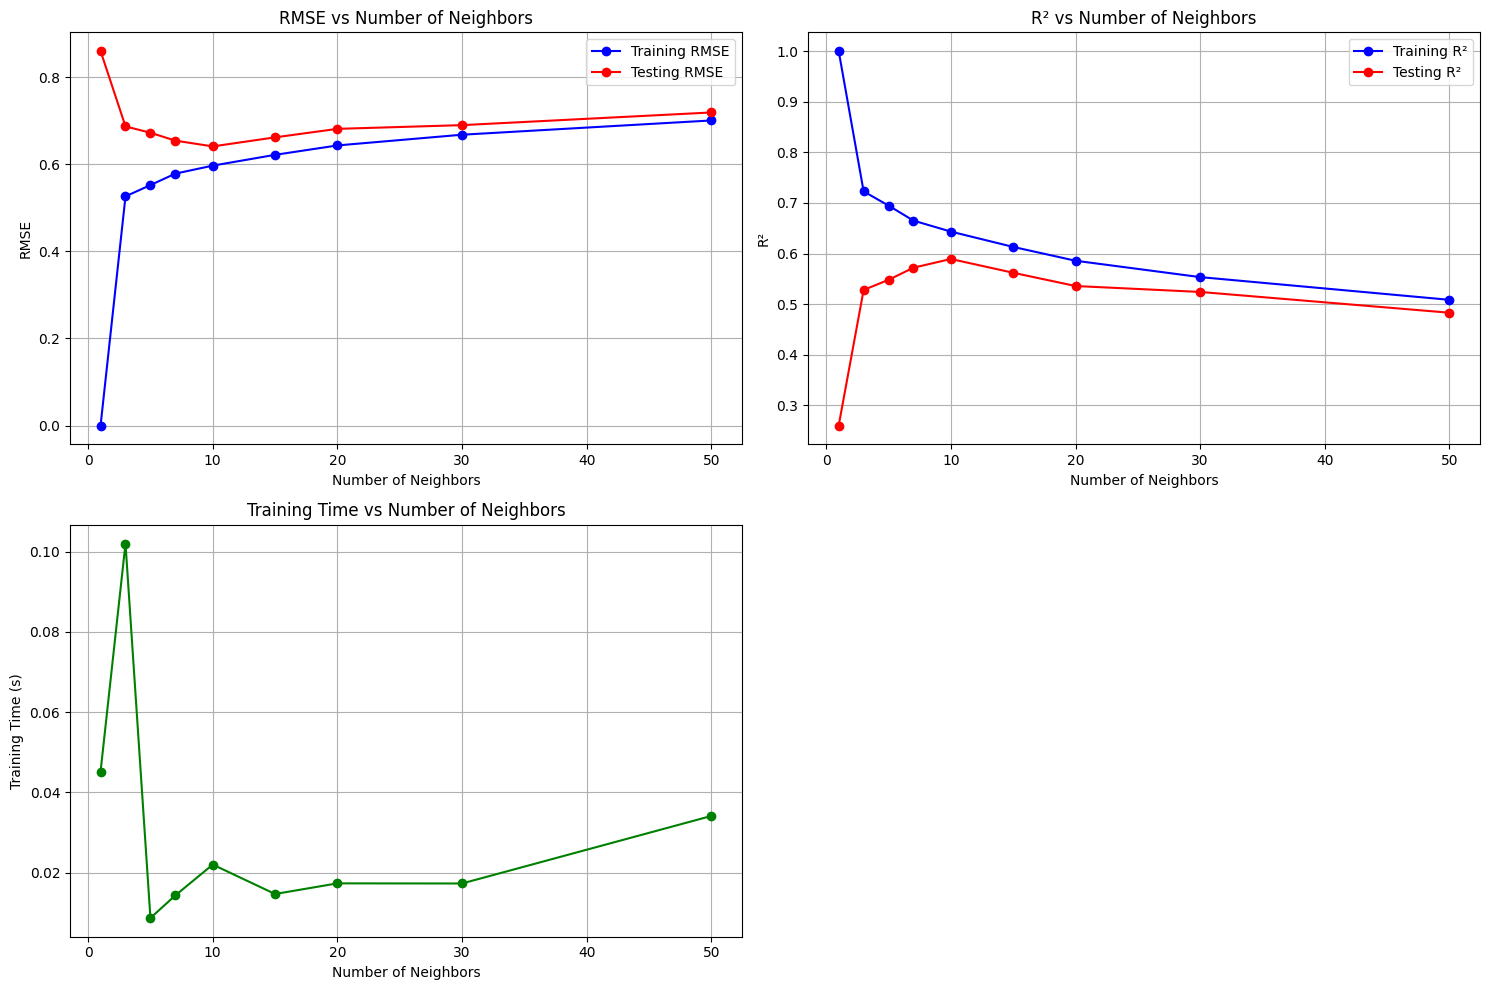


Performing hyperparameter tuning for all_voltages...
Optimal number of neighbors from sensitivity analysis: 10
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best KNN Model - Training R²: 1.0000, RMSE: 0.0000
Best KNN Model - Testing R²: 0.5919, RMSE: 0.6393

Generating learning curves...


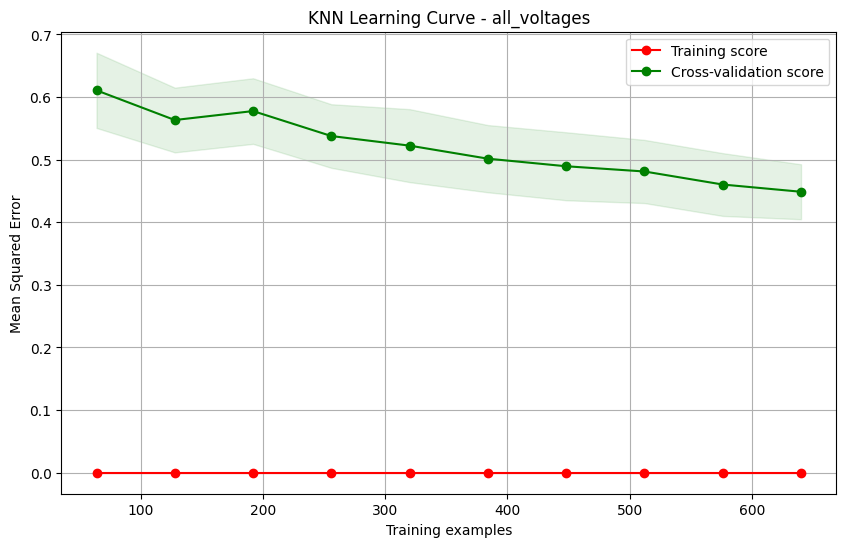

In [54]:
print("\n3. Training KNN for all voltages prediction...")
knn_all_v_results = train_knn_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [55]:
print("\nSaving trained KNN models...")
os.makedirs('models/knn', exist_ok=True)

with open('models/knn/knn_v16_best_model.pkl', 'wb') as f:
    pickle.dump(knn_v16_results['best_model']['model'], f)

with open('models/knn/knn_loss_best_model.pkl', 'wb') as f:
    pickle.dump(knn_loss_results['best_model']['model'], f)

with open('models/knn/knn_all_v_best_model.pkl', 'wb') as f:
    pickle.dump(knn_all_v_results['best_model']['model'], f)

print("KNN models saved successfully!")


Saving trained KNN models...
KNN models saved successfully!


In [56]:
print("\n=== KNN Models Summary ===")
print(f"V_16 Prediction - Test R²: {knn_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {knn_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {knn_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {knn_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {knn_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {knn_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")


=== KNN Models Summary ===
V_16 Prediction - Test R²: 0.5658, RMSE: 0.6662
Loss Prediction - Test R²: 0.5865, RMSE: 0.6392
All Voltages Prediction - Test R²: 0.5919, RMSE: 0.6393


### Artificial Neural Network (ANN)

In [57]:
def train_ann_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    train_losses = []
    val_losses = []
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 1. Base model for quick evaluation
    print(f"\nTraining base ANN model for {target_name}...")
    
    output_dim = 1 if len(y_train.shape) == 1 or y_train.shape[1] == 1 else y_train.shape[1]
    
    base_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim)
    ])
    
    base_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Use early stopping for all models
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    class LossHistory(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            train_losses.append(logs.get('loss'))
            val_losses.append(logs.get('val_loss'))
    
    history_callback = LossHistory()
    
    base_history = base_model.fit(
        X_train_scaled, y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, history_callback],
        verbose=1
    )
    
    y_train_pred = base_model.predict(X_train_scaled)
    y_test_pred = base_model.predict(X_test_scaled)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base ANN Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base ANN Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': base_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred,
        'history': base_history.history
    }
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(base_history.history['loss'], label='Training Loss')
    plt.plot(base_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'ANN Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(base_history.history['mae'], label='Training MAE')
    plt.plot(base_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'ANN Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann/{target_name}_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Sensitivity Analysis for ANN hyperparameters
    print(f"\nPerforming sensitivity analysis on network architecture...")
    
    architectures = [
        {'name': 'Small', 'layers': [32, 16]},
        {'name': 'Medium', 'layers': [64, 32]},
        {'name': 'Large', 'layers': [128, 64, 32]},
        {'name': 'Extra Large', 'layers': [256, 128, 64, 32]}
    ]
    
    architecture_results = []
    
    for arch in architectures:
        print(f"Training with {arch['name']} architecture: {arch['layers']}...")
        start_time = time.time()
        
        # Build model with this architecture
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(arch['layers'][0], activation='relu', input_shape=(X_train.shape[1],)))
        
        for units in arch['layers'][1:]:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        model.add(tf.keras.layers.Dense(output_dim))
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Train with early stopping
        history = model.fit(
            X_train_scaled, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        final_epochs = len(history.history['loss'])
        
        architecture_results.append({
            'name': arch['name'],
            'layers': arch['layers'],
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time,
            'epochs': final_epochs
        })
    
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs architecture
    plt.subplot(2, 2, 1)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_rmse'] for r in architecture_results], 
            alpha=0.6, label='Training RMSE')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_rmse'] for r in architecture_results], 
            alpha=0.6, label='Testing RMSE')
    plt.xlabel('Network Architecture')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Network Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot R² vs architecture
    plt.subplot(2, 2, 2)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_r2'] for r in architecture_results], 
            alpha=0.6, label='Training R²')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_r2'] for r in architecture_results], 
            alpha=0.6, label='Testing R²')
    plt.xlabel('Network Architecture')
    plt.ylabel('R²')
    plt.title('R² vs Network Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training time vs architecture
    plt.subplot(2, 2, 3)
    plt.bar([r['name'] for r in architecture_results], 
             [r['training_time'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Network Architecture')
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar([r['name'] for r in architecture_results], 
             [r['epochs'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs Network Architecture')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann/{target_name}_architecture_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['architecture_sensitivity'] = architecture_results
    
    # 3. Hyperparameter tuning
    print(f"\nPerforming learning rate and batch size tuning for {target_name}...")
    
    learning_rates = [0.001, 0.01, 0.0001]
    batch_sizes = [16, 32, 64]
    
    best_arch_idx = np.argmin([r['test_rmse'] for r in architecture_results])
    best_arch = architecture_results[best_arch_idx]['layers']
    
    hyperparameter_results = []
    
    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"Training with learning rate={lr}, batch size={bs}...")
            start_time = time.time()
            
            # Build model with best architecture
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
            
            for units in best_arch[1:]:
                model.add(tf.keras.layers.Dense(units, activation='relu'))
            
            model.add(tf.keras.layers.Dense(output_dim))
            
            # Customize optimizer with learning rate
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
            
            # Train with early stopping
            history = model.fit(
                X_train_scaled, y_train,
                epochs=200,
                batch_size=bs,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            training_time = time.time() - start_time
            final_epochs = len(history.history['loss'])
            
            hyperparameter_results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'training_time': training_time,
                'epochs': final_epochs
            })
    
    best_hp_idx = np.argmin([r['test_rmse'] for r in hyperparameter_results])
    best_lr = hyperparameter_results[best_hp_idx]['learning_rate']
    best_bs = hyperparameter_results[best_hp_idx]['batch_size']
    
    print(f"Best hyperparameters: learning_rate={best_lr}, batch_size={best_bs}")
    
    plt.figure(figsize=(12, 10))
    
    hp_labels = [f"lr={r['learning_rate']}, bs={r['batch_size']}" for r in hyperparameter_results]
    
    # Plot test RMSE vs hyperparameters
    plt.subplot(2, 2, 1)
    plt.bar(hp_labels, [r['test_rmse'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test RMSE')
    plt.title('Test RMSE vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot test R² vs hyperparameters
    plt.subplot(2, 2, 2)
    plt.bar(hp_labels, [r['test_r2'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test R²')
    plt.title('Test R² vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot training time
    plt.subplot(2, 2, 3)
    plt.bar(hp_labels, [r['training_time'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar(hp_labels, [r['epochs'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann/{target_name}_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['hyperparameter_tuning'] = hyperparameter_results
    
    # 4. Train best model with optimal settings
    print(f"\nTraining final ANN model with best parameters...")
    
    best_model = tf.keras.Sequential()
    best_model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
    
    for units in best_arch[1:]:
        best_model.add(tf.keras.layers.Dense(units, activation='relu'))
    
    best_model.add(tf.keras.layers.Dense(output_dim))
    
    # Create tensorboard callback
    tensorboard_dir = f"logs/ann_{target_name}_{int(time.time())}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        histogram_freq=1
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
    best_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    best_history = best_model.fit(
        X_train_scaled, y_train,
        epochs=300,
        batch_size=best_bs,
        validation_split=0.2,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )
    
    best_train_pred = best_model.predict(X_train_scaled)
    best_test_pred = best_model.predict(X_test_scaled)
    
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best ANN Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best ANN Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    results['best_model'] = {
        'model': best_model,
        'scaler': scaler,
        'params': {
            'learning_rate': best_lr,
            'batch_size': best_bs,
            'architecture': best_arch
        },
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred,
        'history': best_history.history
    }
    
    # Plot final model training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Best ANN Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['mae'], label='Training MAE')
    plt.plot(best_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Best ANN Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann/{target_name}_best_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Feature sensitivity analysis (similar to feature importance in RF)
    if len(y_train.shape) == 1 or y_train.shape[1] == 1:
        print("\nAnalyzing feature sensitivity...")
        
        feature_sensitivity_model = tf.keras.Sequential()
        feature_sensitivity_model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
        
        for units in best_arch[1:]:
            feature_sensitivity_model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        feature_sensitivity_model.add(tf.keras.layers.Dense(output_dim))
        
        feature_sensitivity_model.compile(optimizer=optimizer, loss='mse')
        
        # Load weights from the best model
        feature_sensitivity_model.set_weights(best_model.get_weights())
        
        # Calculate feature sensitivity using permutation importance
        perm_importance = permutation_importance(
            feature_sensitivity_model,
            X_test_scaled,
            y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1,
            scoring='r2'
        )
        
        importances = perm_importance.importances_mean
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        indices = np.argsort(importances)[::-1]
        plt.title(f'ANN Feature Sensitivity - {target_name}')
        plt.bar(range(min(20, len(feature_names))), importances[indices][:min(20, len(feature_names))], align='center')
        plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices][:min(20, len(feature_names))], rotation=90)
        plt.tight_layout()
        plt.savefig(f'figures/ann/{target_name}_feature_sensitivity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store top 10 important features
        top_features = [(feature_names[idx], importances[idx]) for idx in indices[:10]]
        results['feature_sensitivity'] = {
            'importances': importances,
            'top_features': top_features
        }
    
    # 6. Plot actual vs predicted values for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'ANN: Actual vs Predicted - {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/ann/{target_name}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. Learning curve for ANN
    print("\nGenerating learning curves based on training data size...")
    
    train_sizes = np.linspace(0.2, 1.0, 5)
    train_errors = []
    val_errors = []
    
    def train_with_subset(subset_ratio):
        subset_size = int(X_train_scaled.shape[0] * subset_ratio)
        X_subset = X_train_scaled[:subset_size]
        y_subset = y_train[:subset_size]
        
        val_split = 0.2
        val_size = int(subset_size * val_split)
        X_train_part = X_subset[:-val_size]
        y_train_part = y_subset[:-val_size]
        X_val_part = X_subset[-val_size:]
        y_val_part = y_subset[-val_size:]
        
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
        
        for units in best_arch[1:]:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        model.add(tf.keras.layers.Dense(output_dim))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        
        model.fit(
            X_train_part, y_train_part,
            epochs=100,
            batch_size=best_bs,
            verbose=0
        )
        
        train_mse = model.evaluate(X_train_part, y_train_part, verbose=0)
        val_mse = model.evaluate(X_val_part, y_val_part, verbose=0)
        
        return train_mse, val_mse
    
    # Generate learning curve
    for size in train_sizes:
        print(f"Training with {size*100:.0f}% of data...")
        train_err, val_err = train_with_subset(size)
        train_errors.append(train_err)
        val_errors.append(val_err)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * 100, train_errors, 'o-', color="r", label="Training error")
    plt.plot(train_sizes * 100, val_errors, 'o-', color="g", label="Validation error")
    plt.xlabel("Training data size (%)")
    plt.ylabel("Mean Squared Error")
    plt.title(f"ANN Learning Curve - {target_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'figures/ann/{target_name}_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Store the learning curve data
    results['learning_curve'] = {
        'train_sizes': train_sizes,
        'train_errors': train_errors,
        'val_errors': val_errors
    }
    
    # Save all results and metrics to CSV
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error'],
        'Base Train': [results['base_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Base Test': [results['base_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Train': [results['best_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Test': [results['best_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']]
    })
    
    results_df.to_csv(f'results/ann_{target_name}_metrics.csv', index=False)
    
    return results

In [58]:
os.makedirs('models/ann', exist_ok=True)
os.makedirs('logs', exist_ok=True)


1. Training ANN for single voltage prediction (V_16)...

Training base ANN model for V_16...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9491 - mae: 0.7800 - val_loss: 0.5166 - val_mae: 0.5723
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3607 - mae: 0.4660 - val_loss: 0.2371 - val_mae: 0.3910
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1547 - mae: 0.3095 - val_loss: 0.1587 - val_mae: 0.3219
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0912 - mae: 0.2401 - val_loss: 0.1343 - val_mae: 0.2984
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0636 - mae: 0.1996 - val_loss: 0.1235 - val_mae: 0.2885
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 - mae: 0.1702 - val_loss: 0.1136 - val_mae: 0.2779
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0340 - mae: 0.1479 - val_loss: 0.1049 - val_mae: 0.2681
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - mae: 0.1299 - val_

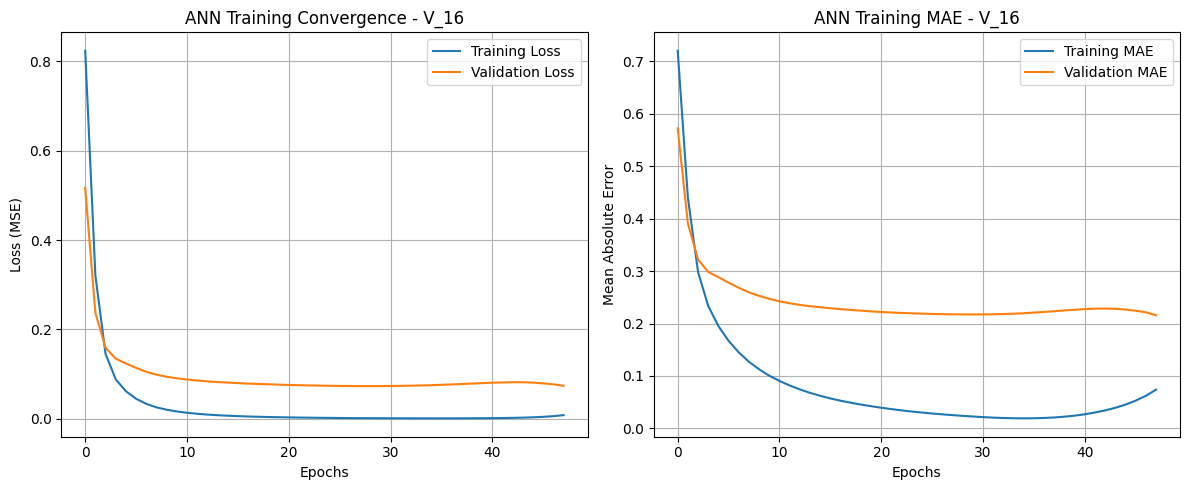


Performing sensitivity analysis on network architecture...
Training with Small architecture: [32, 16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training with Medium architecture: [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training with Large architecture: [128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training with Extra Large architecture: [256, 128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


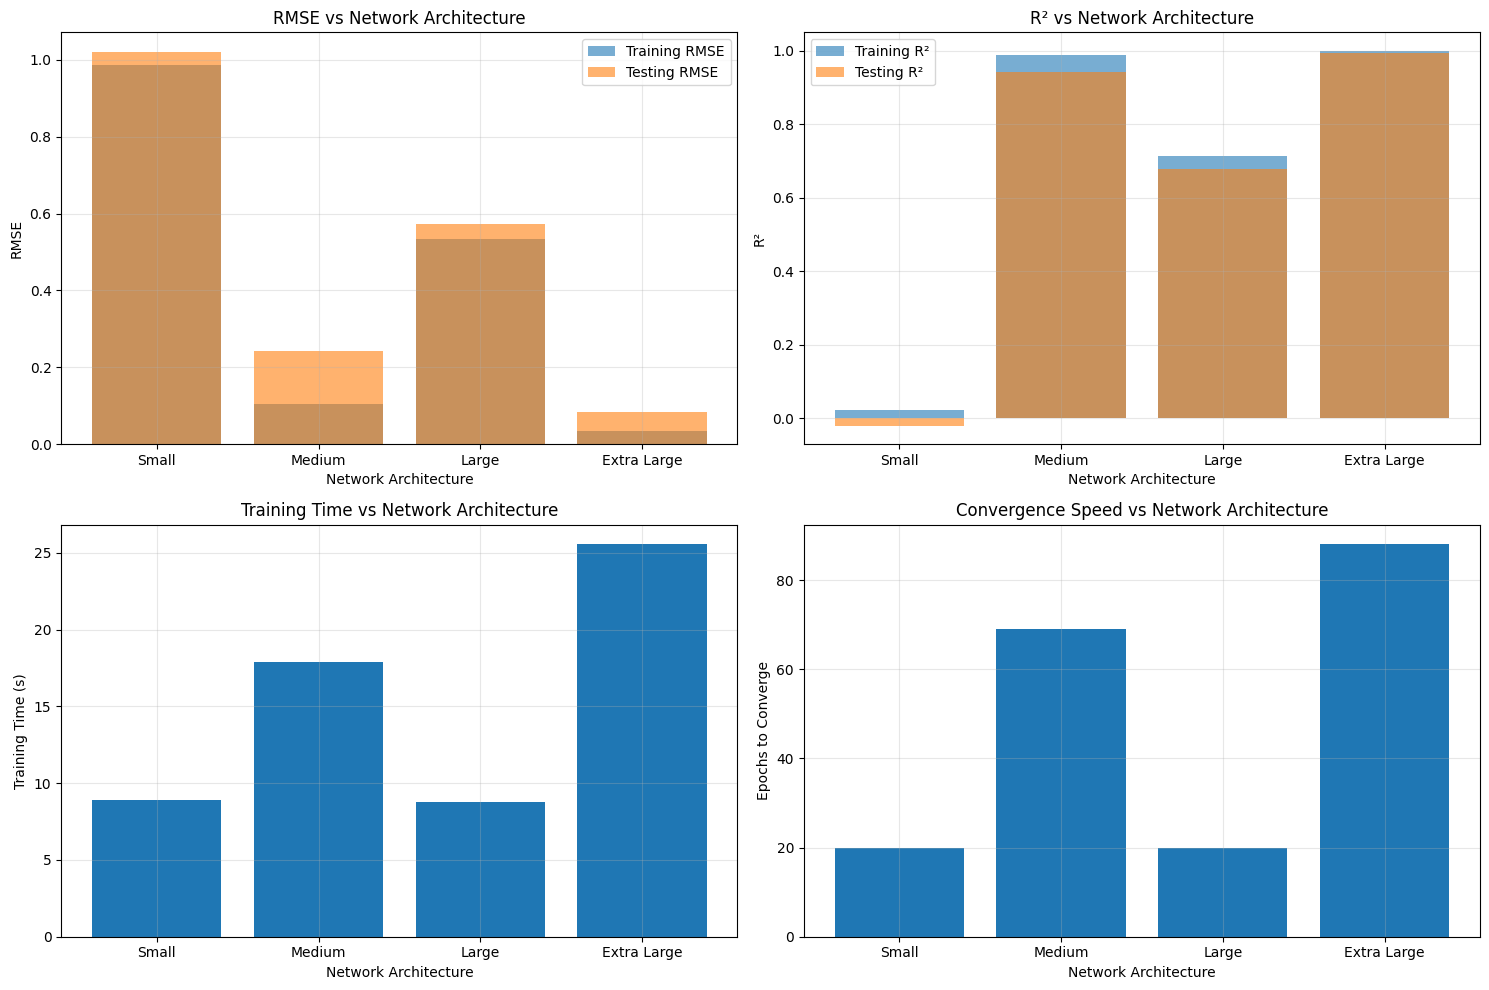


Performing learning rate and batch size tuning for V_16...
Training with learning rate=0.001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Training with learning rate=0.001, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training with learning rate=0.001, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Training with learning rate=0.01, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training with learning rate=0.01, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Training with learning rate=0.01, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with learning rate=0.0001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training with learning rate=0.0001,

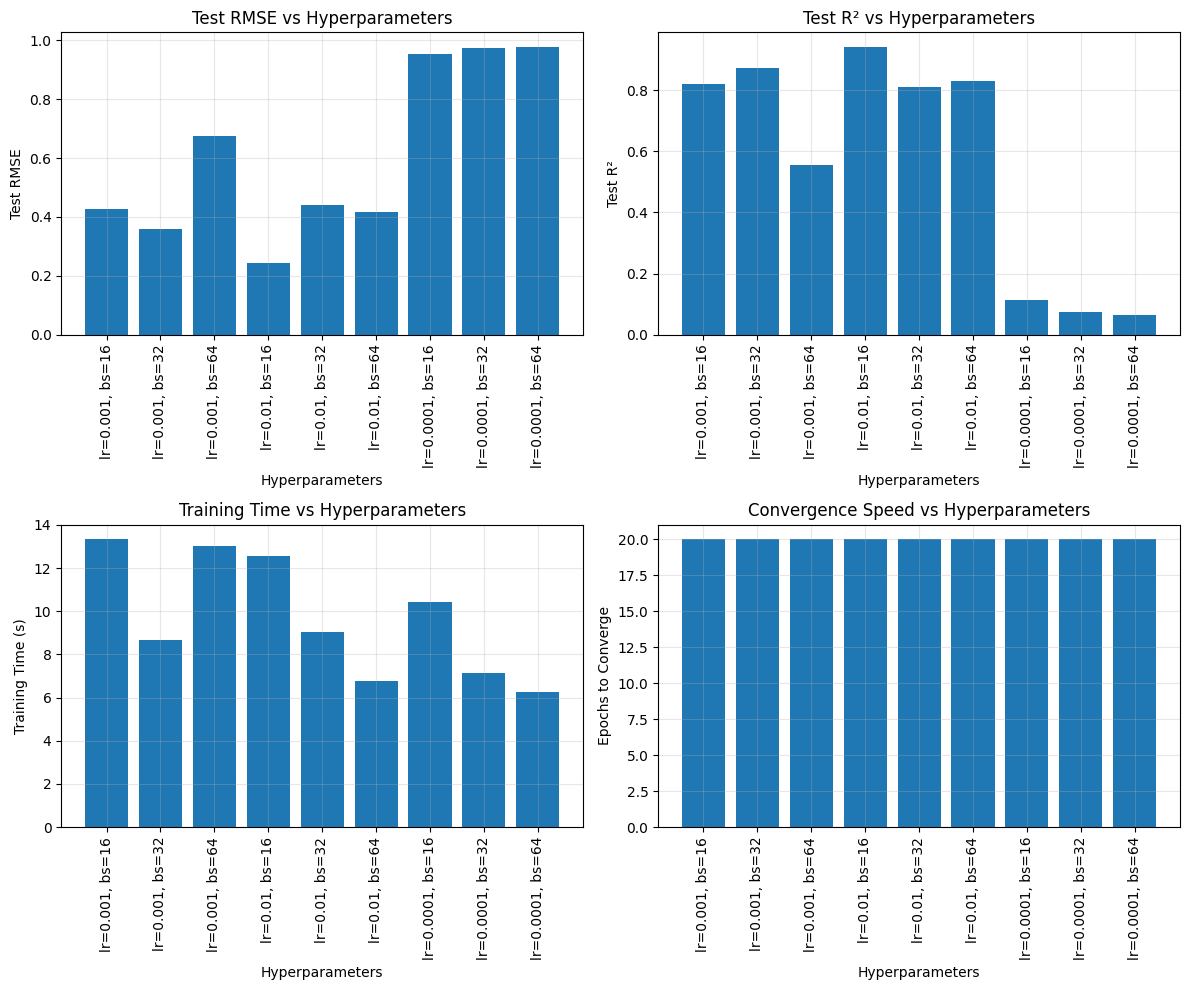


Training final ANN model with best parameters...
Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.6827 - mae: 0.6187 - val_loss: 0.0572 - val_mae: 0.1877
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0311 - mae: 0.1369 - val_loss: 0.0236 - val_mae: 0.1269
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159 - mae: 0.0999 - val_loss: 0.0221 - val_mae: 0.1158
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0142 - mae: 0.0908 - val_loss: 0.0156 - val_mae: 0.1021
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133 - mae: 0.0853 - val_loss: 0.0167 - val_mae: 0.0993
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0140 - mae: 0.0868 - val_loss: 0.0388 - val_mae: 0.1475
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0257 - mae: 0.1151 - val_loss: 0.0989 - val_mae: 0.2230
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0634 - mae: 0.1806 - val_loss: 0.0528 - val_mae: 0.1757
Epoch 9

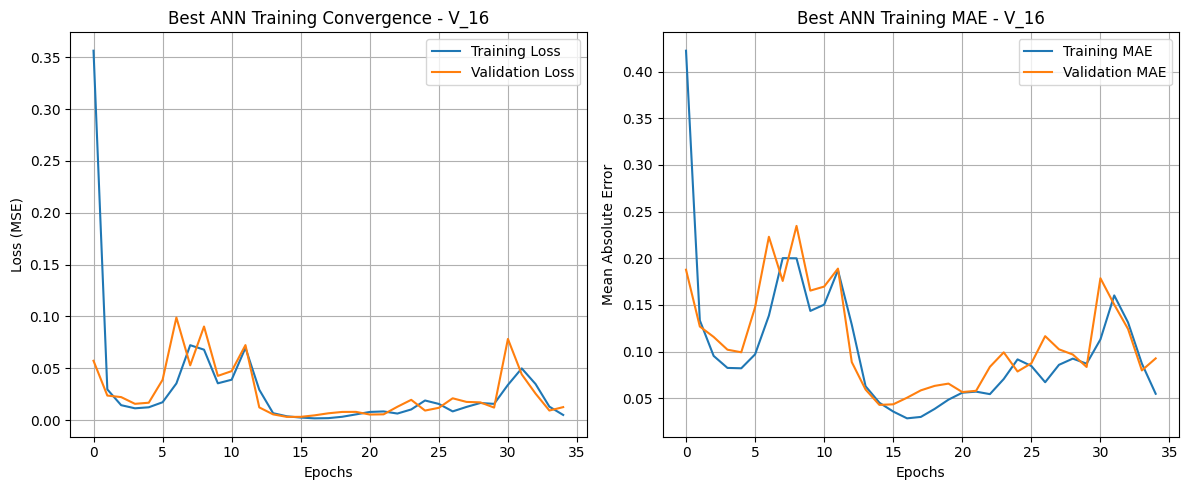


Analyzing feature sensitivity...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


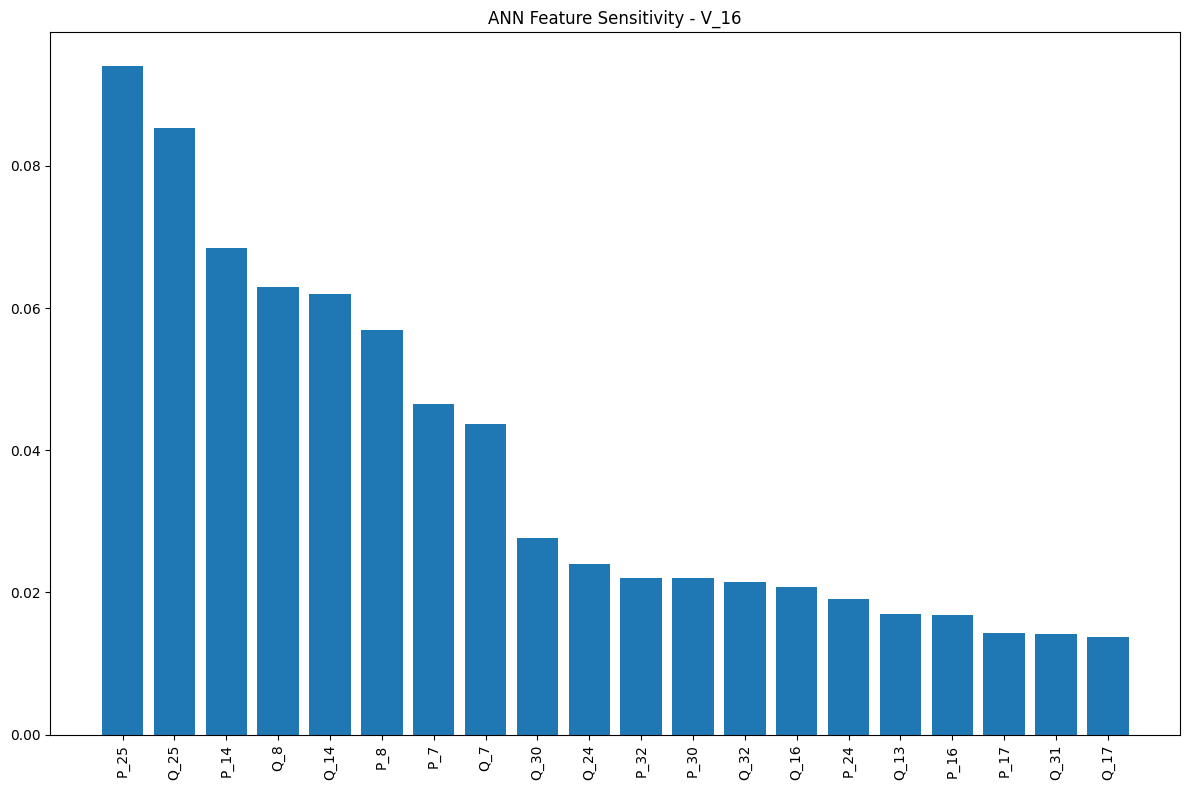

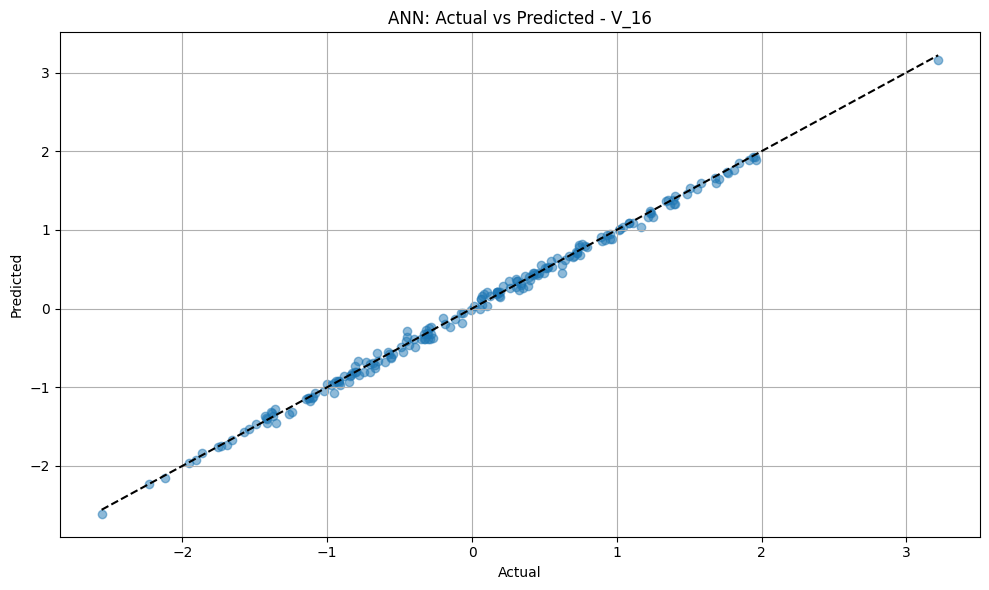


Generating learning curves based on training data size...
Training with 20% of data...
Training with 40% of data...
Training with 60% of data...
Training with 80% of data...
Training with 100% of data...


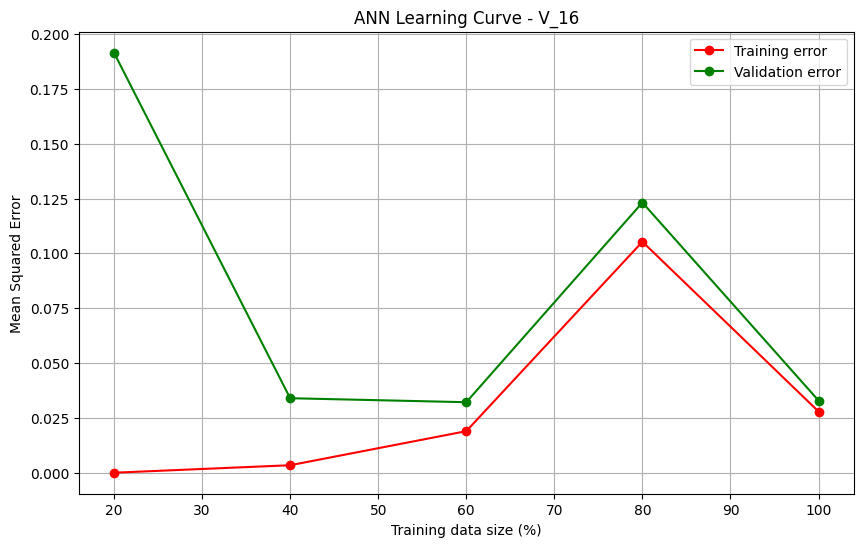

In [60]:
print("\n1. Training ANN for single voltage prediction (V_16)...")
ann_v16_results = train_ann_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


2. Training ANN for loss prediction...

Training base ANN model for loss...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.0310 - mae: 0.8346 - val_loss: 0.6923 - val_mae: 0.6806
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3970 - mae: 0.5104 - val_loss: 0.3082 - val_mae: 0.4484
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1482 - mae: 0.3138 - val_loss: 0.1847 - val_mae: 0.3289
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1022 - mae: 0.2555 - val_loss: 0.1692 - val_mae: 0.3143
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0747 - mae: 0.2179 - val_loss: 0.1587 - val_mae: 0.3056
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - mae: 0.1885 - val_loss: 0.1463 - val_mae: 0.2938
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0437 - mae: 0.1666 - val_loss: 0.1371 - val_mae: 0.2847
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347 - mae: 0.1487 - val_loss: 0.1292 - va

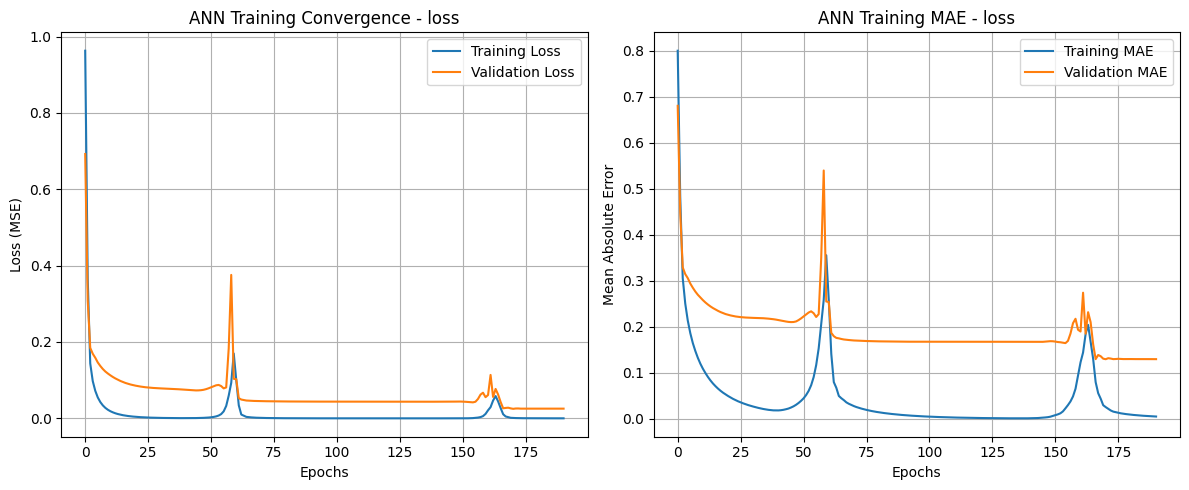


Performing sensitivity analysis on network architecture...
Training with Small architecture: [32, 16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training with Medium architecture: [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training with Large architecture: [128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with Extra Large architecture: [256, 128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


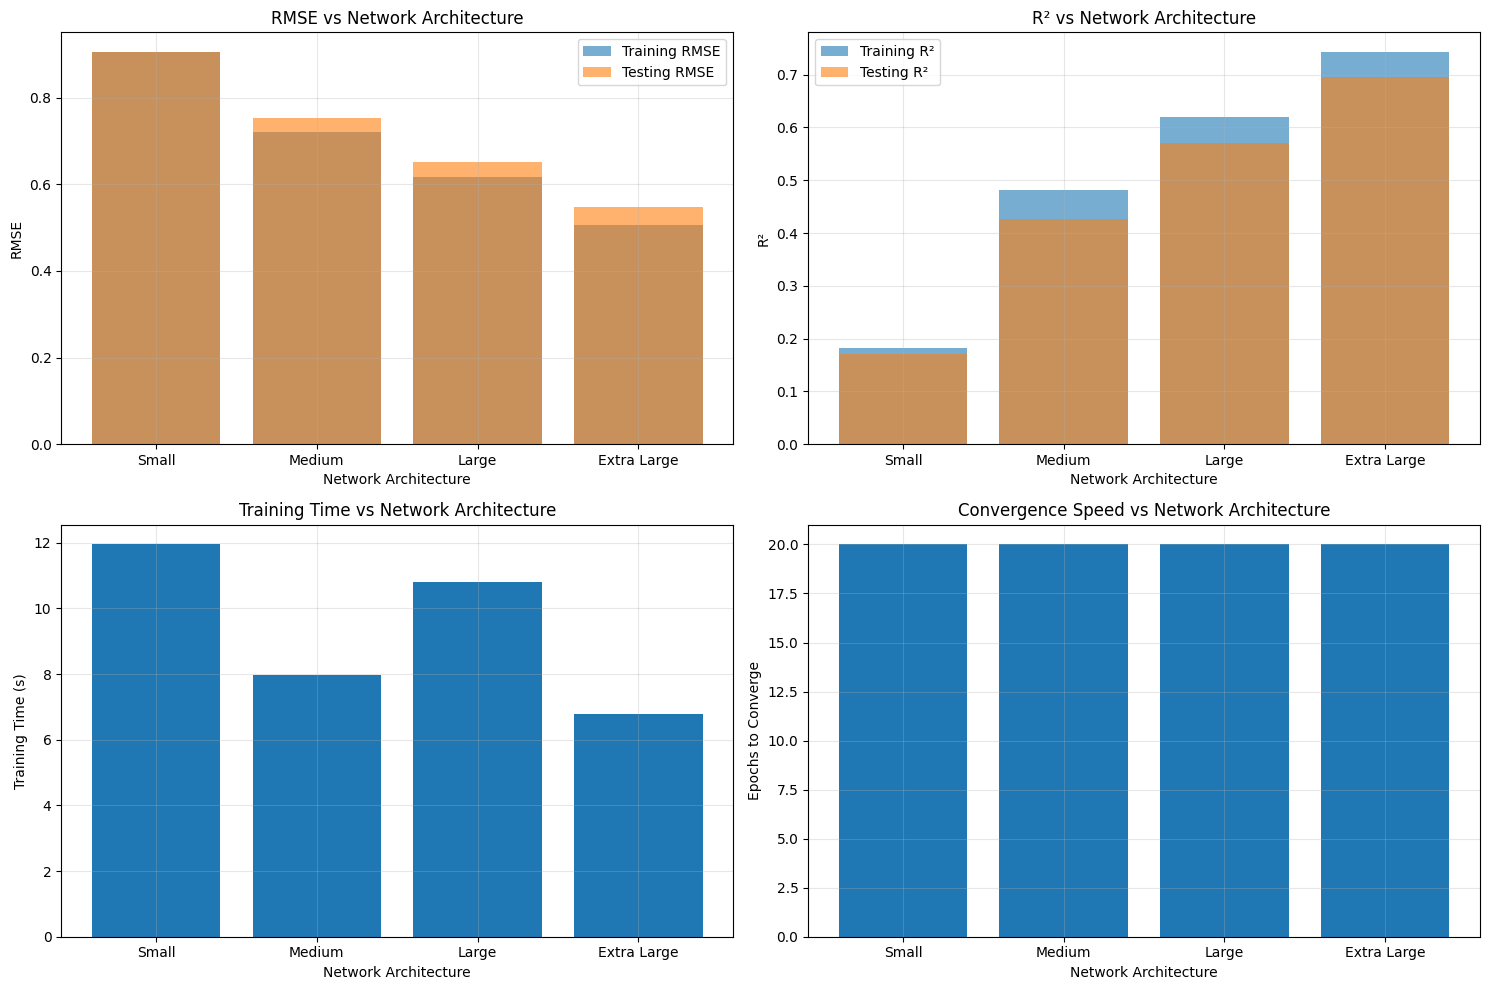


Performing learning rate and batch size tuning for loss...
Training with learning rate=0.001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with learning rate=0.001, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Training with learning rate=0.001, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Training with learning rate=0.01, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training with learning rate=0.01, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training with learning rate=0.01, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training with learning rate=0.0001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with learning rate=0.00

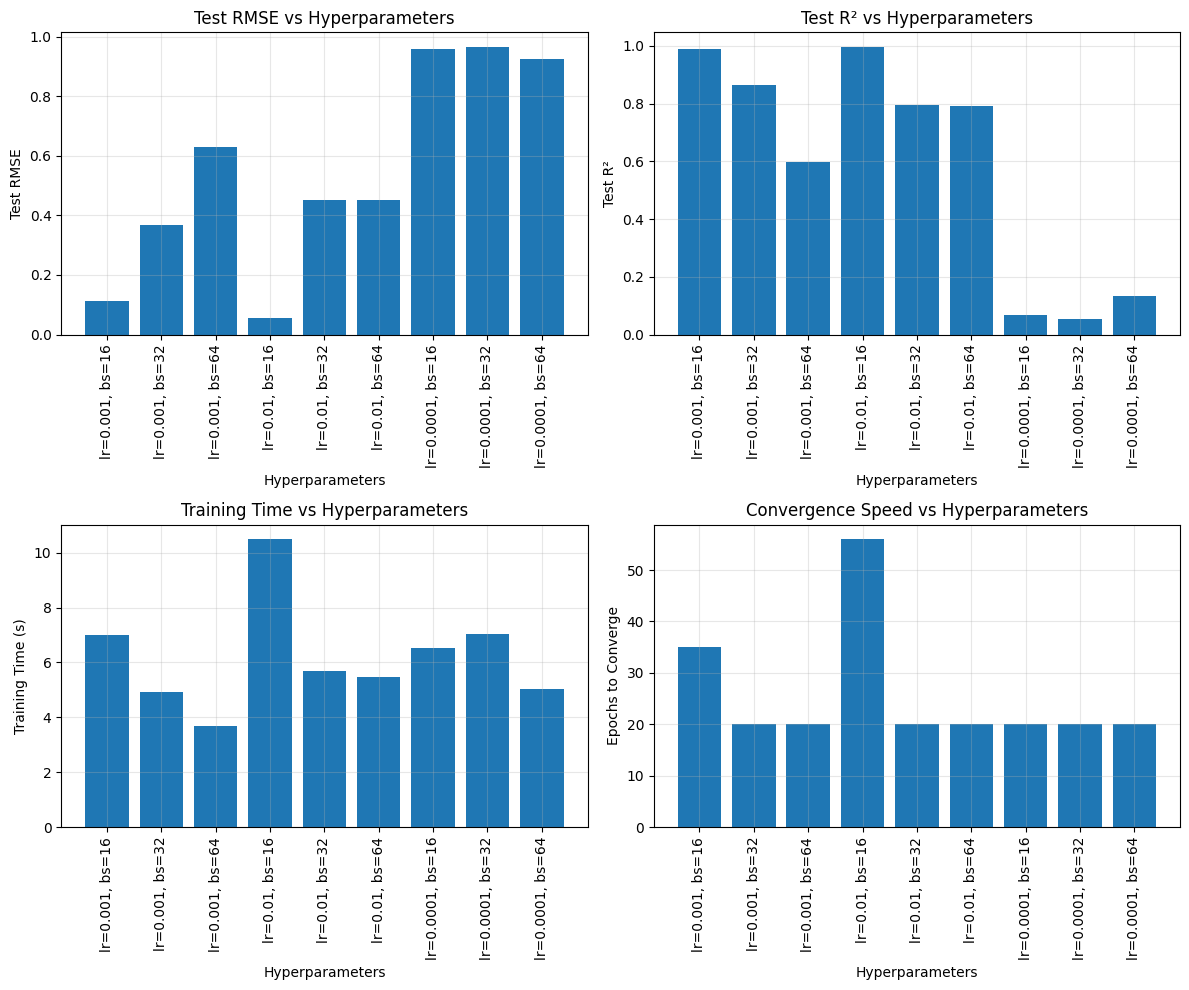


Training final ANN model with best parameters...
Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.7541 - mae: 0.6222 - val_loss: 0.0346 - val_mae: 0.1467
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0350 - mae: 0.1490 - val_loss: 0.0626 - val_mae: 0.2007
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0381 - mae: 0.1573 - val_loss: 0.0418 - val_mae: 0.1462
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281 - mae: 0.1295 - val_loss: 0.0149 - val_mae: 0.0952
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - mae: 0.1029 - val_loss: 0.0133 - val_mae: 0.0882
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0132 - mae: 0.0882 - val_loss: 0.0188 - val_mae: 0.1063
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 - mae: 0.0998 - val_loss: 0.0517 - val_mae: 0.1793
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0243 - mae: 0.1158 - val_loss: 0.0589 - val_mae: 0.1909
Epoch 9/300

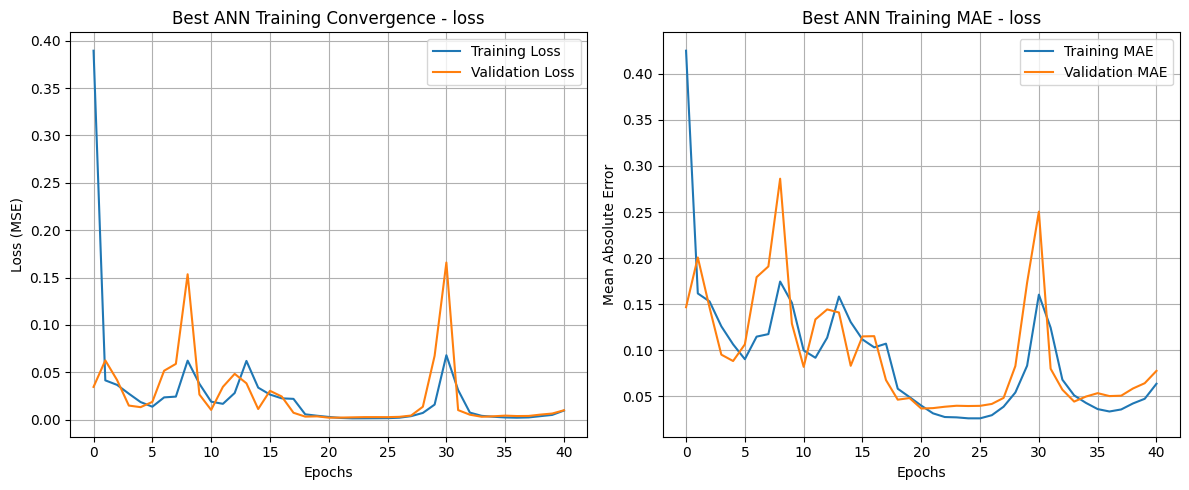


Analyzing feature sensitivity...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


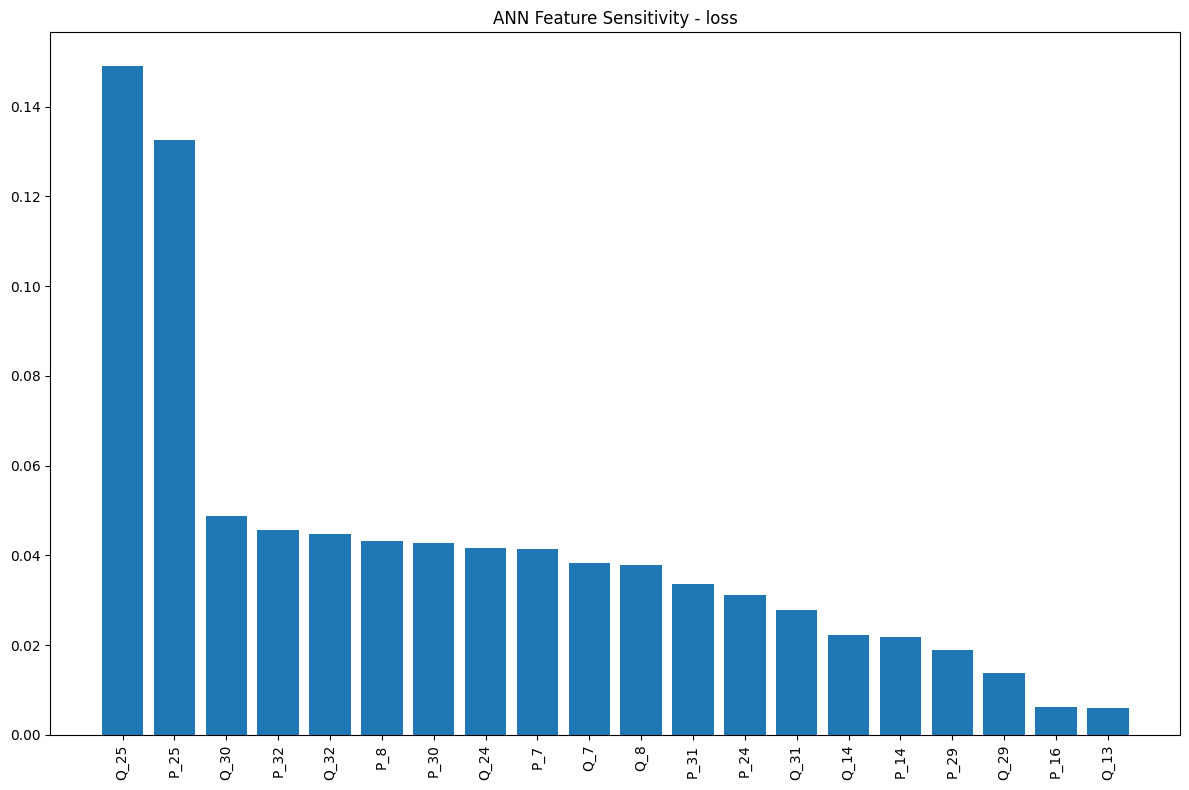

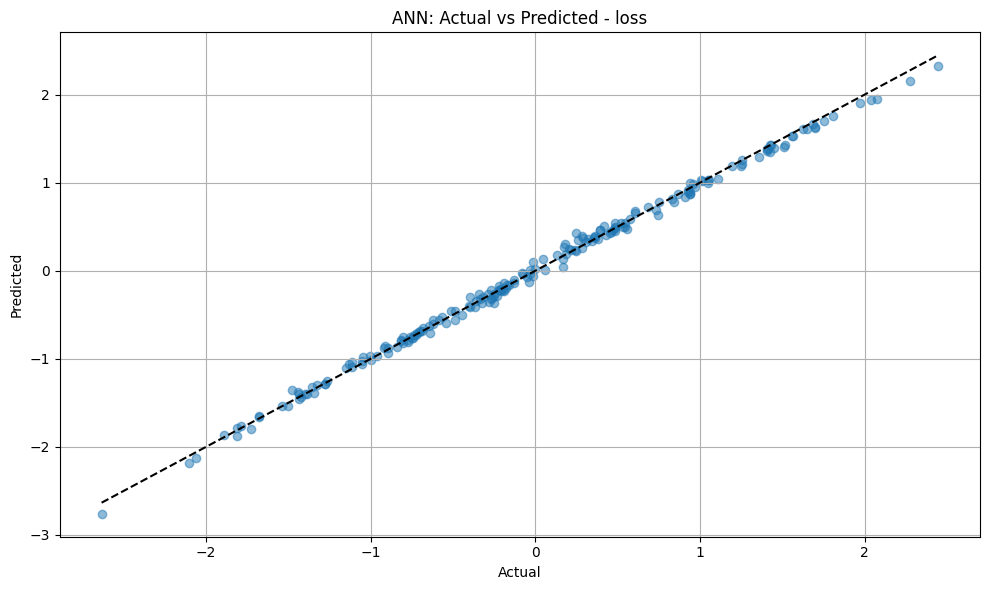


Generating learning curves based on training data size...
Training with 20% of data...
Training with 40% of data...
Training with 60% of data...
Training with 80% of data...
Training with 100% of data...


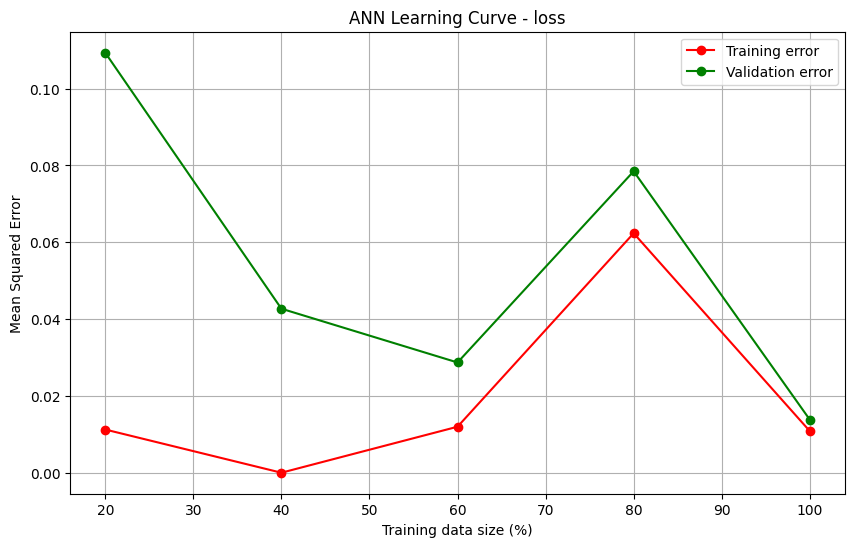

In [61]:
print("\n2. Training ANN for loss prediction...")
ann_loss_results = train_ann_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


3. Training ANN for all voltages prediction...

Training base ANN model for all_voltages...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2327 - mae: 0.8802 - val_loss: 1.1346 - val_mae: 0.8484
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9363 - mae: 0.7663 - val_loss: 1.0101 - val_mae: 0.7980
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8000 - mae: 0.7047 - val_loss: 0.8402 - val_mae: 0.7219
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5992 - mae: 0.6024 - val_loss: 0.5478 - val_mae: 0.5707
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3511 - mae: 0.4528 - val_loss: 0.2870 - val_mae: 0.4079
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1917 - mae: 0.3383 - val_loss: 0.1803 - val_mae: 0.3278
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1300 - mae: 0.2818 - val_loss: 0.1381 - val_mae: 0.2887
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1035 - mae: 0.2521 - val_l

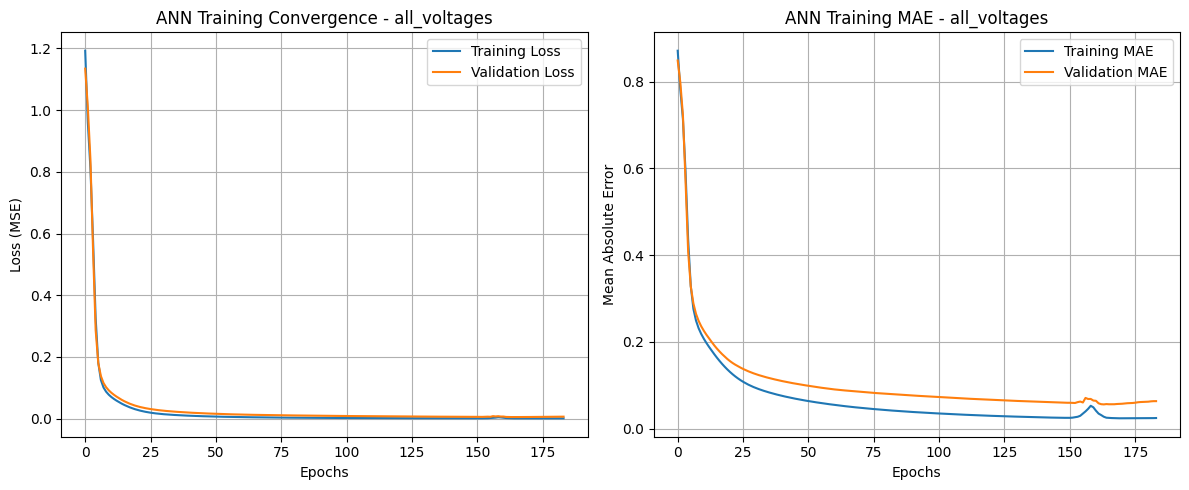


Performing sensitivity analysis on network architecture...
Training with Small architecture: [32, 16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Training with Medium architecture: [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with Large architecture: [128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with Extra Large architecture: [256, 128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


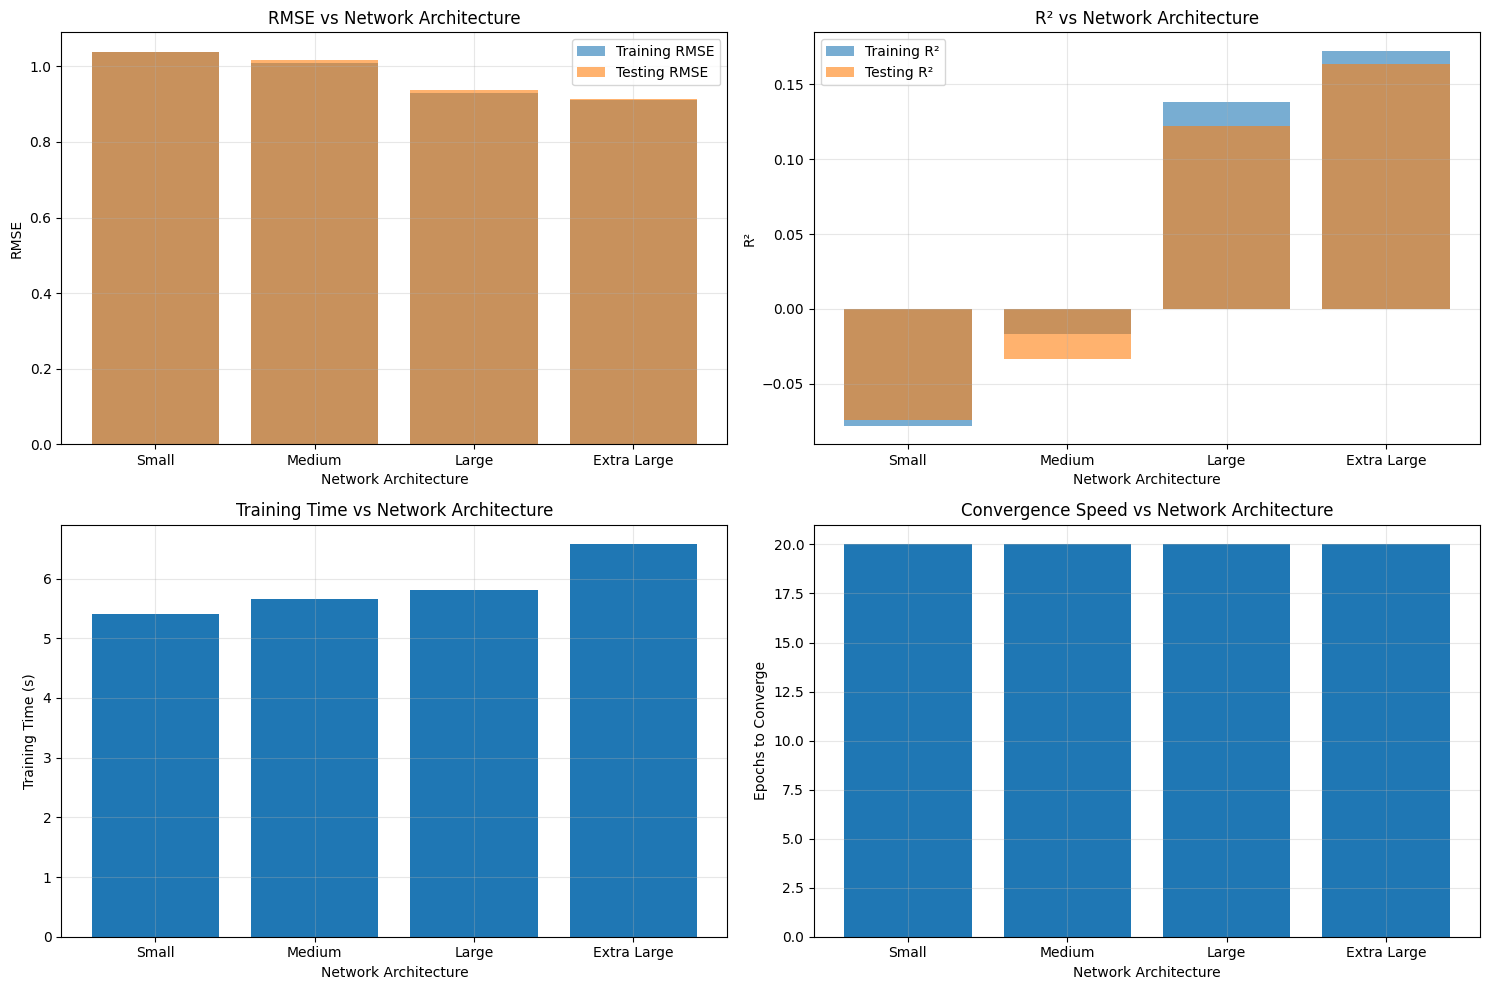


Performing learning rate and batch size tuning for all_voltages...
Training with learning rate=0.001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training with learning rate=0.001, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training with learning rate=0.001, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training with learning rate=0.01, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Training with learning rate=0.01, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training with learning rate=0.01, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training with learning rate=0.0001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Training with learning ra

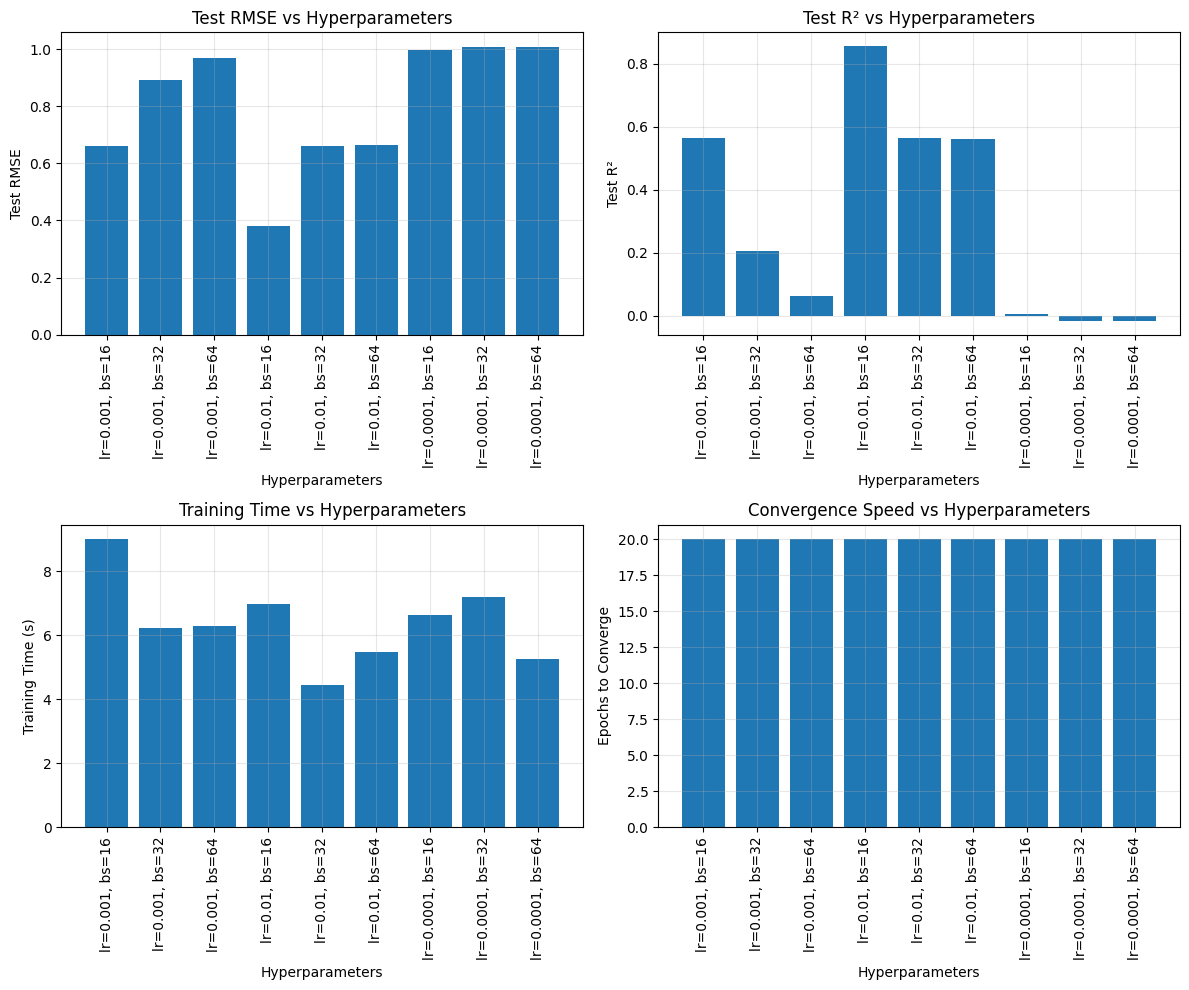


Training final ANN model with best parameters...
Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5319 - mae: 0.5572 - val_loss: 0.1254 - val_mae: 0.2771
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1096 - mae: 0.2572 - val_loss: 0.0785 - val_mae: 0.2205
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0711 - mae: 0.2059 - val_loss: 0.0437 - val_mae: 0.1616
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0429 - mae: 0.1576 - val_loss: 0.0349 - val_mae: 0.1449
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0314 - mae: 0.1354 - val_loss: 0.0284 - val_mae: 0.1297
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0413 - mae: 0.1517 - val_loss: 0.0438 - val_mae: 0.1615
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0474 - mae: 0.1659 - val_loss: 0.0490 - val_mae: 0.1716
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0431 - mae: 0.1603 - val_loss: 0.0247 - val_mae: 0.1210
Epoch 9/30

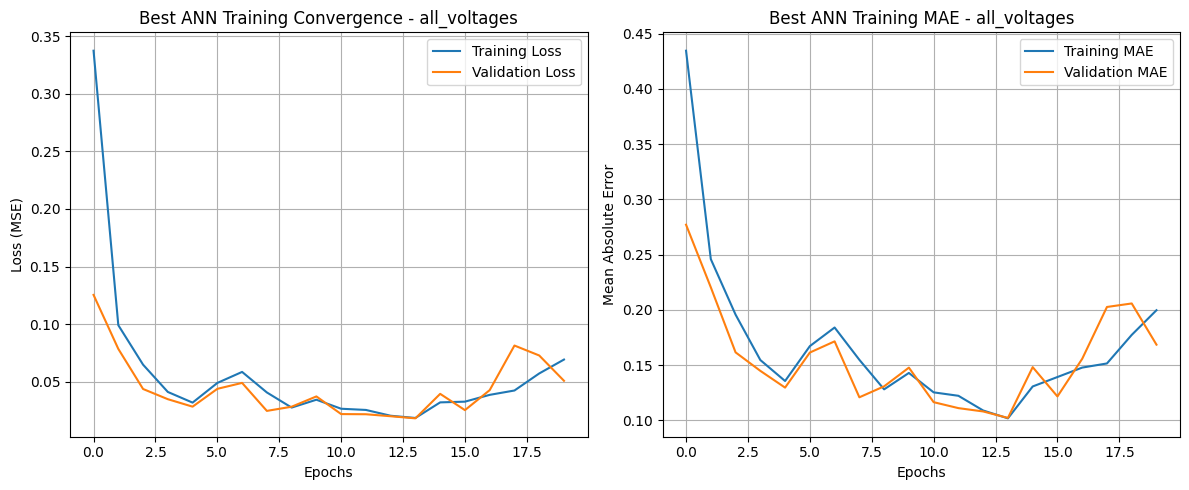

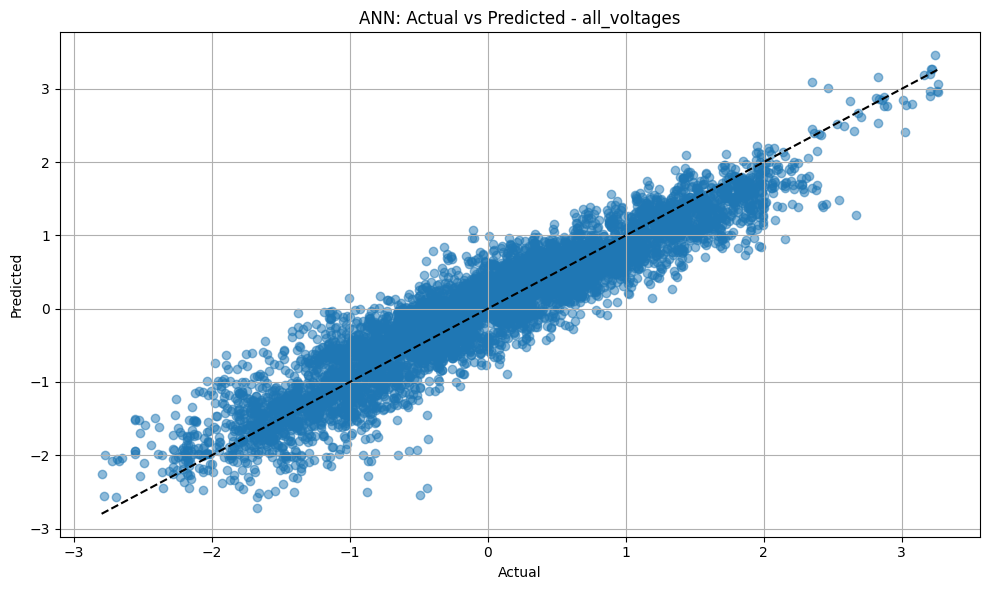


Generating learning curves based on training data size...
Training with 20% of data...
Training with 40% of data...
Training with 60% of data...
Training with 80% of data...
Training with 100% of data...


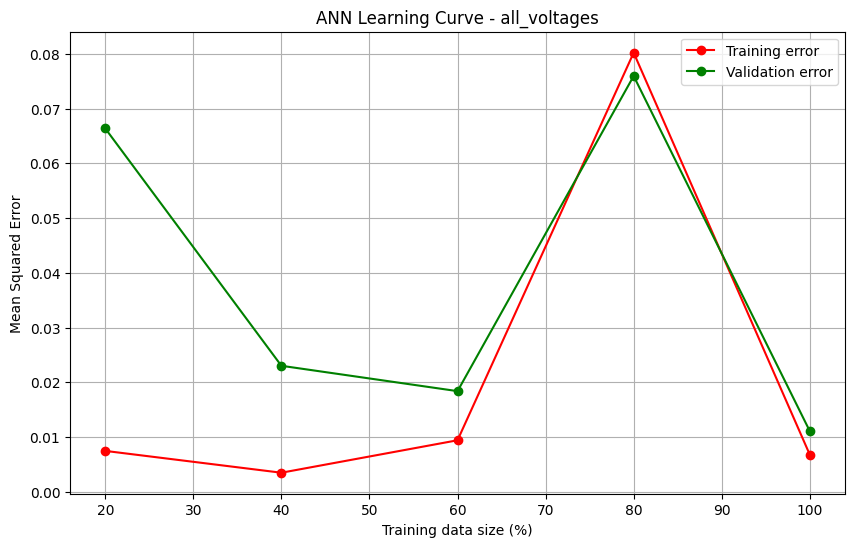

In [62]:
print("\n3. Training ANN for all voltages prediction...")
ann_all_v_results = train_ann_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [63]:
print("\nSaving trained ANN models...")

ann_v16_results['best_model']['model'].save('models/ann/ann_v16_best_model.keras')
ann_loss_results['best_model']['model'].save('models/ann/ann_loss_best_model.keras')
ann_all_v_results['best_model']['model'].save('models/ann/ann_all_v_best_model.keras')

with open('models/ann/ann_v16_scaler.pkl', 'wb') as f:
    pickle.dump(ann_v16_results['best_model']['scaler'], f)

with open('models/ann/ann_loss_scaler.pkl', 'wb') as f:
    pickle.dump(ann_loss_results['best_model']['scaler'], f)

with open('models/ann/ann_all_v_scaler.pkl', 'wb') as f:
    pickle.dump(ann_all_v_results['best_model']['scaler'], f)
    
print("ANN models saved successfully!")


Saving trained ANN models...
ANN models saved successfully!


In [72]:
print("ANN models saved successfully!")
print("\n=== ANN Models Summary ===")
print(f"V_16 Prediction - Test R²: {ann_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {ann_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {ann_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {ann_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {ann_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {ann_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")

ANN models saved successfully!

=== ANN Models Summary ===
V_16 Prediction - Test R²: 0.9056, RMSE: 0.3107
Loss Prediction - Test R²: 0.9394, RMSE: 0.2447
All Voltages Prediction - Test R²: 0.8798, RMSE: 0.3470


### Long Short-Term Memory (LSTM)

In [ ]:
def train_lstm_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    train_losses = []
    val_losses = []
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Using a novel approach: treating features as sequential spatial dependencies and reshaping data with a sliding window over features
    def create_feature_sequences(X, window_size=4):
        n_samples, n_features = X.shape
        # Padding features if needed to make them divisible by window_size
        padding = 0
        if n_features % window_size != 0:
            padding = window_size - (n_features % window_size)
            padded_X = np.pad(X, ((0, 0), (0, padding)), 'constant')
            n_features = padded_X.shape[1]
        else:
            padded_X = X
            
        # Reshape to [samples, timesteps, features_per_timestep]
        n_timesteps = n_features // window_size
        X_seq = padded_X.reshape(n_samples, n_timesteps, window_size)
        return X_seq, n_timesteps, window_size
    
    window_size = min(4, X_train.shape[1])  # can adjust window size based on feature count
    X_train_seq, n_timesteps, features_per_step = create_feature_sequences(X_train_scaled, window_size)
    X_test_seq, _, _ = create_feature_sequences(X_test_scaled, window_size)
    
    print(f"\nTraining base LSTM model for {target_name}...")
    print(f"Reshaped data: {X_train_seq.shape} [samples, timesteps, features_per_step]")
    
    output_dim = 1 if len(y_train.shape) == 1 or y_train.shape[1] == 1 else y_train.shape[1]
    
    # 1. Base model for quick evaluation
    base_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(n_timesteps, features_per_step), return_sequences=False),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim)
    ])
    
    base_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Use early stopping for all models
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    class LossHistory(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            train_losses.append(logs.get('loss'))
            val_losses.append(logs.get('val_loss'))
    
    history_callback = LossHistory()
    
    base_history = base_model.fit(
        X_train_seq, y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, history_callback],
        verbose=1
    )
    
    y_train_pred = base_model.predict(X_train_seq)
    y_test_pred = base_model.predict(X_test_seq)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base LSTM Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base LSTM Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': base_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred,
        'history': base_history.history
    }
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(base_history.history['loss'], label='Training Loss')
    plt.plot(base_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'LSTM Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(base_history.history['mae'], label='Training MAE')
    plt.plot(base_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'LSTM Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm/{target_name}_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Sensitivity Analysis for LSTM architecture
    print(f"\nPerforming sensitivity analysis on LSTM architecture...")
    
    architectures = [
        {'name': 'Small', 'units': [32], 'dense': [16]},
        {'name': 'Medium', 'units': [64], 'dense': [32]},
        {'name': 'Deep', 'units': [32, 32], 'dense': [32]},
        {'name': 'Large', 'units': [128], 'dense': [64, 32]}
    ]
    
    architecture_results = []
    
    for arch in architectures:
        print(f"Training with {arch['name']} architecture: LSTM {arch['units']}, Dense {arch['dense']}...")
        start_time = time.time()
        
        model = tf.keras.Sequential()
        
        # Add LSTM layers
        for i, units in enumerate(arch['units']):
            return_sequences = i < len(arch['units']) - 1  # True for all but last LSTM layer
            if i == 0:
                model.add(tf.keras.layers.LSTM(units, input_shape=(n_timesteps, features_per_step), 
                                            return_sequences=return_sequences))
            else:
                model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
        
        for units in arch['dense']:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        model.add(tf.keras.layers.Dense(output_dim))
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Train with early stopping
        history = model.fit(
            X_train_seq, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        train_pred = model.predict(X_train_seq)
        test_pred = model.predict(X_test_seq)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        final_epochs = len(history.history['loss'])
        
        architecture_results.append({
            'name': arch['name'],
            'lstm_units': arch['units'],
            'dense_units': arch['dense'],
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time,
            'epochs': final_epochs
        })
    
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs architecture
    plt.subplot(2, 2, 1)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_rmse'] for r in architecture_results], 
            alpha=0.6, label='Training RMSE')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_rmse'] for r in architecture_results], 
            alpha=0.6, label='Testing RMSE')
    plt.xlabel('Network Architecture')
    plt.ylabel('RMSE')
    plt.title('RMSE vs LSTM Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot R² vs architecture
    plt.subplot(2, 2, 2)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_r2'] for r in architecture_results], 
            alpha=0.6, label='Training R²')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_r2'] for r in architecture_results], 
            alpha=0.6, label='Testing R²')
    plt.xlabel('Network Architecture')
    plt.ylabel('R²')
    plt.title('R² vs LSTM Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training time vs architecture
    plt.subplot(2, 2, 3)
    plt.bar([r['name'] for r in architecture_results], 
             [r['training_time'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs LSTM Architecture')
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar([r['name'] for r in architecture_results], 
             [r['epochs'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs LSTM Architecture')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm/{target_name}_architecture_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['architecture_sensitivity'] = architecture_results
    
    # 3. Window size sensitivity analysis (unique to LSTM approach)
    print(f"\nPerforming window size sensitivity analysis for {target_name}...")
    
    # Select best architecture from previous analysis
    best_arch_idx = np.argmin([r['test_rmse'] for r in architecture_results])
    best_lstm_units = architecture_results[best_arch_idx]['lstm_units']
    best_dense_units = architecture_results[best_arch_idx]['dense_units']
    
    # Test different window sizes
    window_sizes = [2, 4, 8, 16]
    window_size_results = []
    
    for ws in window_sizes:
        if ws > X_train.shape[1]:
            print(f"Skipping window size {ws}, too large for input features ({X_train.shape[1]})")
            continue
            
        print(f"Testing window size {ws}...")
        start_time = time.time()
        
        # Reshape data with this window size
        X_train_ws, n_timesteps_ws, features_per_step_ws = create_feature_sequences(X_train_scaled, ws)
        X_test_ws, _, _ = create_feature_sequences(X_test_scaled, ws)
        
        # Build model with best architecture
        model = tf.keras.Sequential()
        
        for i, units in enumerate(best_lstm_units):
            return_sequences = i < len(best_lstm_units) - 1  # True for all but last LSTM layer
            if i == 0:
                model.add(tf.keras.layers.LSTM(units, 
                                            input_shape=(n_timesteps_ws, features_per_step_ws),
                                            return_sequences=return_sequences))
            else:
                model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
        
        for units in best_dense_units:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        model.add(tf.keras.layers.Dense(output_dim))
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Train with early stopping
        history = model.fit(
            X_train_ws, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        train_pred = model.predict(X_train_ws)
        test_pred = model.predict(X_test_ws)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        final_epochs = len(history.history['loss'])
        
        window_size_results.append({
            'window_size': ws,
            'timesteps': n_timesteps_ws,
            'features_per_step': features_per_step_ws,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time,
            'epochs': final_epochs
        })
    
    # Find best window size
    if window_size_results:
        best_ws_idx = np.argmin([r['test_rmse'] for r in window_size_results])
        best_window_size = window_size_results[best_ws_idx]['window_size']
        best_timesteps = window_size_results[best_ws_idx]['timesteps']
        best_features_per_step = window_size_results[best_ws_idx]['features_per_step']
        
        print(f"Best window size: {best_window_size}, giving {best_timesteps} timesteps with {best_features_per_step} features per step")
        
        # Plot window size results
        plt.figure(figsize=(12, 10))
        
        # Plot test RMSE vs window size
        plt.subplot(2, 2, 1)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['test_rmse'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Test RMSE')
        plt.title('RMSE vs Window Size')
        plt.grid(True, alpha=0.3)
        
        # Plot test R² vs window size
        plt.subplot(2, 2, 2)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['test_r2'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Test R²')
        plt.title('R² vs Window Size')
        plt.grid(True, alpha=0.3)
        
        # Plot training time
        plt.subplot(2, 2, 3)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['training_time'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Training Time (s)')
        plt.title('Training Time vs Window Size')
        plt.grid(True, alpha=0.3)
        
        # Plot number of timesteps
        plt.subplot(2, 2, 4)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['timesteps'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Number of Timesteps')
        plt.title('Timesteps vs Window Size')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'figures/lstm/{target_name}_window_size_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        results['window_size_analysis'] = window_size_results
    else:
        print("No valid window sizes found for analysis")
        # Use original window size
        best_window_size = window_size
        best_timesteps = n_timesteps
        best_features_per_step = features_per_step
    
    # 4. Hyperparameter tuning
    print(f"\nPerforming learning rate and dropout tuning for {target_name}...")
    
    learning_rates = [0.001, 0.01, 0.0001]
    dropout_rates = [0.0, 0.2, 0.4]
    
    # Reshape data with best window size
    X_train_best, _, _ = create_feature_sequences(X_train_scaled, best_window_size)
    X_test_best, _, _ = create_feature_sequences(X_test_scaled, best_window_size)
    
    hyperparameter_results = []
    
    for lr in learning_rates:
        for dr in dropout_rates:
            print(f"Training with learning rate={lr}, dropout rate={dr}...")
            start_time = time.time()
            
            model = tf.keras.Sequential()
            
            # Add LSTM layers with dropout
            for i, units in enumerate(best_lstm_units):
                return_sequences = i < len(best_lstm_units) - 1  # True for all but last LSTM layer
                if i == 0:
                    model.add(tf.keras.layers.LSTM(units, 
                                                input_shape=(best_timesteps, best_features_per_step),
                                                return_sequences=return_sequences))
                else:
                    model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
                
                if dr > 0:
                    model.add(tf.keras.layers.Dropout(dr))
            
            for units in best_dense_units:
                model.add(tf.keras.layers.Dense(units, activation='relu'))
                if dr > 0:
                    model.add(tf.keras.layers.Dropout(dr))
            
            model.add(tf.keras.layers.Dense(output_dim))
            
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
            
            # Train with early stopping
            history = model.fit(
                X_train_best, y_train,
                epochs=200,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            train_pred = model.predict(X_train_best)
            test_pred = model.predict(X_test_best)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            training_time = time.time() - start_time
            final_epochs = len(history.history['loss'])
            
            hyperparameter_results.append({
                'learning_rate': lr,
                'dropout_rate': dr,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'training_time': training_time,
                'epochs': final_epochs
            })
    
    best_hp_idx = np.argmin([r['test_rmse'] for r in hyperparameter_results])
    best_lr = hyperparameter_results[best_hp_idx]['learning_rate']
    best_dr = hyperparameter_results[best_hp_idx]['dropout_rate']
    
    print(f"Best hyperparameters: learning_rate={best_lr}, dropout_rate={best_dr}")
    
    plt.figure(figsize=(12, 10))
    
    hp_labels = [f"lr={r['learning_rate']}, dr={r['dropout_rate']}" for r in hyperparameter_results]
    
    # Plot test RMSE vs hyperparameters
    plt.subplot(2, 2, 1)
    plt.bar(hp_labels, [r['test_rmse'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test RMSE')
    plt.title('Test RMSE vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot test R² vs hyperparameters
    plt.subplot(2, 2, 2)
    plt.bar(hp_labels, [r['test_r2'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test R²')
    plt.title('Test R² vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot training time
    plt.subplot(2, 2, 3)
    plt.bar(hp_labels, [r['training_time'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar(hp_labels, [r['epochs'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm/{target_name}_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['hyperparameter_tuning'] = hyperparameter_results
    
    # 5. Train best model with optimal settings
    print(f"\nTraining final LSTM model with best parameters...")
    
    best_model = tf.keras.Sequential()
    
    # Add LSTM layers with dropout
    for i, units in enumerate(best_lstm_units):
        return_sequences = i < len(best_lstm_units) - 1  # True for all but last LSTM layer
        if i == 0:
            best_model.add(tf.keras.layers.LSTM(units, 
                                        input_shape=(best_timesteps, best_features_per_step),
                                        return_sequences=return_sequences))
        else:
            best_model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
        
        if best_dr > 0:
            best_model.add(tf.keras.layers.Dropout(best_dr))
    
    for units in best_dense_units:
        best_model.add(tf.keras.layers.Dense(units, activation='relu'))
        if best_dr > 0:
            best_model.add(tf.keras.layers.Dropout(best_dr))
    
    best_model.add(tf.keras.layers.Dense(output_dim))
    
    # Create tensorboard callback
    tensorboard_dir = f"logs/lstm_{target_name}_{int(time.time())}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        histogram_freq=1
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
    best_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    best_history = best_model.fit(
        X_train_best, y_train,
        epochs=300,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )
    
    best_train_pred = best_model.predict(X_train_best)
    best_test_pred = best_model.predict(X_test_best)
    
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best LSTM Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best LSTM Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    results['best_model'] = {
        'model': best_model,
        'scaler': scaler,
        'params': {
            'learning_rate': best_lr,
            'dropout_rate': best_dr,
            'window_size': best_window_size,
            'lstm_units': best_lstm_units,
            'dense_units': best_dense_units
        },
        'reshape_info': {
            'window_size': best_window_size,
            'timesteps': best_timesteps,
            'features_per_step': best_features_per_step
        },
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred,
        'history': best_history.history
    }
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Best LSTM Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['mae'], label='Training MAE')
    plt.plot(best_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Best LSTM Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm/{target_name}_best_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Feature importance analysis using permutation importance
    if len(y_train.shape) == 1 or y_train.shape[1] == 1:
        print("\nAnalyzing feature importance using permutation method...")
        
        # This is a wrapper class that scikit-learn can use
        class LSTMWrapper:
            def __init__(self, model, window_size):
                self.model = model
                self.window_size = window_size
                
            def fit(self, X, y):
                # This method is required by permutation_importance but we don't need to implement it since our model is already trained
                return self
                
            def predict(self, X):
                X_seq, _, _ = create_feature_sequences(X, self.window_size)
                return self.model.predict(X_seq)
        
        lstm_wrapper = LSTMWrapper(best_model, best_window_size)
        
        perm_importance = permutation_importance(
            lstm_wrapper,
            X_test_scaled,
            y_test,
            n_repeats=10,
            random_state=42,
            scoring='r2'
        )
        
        importances = perm_importance.importances_mean
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        indices = np.argsort(importances)[::-1]
        plt.title(f'LSTM Feature Importance - {target_name}')
        plt.bar(range(min(20, len(feature_names))), importances[indices][:min(20, len(feature_names))], align='center')
        plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices][:min(20, len(feature_names))], rotation=90)
        plt.tight_layout()
        plt.savefig(f'figures/lstm/{target_name}_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store top 10 important features
        top_features = [(feature_names[idx], importances[idx]) for idx in indices[:10]]
        results['feature_importance'] = {
            'importances': importances,
            'top_features': top_features
        }
    
    # 7. Plot actual vs predicted values for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'LSTM: Actual vs Predicted - {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/lstm/{target_name}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
        
    # 8. Model summary and architecture visualization
    print("\nLSTM Model Summary:")
    best_model.summary()
    
    tf.keras.utils.plot_model(
        best_model,
        to_file=f'figures/lstm/{target_name}_model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=300
    )
    
    # 9. Save the complete results dictionary for later use
    results['metadata'] = {
        'target_name': target_name,
        'feature_names': feature_names,
        'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'train_size': X_train.shape[0],
        'test_size': X_test.shape[0],
        'feature_count': X_train.shape[1]
    }
    
    print(f"\nLSTM model training and analysis complete for {target_name}")
    return results

In [68]:
os.makedirs('models/lstm', exist_ok=True)


1. Training LSTM for single voltage prediction (V_16)...

Training base LSTM model for V_16...
Reshaped data: (800, 16, 4) [samples, timesteps, features_per_step]
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.8366 - mae: 0.7331 - val_loss: 0.6009 - val_mae: 0.6139
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3834 - mae: 0.4998 - val_loss: 0.3187 - val_mae: 0.4384
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3469 - mae: 0.4762 - val_loss: 0.3066 - val_mae: 0.4398
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3467 - mae: 0.4797 - val_loss: 0.3063 - val_mae: 0.4347
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3253 - mae: 0.4629 - val_loss: 0.3003 - val_mae: 0.4313
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3215 - mae: 0.4588 - val_loss: 0.2974 - val_mae: 0.4298
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3173 - mae: 0.4555 - val_loss: 0.2951 - val_mae: 0.4275
Epoch 8/2

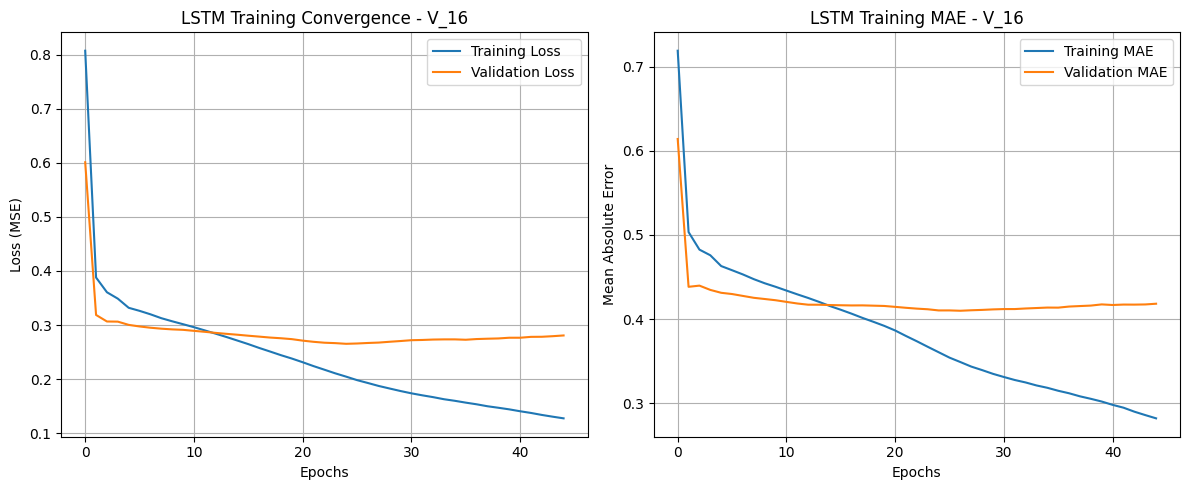


Performing sensitivity analysis on LSTM architecture...
Training with Small architecture: LSTM [32], Dense [16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Training with Medium architecture: LSTM [64], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Training with Deep architecture: LSTM [32, 32], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
Training with Large architecture: LSTM [128], Dense [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


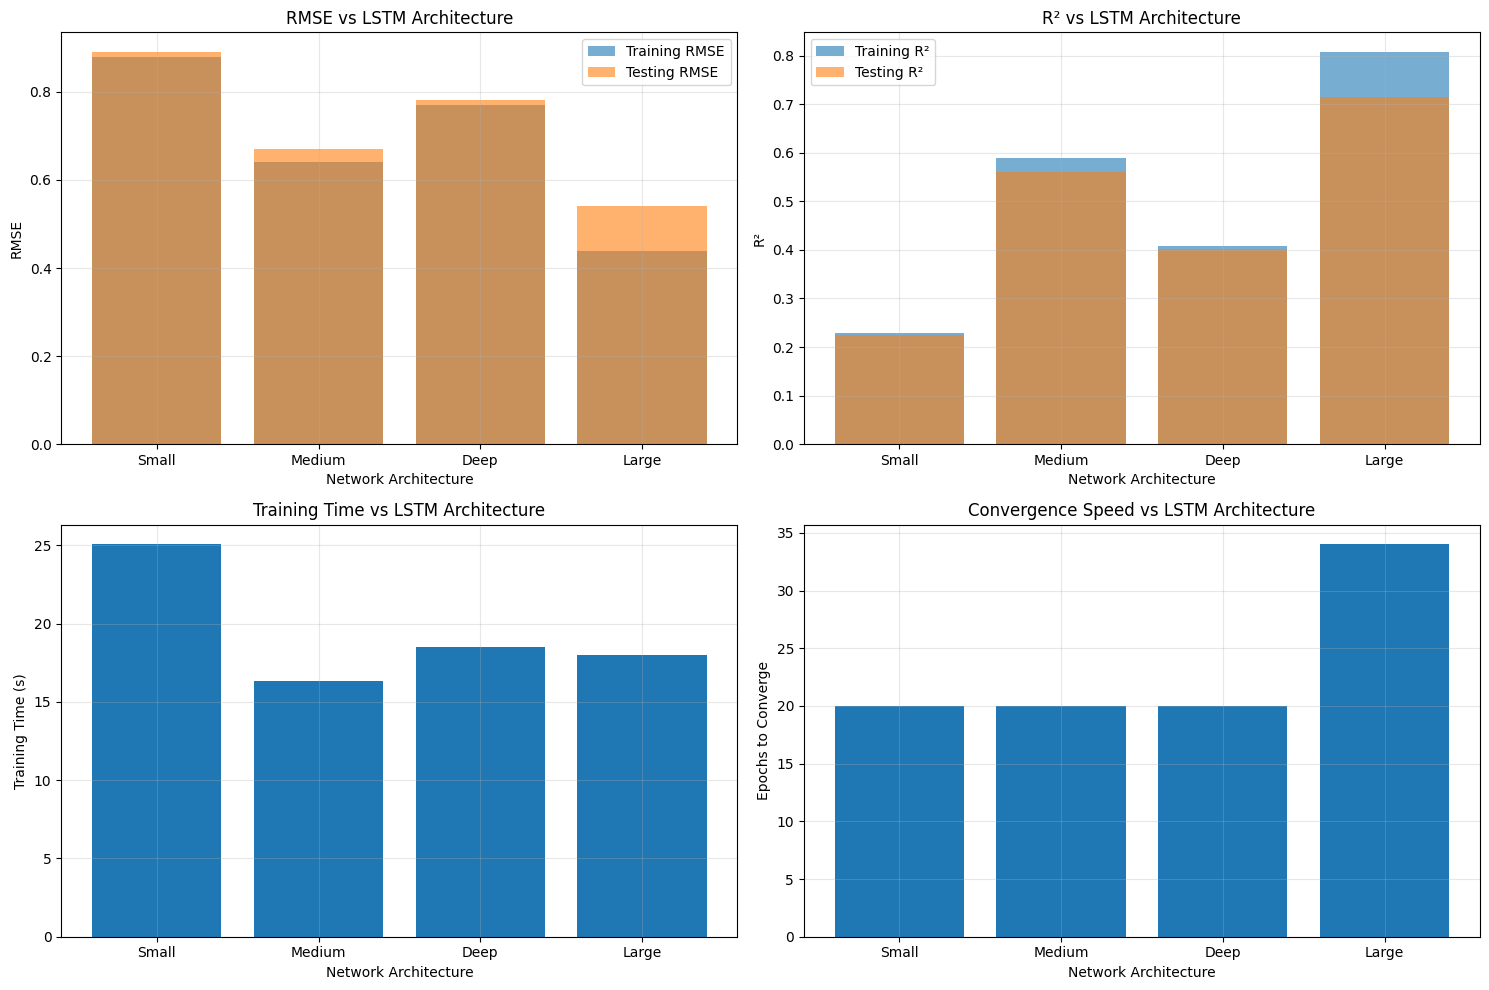


Performing window size sensitivity analysis for V_16...
Testing window size 2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Testing window size 4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Testing window size 8...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Testing window size 16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Best window size: 16, giving 4 timesteps with 16 features per step


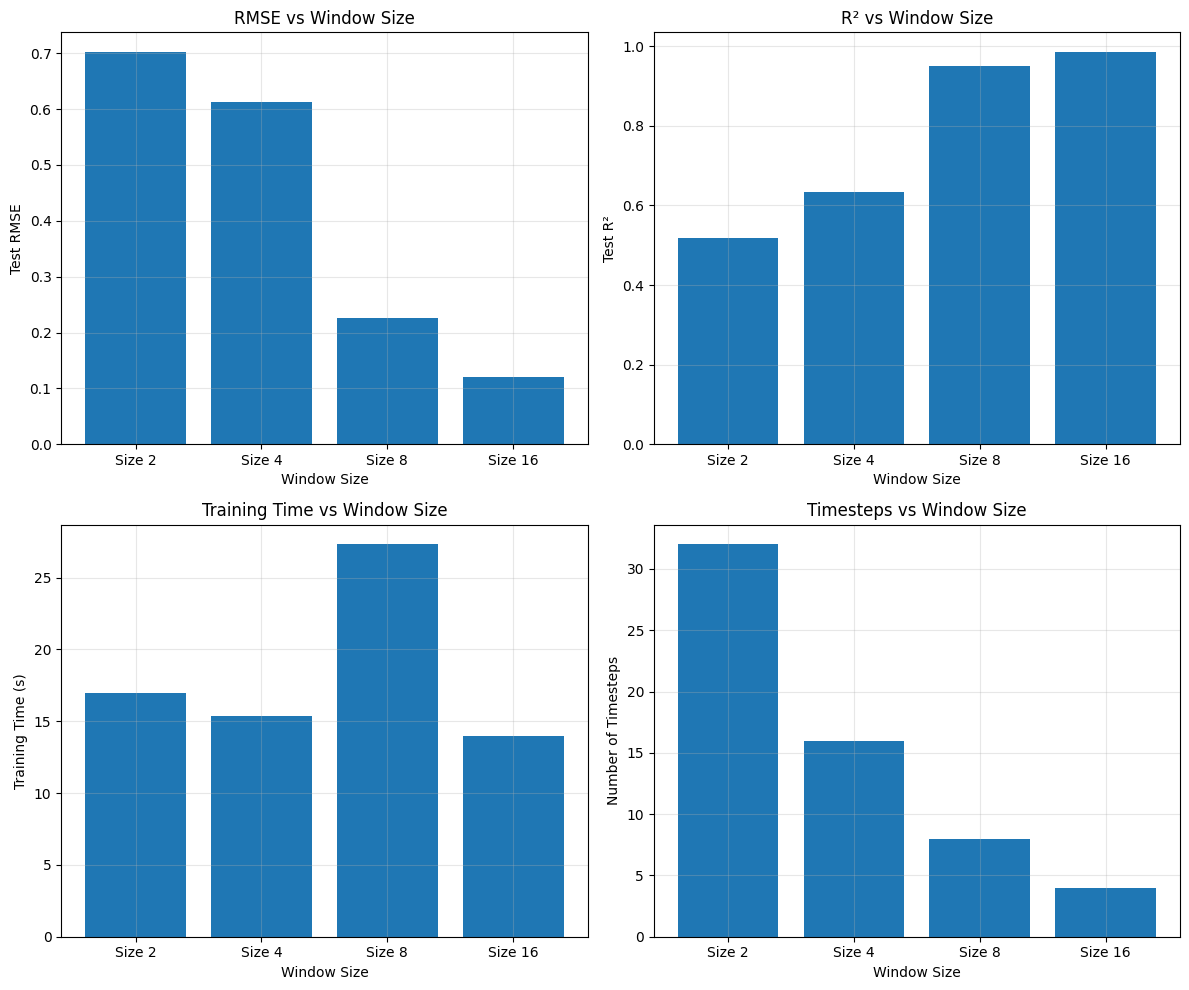


Performing learning rate and dropout tuning for V_16...
Training with learning rate=0.001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Training with learning rate=0.001, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Training with learning rate=0.001, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Training with learning rate=0.01, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Training with learning rate=0.01, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Training with learning rate=0.01, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Training with learning rate=0.0001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Training with lear

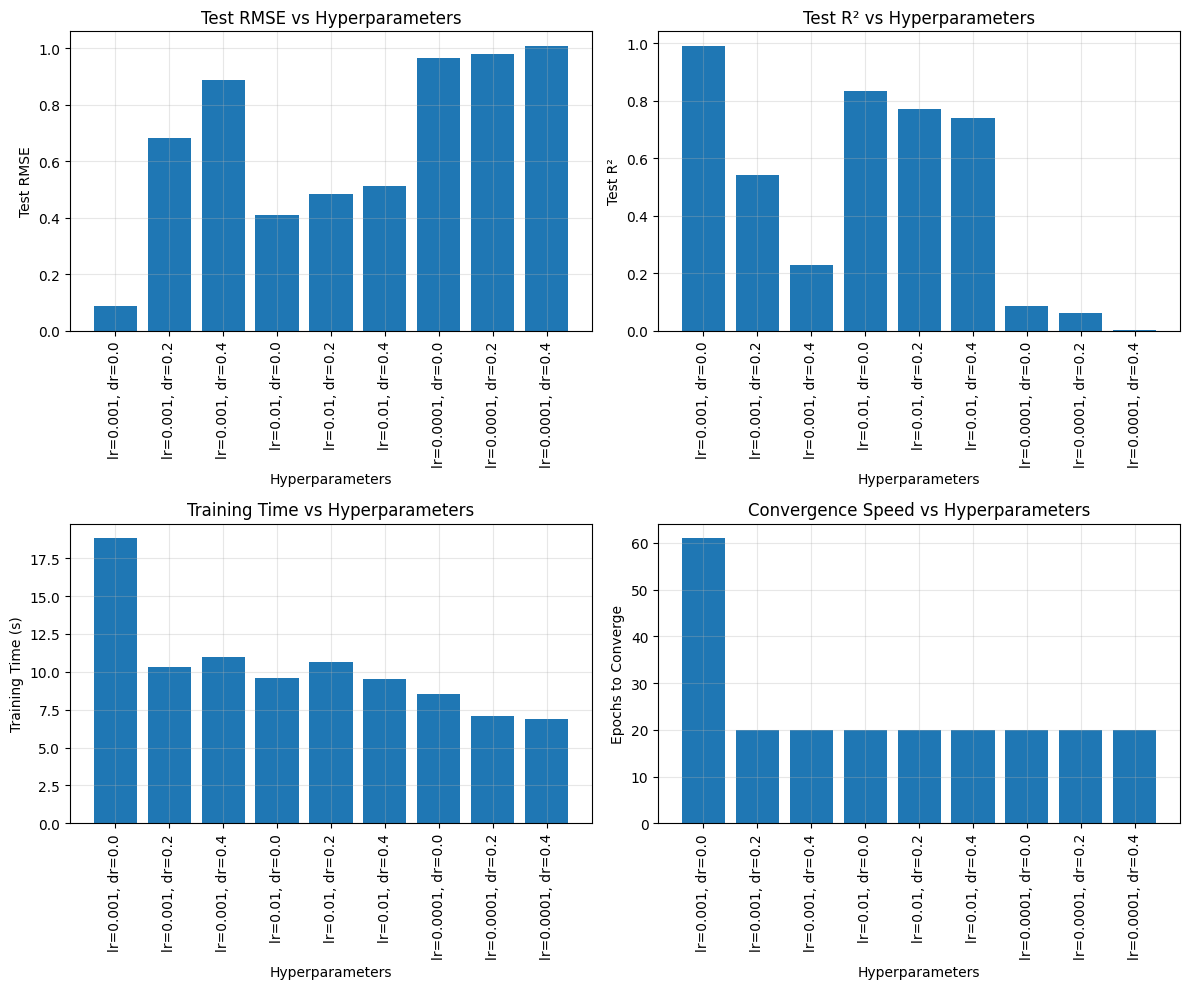


Training final LSTM model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.8169 - mae: 0.7268 - val_loss: 0.5406 - val_mae: 0.5701
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2261 - mae: 0.3635 - val_loss: 0.1611 - val_mae: 0.3226
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1179 - mae: 0.2775 - val_loss: 0.1223 - val_mae: 0.2923
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0727 - mae: 0.2151 - val_loss: 0.0925 - val_mae: 0.2532
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0453 - mae: 0.1700 - val_loss: 0.0633 - val_mae: 0.2075
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0272 - mae: 0.1318 - val_loss: 0.0420 - val_mae: 0.1679
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0145 - mae: 0.0952 - val_loss: 0.0273 - val_mae: 0.1334
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0077 - mae: 0.0695 - val_loss: 0.0194 - val_mae: 0.1115
Epoch

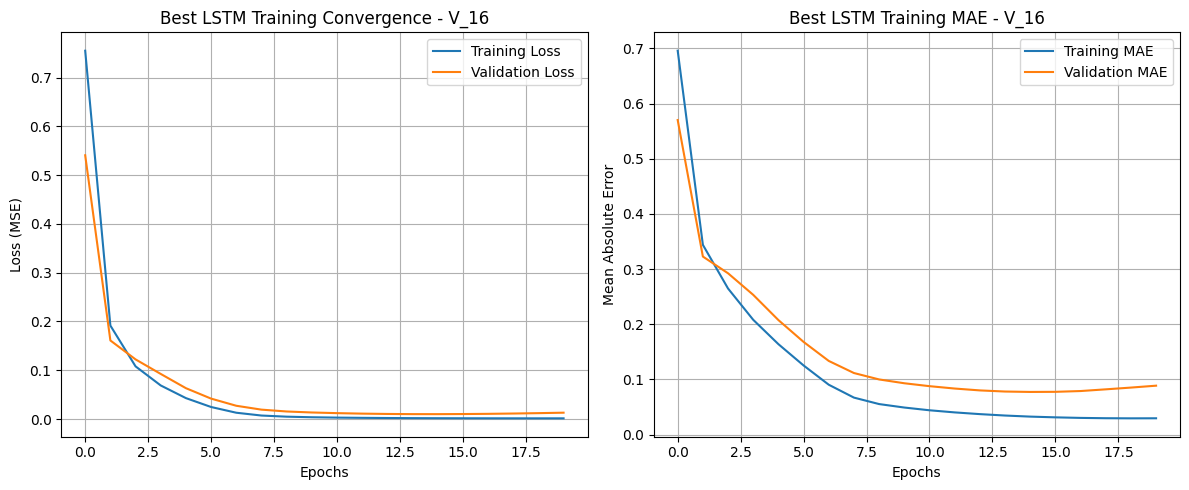


Analyzing feature importance using permutation method...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

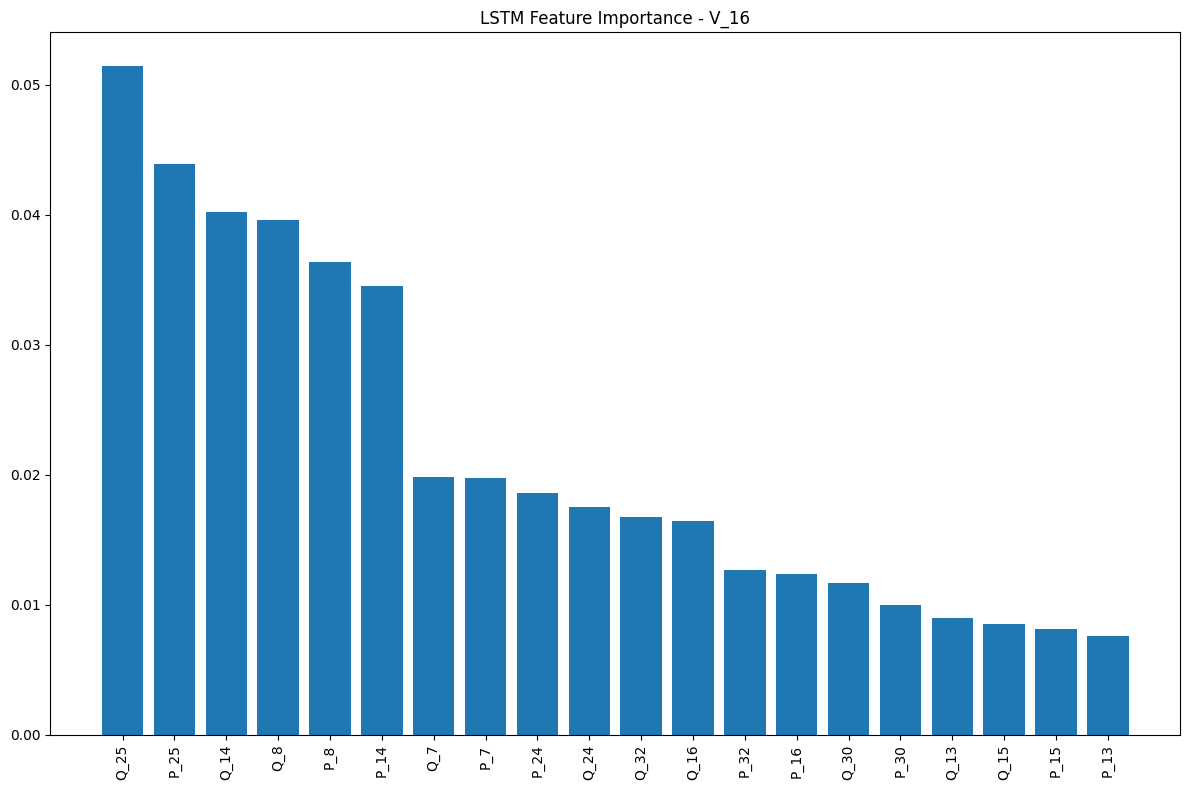

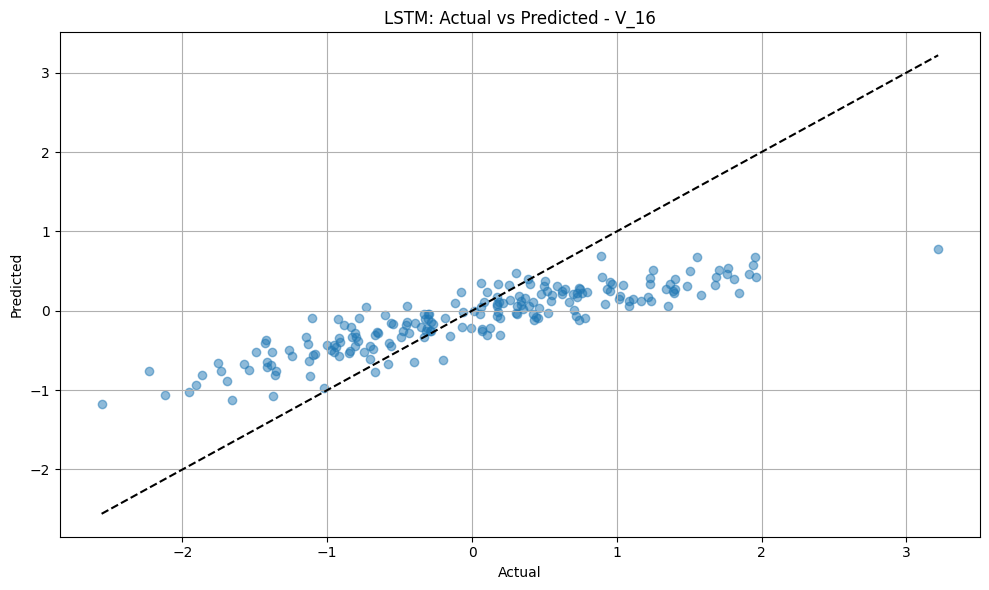


LSTM Model Summary:


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_85 (LSTM)                  │ (None, 128)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,829 (991.52 KB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,220 (661.02 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

LSTM model training and analysis complete for V_16


In [78]:
print("\n1. Training LSTM for single voltage prediction (V_16)...")
lstm_v16_results = train_lstm_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


2. Training LSTM for loss prediction...

Training base LSTM model for loss...
Reshaped data: (800, 16, 4) [samples, timesteps, features_per_step]
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.8397 - mae: 0.7301 - val_loss: 0.5445 - val_mae: 0.5880
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3992 - mae: 0.5047 - val_loss: 0.3186 - val_mae: 0.4518
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3513 - mae: 0.4851 - val_loss: 0.2976 - val_mae: 0.4438
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3407 - mae: 0.4767 - val_loss: 0.2888 - val_mae: 0.4297
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3198 - mae: 0.4622 - val_loss: 0.2819 - val_mae: 0.4234
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3107 - mae: 0.4545 - val_loss: 0.2784 - val_mae: 0.4203
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3024 - mae: 0.4476 - val_loss: 0.2732 - val_mae: 0.4165
Epoch 8/200
20/20 ━━━━━━━━━━

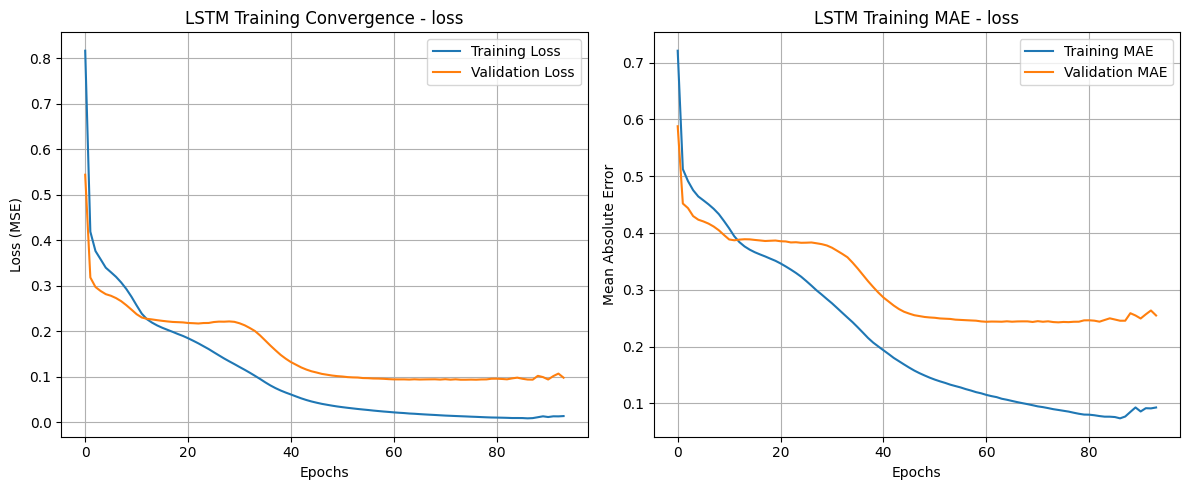


Performing sensitivity analysis on LSTM architecture...
Training with Small architecture: LSTM [32], Dense [16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Training with Medium architecture: LSTM [64], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Training with Deep architecture: LSTM [32, 32], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Training with Large architecture: LSTM [128], Dense [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


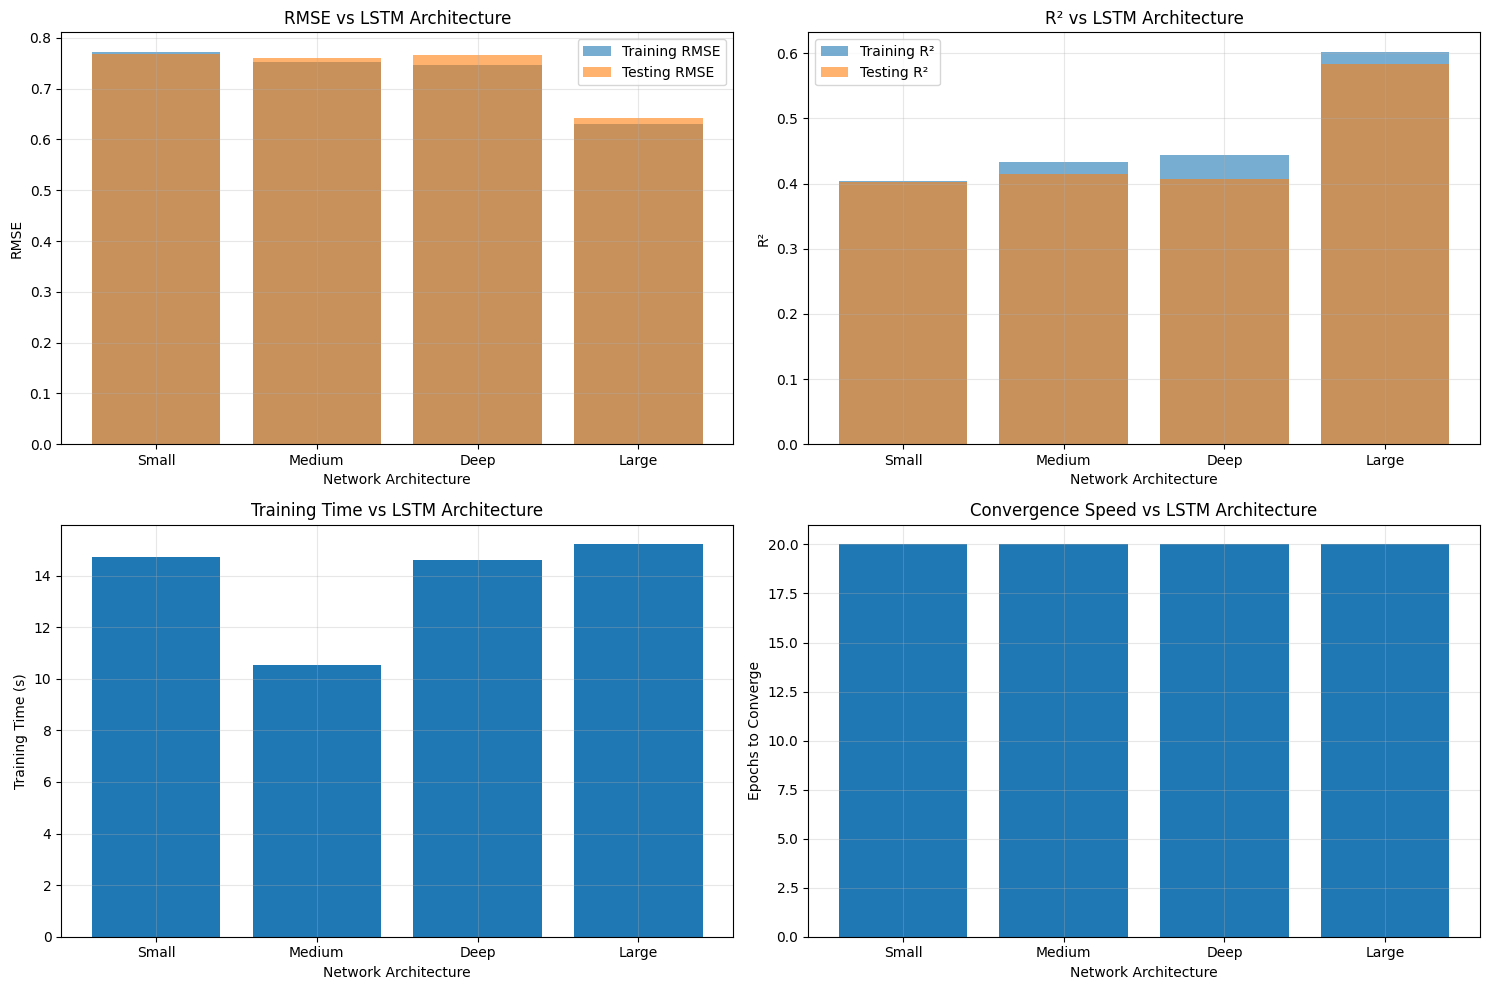


Performing window size sensitivity analysis for loss...
Testing window size 2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Testing window size 4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Testing window size 8...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Testing window size 16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Best window size: 16, giving 4 timesteps with 16 features per step


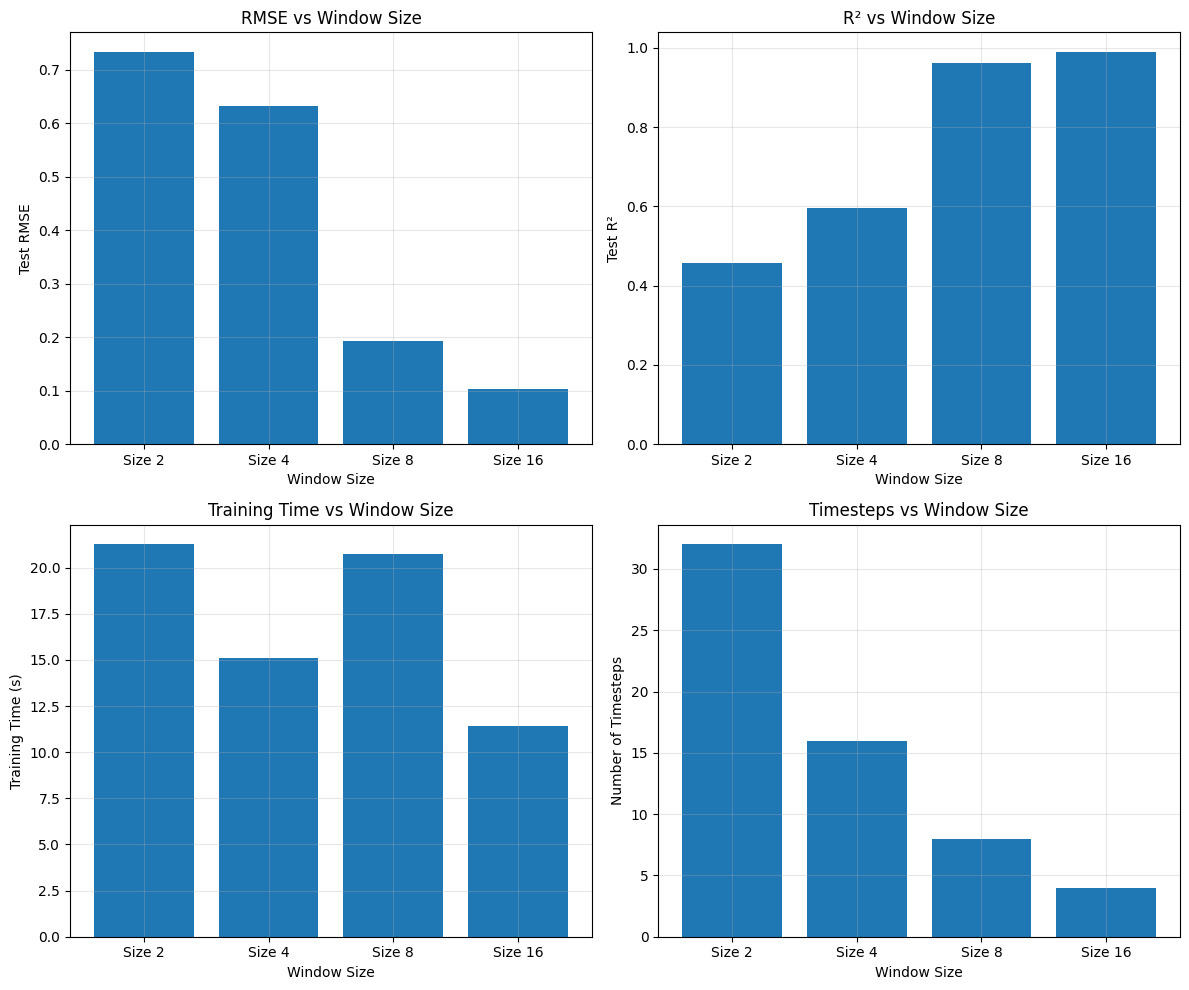


Performing learning rate and dropout tuning for loss...
Training with learning rate=0.001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Training with learning rate=0.001, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Training with learning rate=0.001, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Training with learning rate=0.01, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Training with learning rate=0.01, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Training with learning rate=0.01, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Training with learning rate=0.0001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Training with lear

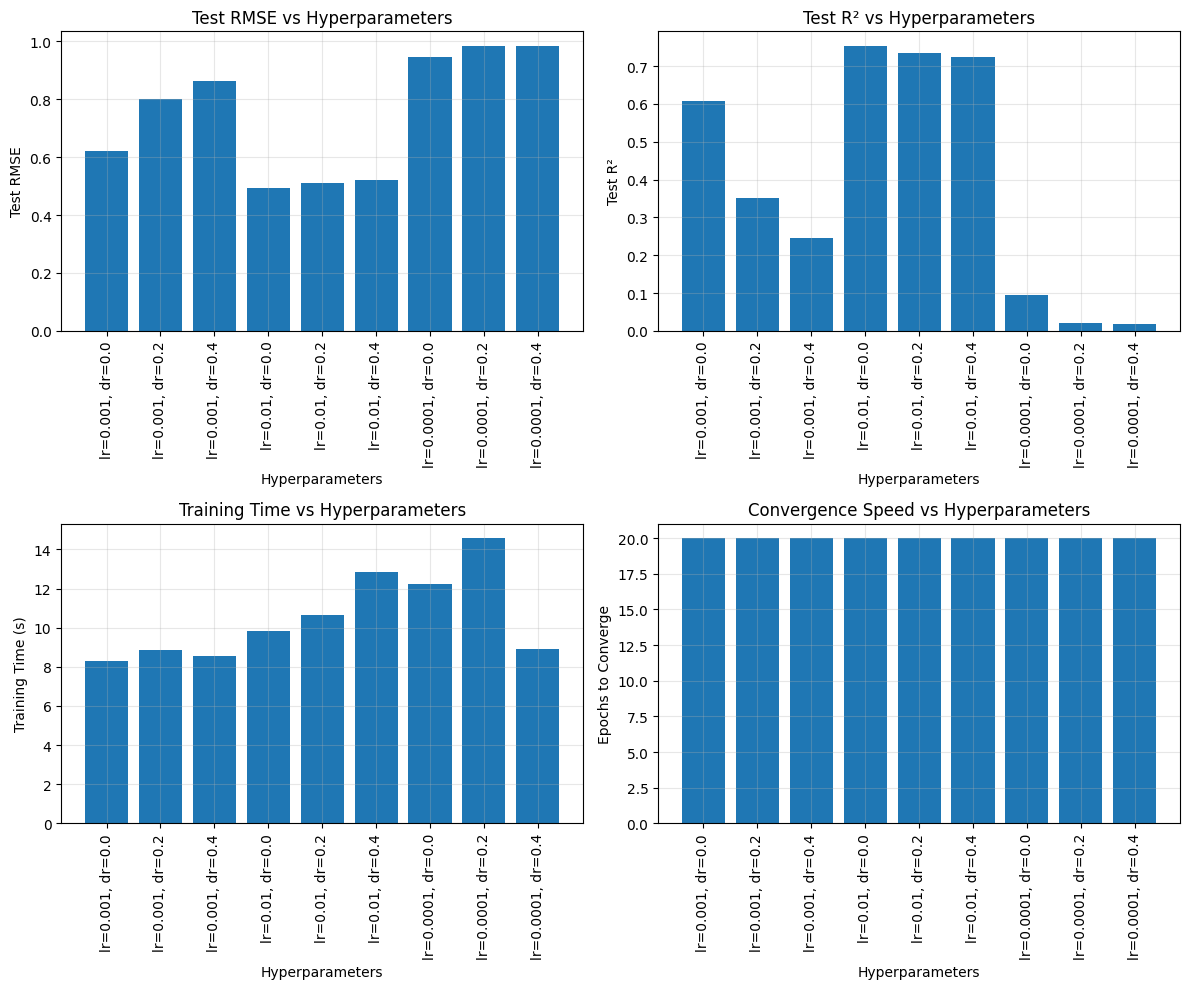


Training final LSTM model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.4412 - mae: 0.5262 - val_loss: 0.1397 - val_mae: 0.2925
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1086 - mae: 0.2604 - val_loss: 0.0566 - val_mae: 0.1822
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0316 - mae: 0.1430 - val_loss: 0.0278 - val_mae: 0.1318
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0172 - mae: 0.1052 - val_loss: 0.0294 - val_mae: 0.1391
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0228 - mae: 0.1188 - val_loss: 0.0488 - val_mae: 0.1865
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0334 - mae: 0.1454 - val_loss: 0.0304 - val_mae: 0.1316
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0500 - mae: 0.1666 - val_loss: 0.0960 - val_mae: 0.2617
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0659 - mae: 0.1993 - val_loss: 0.0505 - val_mae: 0.1619
Epoch

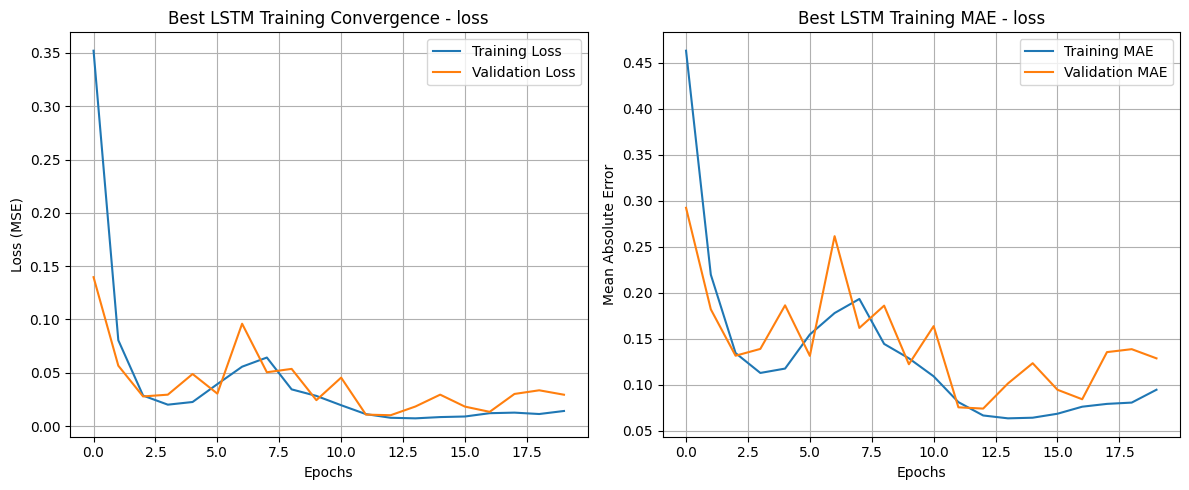


Analyzing feature importance using permutation method...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

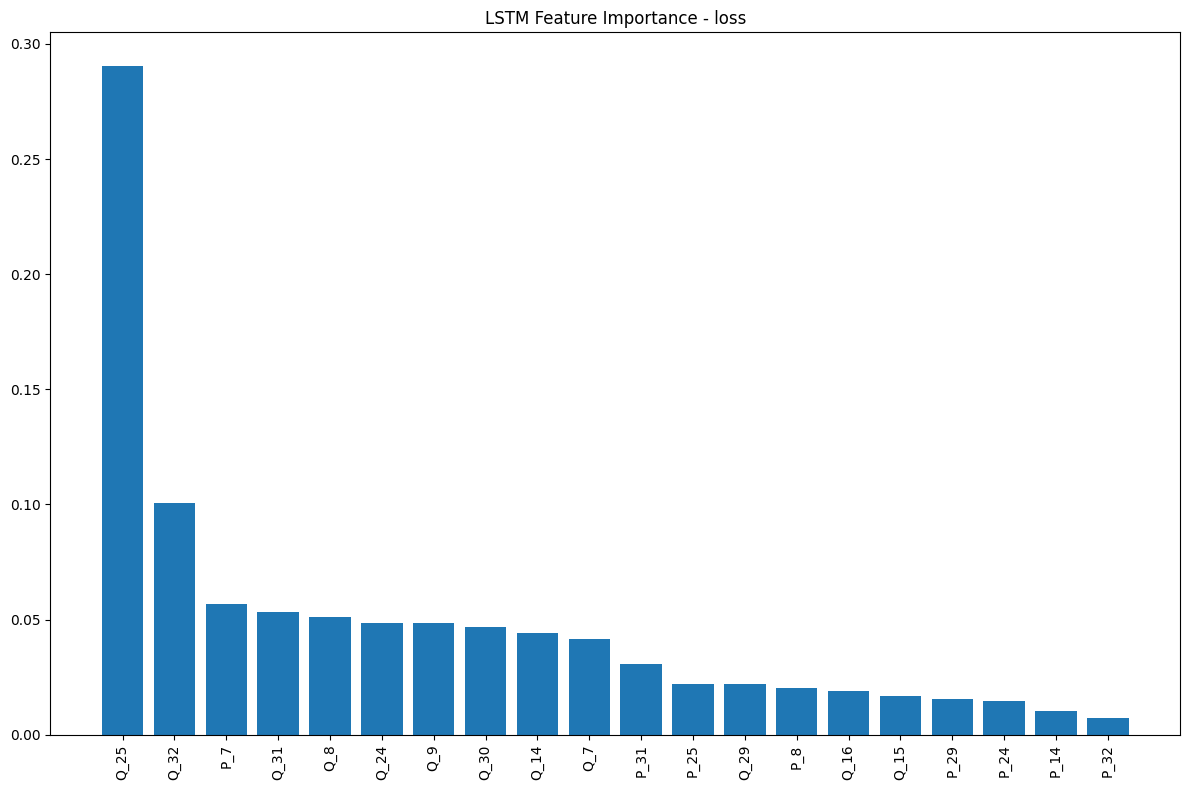

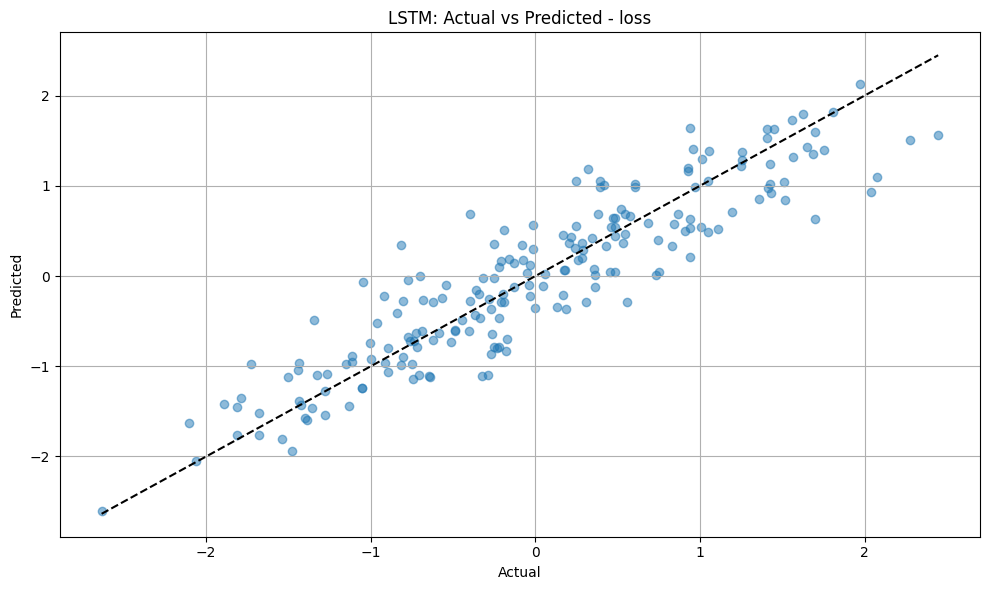


LSTM Model Summary:


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_105 (LSTM)                 │ (None, 128)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,829 (991.52 KB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,220 (661.02 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

LSTM model training and analysis complete for loss


In [79]:
print("\n2. Training LSTM for loss prediction...")
lstm_loss_results = train_lstm_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


3. Training LSTM for all voltages prediction...

Training base LSTM model for all_voltages...
Reshaped data: (800, 16, 4) [samples, timesteps, features_per_step]
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.9089 - mae: 0.7594 - val_loss: 0.9410 - val_mae: 0.7614
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7034 - mae: 0.6633 - val_loss: 0.6651 - val_mae: 0.6287
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5166 - mae: 0.5717 - val_loss: 0.4636 - val_mae: 0.5291
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4119 - mae: 0.5161 - val_loss: 0.3686 - val_mae: 0.4760
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3631 - mae: 0.4866 - val_loss: 0.3334 - val_mae: 0.4525
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3454 - mae: 0.4749 - val_loss: 0.3209 - val_mae: 0.4460
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3413 - mae: 0.4726 - val_loss: 0.3166 - val_mae: 0.4465
Epoch 8/200


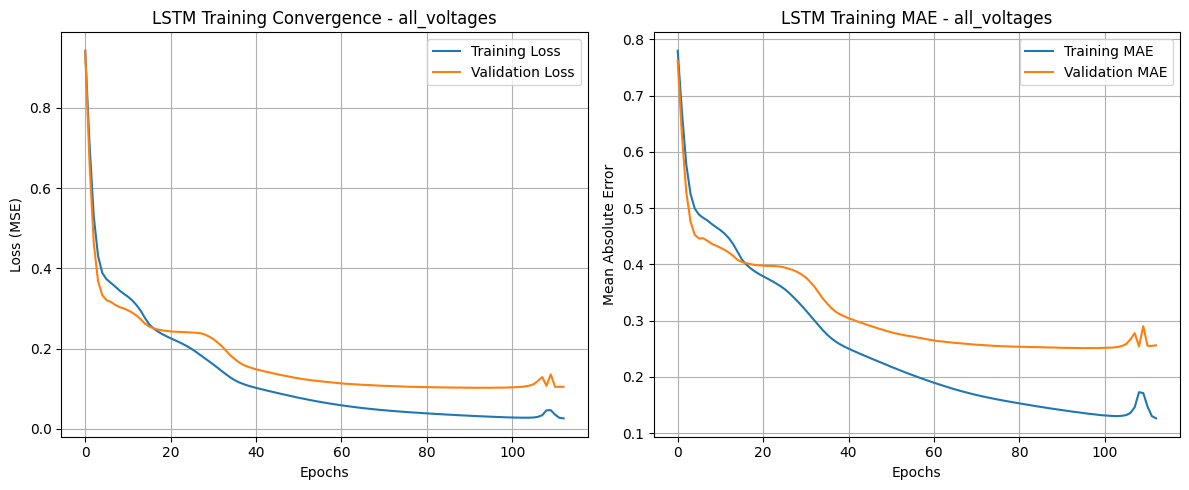


Performing sensitivity analysis on LSTM architecture...
Training with Small architecture: LSTM [32], Dense [16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Training with Medium architecture: LSTM [64], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Training with Deep architecture: LSTM [32, 32], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
Training with Large architecture: LSTM [128], Dense [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


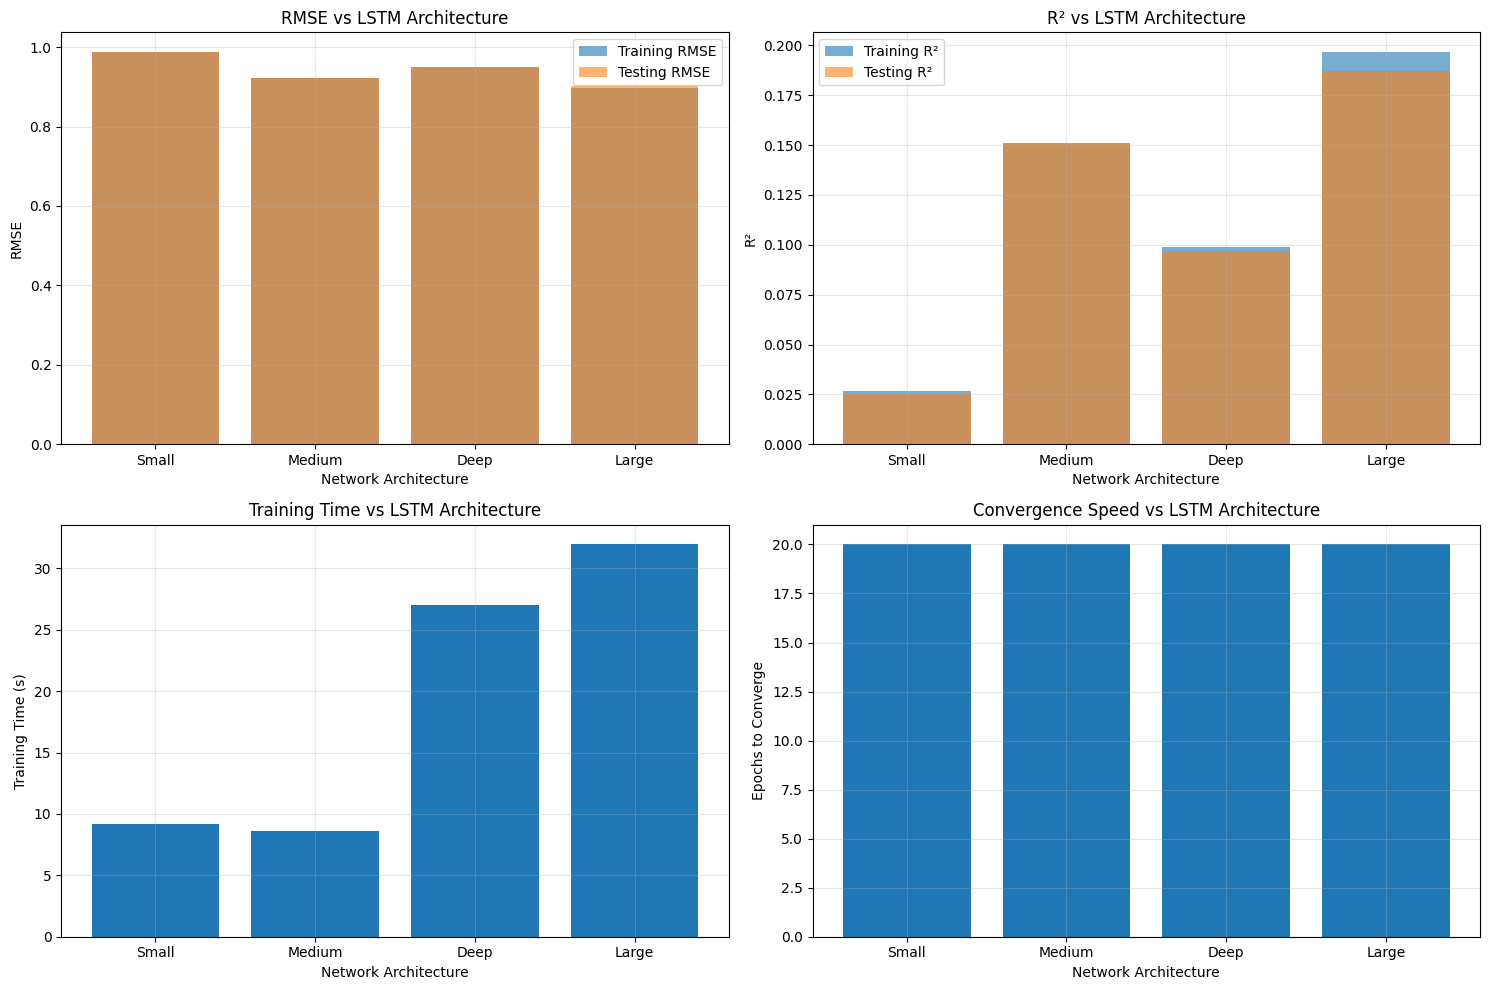


Performing window size sensitivity analysis for all_voltages...
Testing window size 2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Testing window size 4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Testing window size 8...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Testing window size 16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Best window size: 8, giving 8 timesteps with 8 features per step


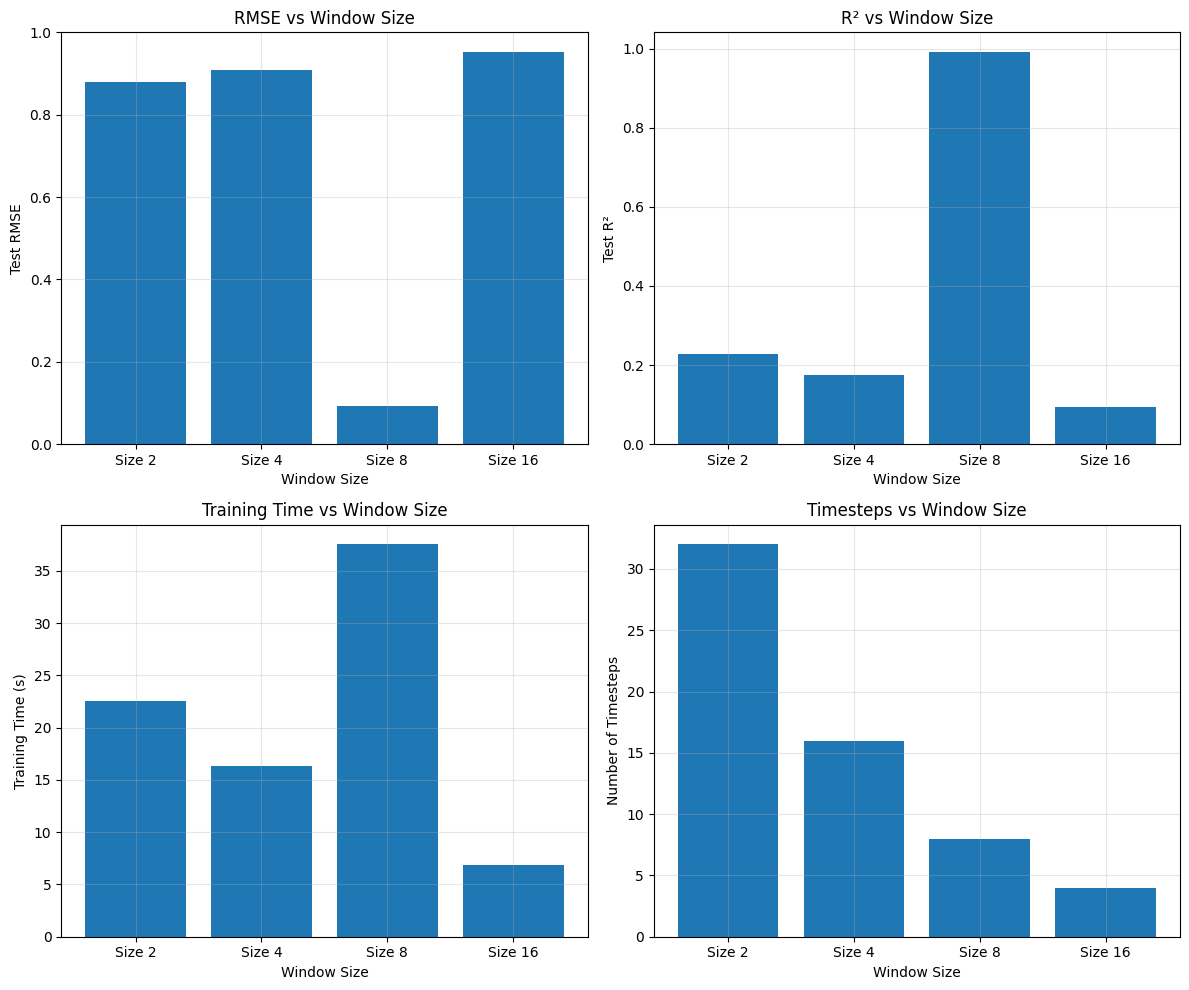


Performing learning rate and dropout tuning for all_voltages...
Training with learning rate=0.001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Training with learning rate=0.001, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Training with learning rate=0.001, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Training with learning rate=0.01, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with learning rate=0.01, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Training with learning rate=0.01, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Training with learning rate=0.0001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Training wit

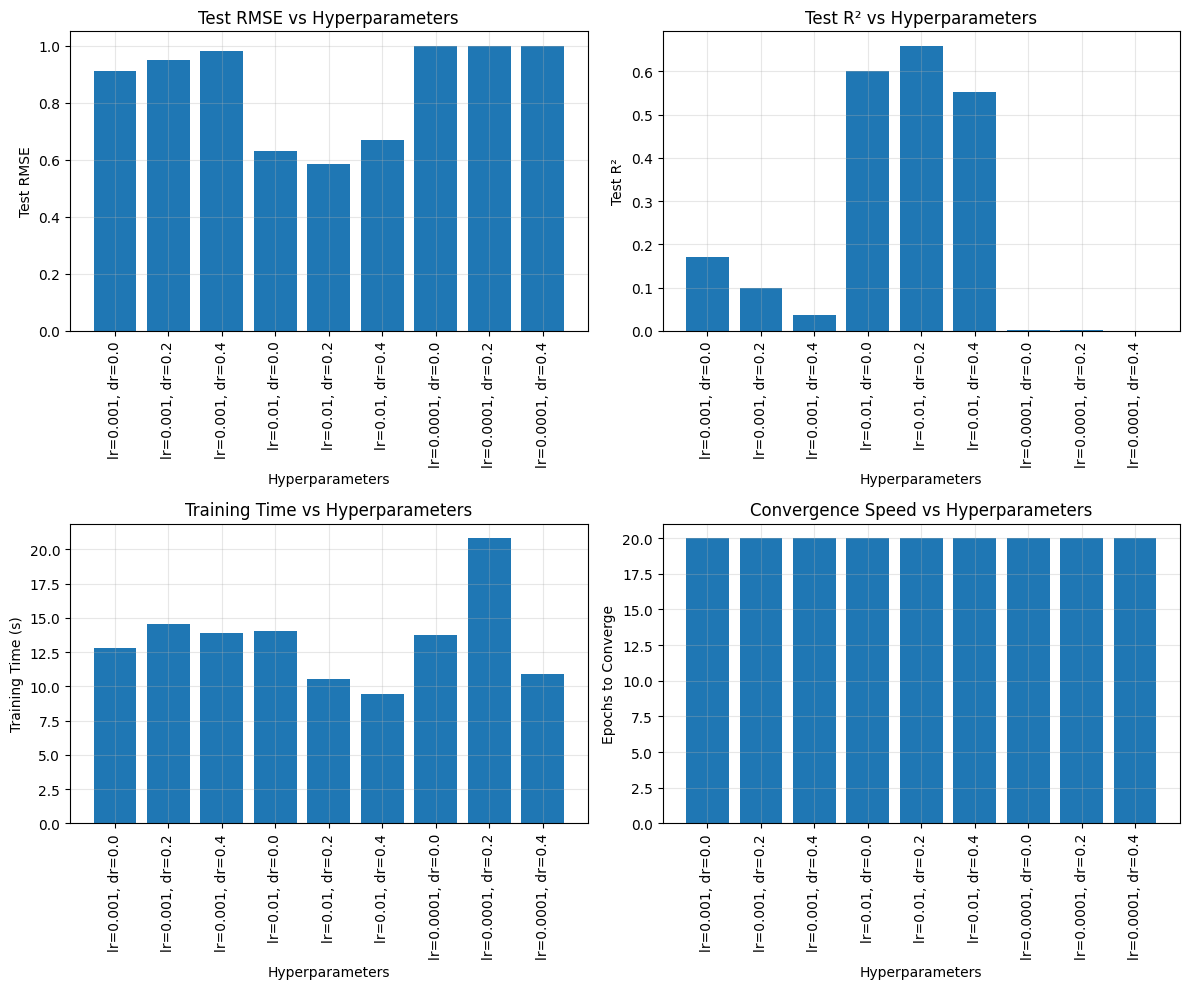


Training final LSTM model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.7341 - mae: 0.6741 - val_loss: 0.3392 - val_mae: 0.4585
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3820 - mae: 0.4908 - val_loss: 0.2744 - val_mae: 0.4069
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3000 - mae: 0.4368 - val_loss: 0.1786 - val_mae: 0.3249
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2110 - mae: 0.3610 - val_loss: 0.1605 - val_mae: 0.3204
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1833 - mae: 0.3392 - val_loss: 0.1473 - val_mae: 0.3004
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1955 - mae: 0.3461 - val_loss: 0.2010 - val_mae: 0.3568
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2008 - mae: 0.3514 - val_loss: 0.2820 - val_mae: 0.3921
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1531 - mae: 0.3001 - val_loss: 0.1210 - val_mae: 0.2719
Epoch

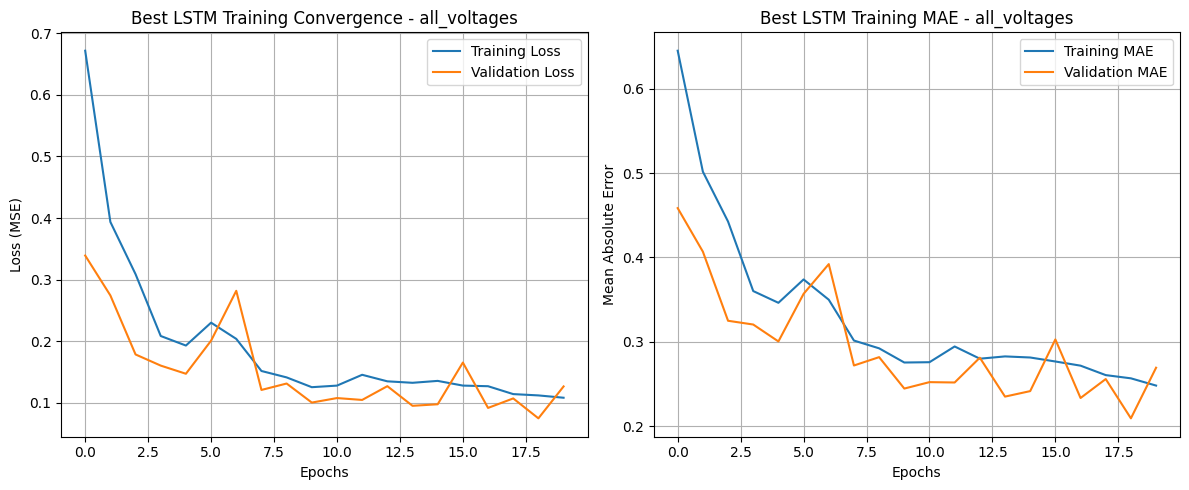

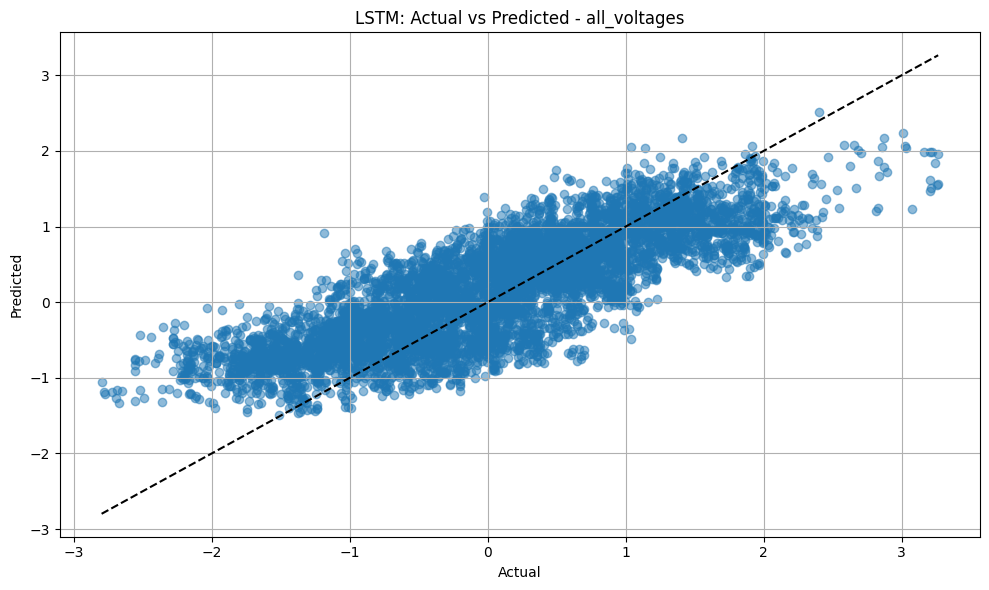


LSTM Model Summary:


Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_125 (LSTM)                 │ (None, 128)            │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_614 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_615 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_616 (Dense)               │ (None, 34)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,808 (956.29 KB)

 Trainable params: 81,602 (318.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,206 (637.53 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

LSTM model training and analysis complete for all_voltages


In [80]:
print("\n3. Training LSTM for all voltages prediction...")
lstm_all_v_results = train_lstm_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [ ]:
print("\nSaving trained LSTM models...")

lstm_v16_results['best_model']['model'].save('models/lstm/lstm_v16_best_model.keras')
lstm_loss_results['best_model']['model'].save('models/lstm/lstm_loss_best_model.keras')
lstm_all_v_results['best_model']['model'].save('models/lstm/lstm_all_v_best_model.keras')

with open('models/lstm/lstm_v16_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': lstm_v16_results['best_model']['scaler'],
        'reshape_info': lstm_v16_results['best_model']['reshape_info'],
        'params': lstm_v16_results['best_model']['params']
    }, f)

with open('models/lstm/lstm_loss_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': lstm_loss_results['best_model']['scaler'],
        'reshape_info': lstm_loss_results['best_model']['reshape_info'],
        'params': lstm_loss_results['best_model']['params']
    }, f)

with open('models/lstm/lstm_all_v_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': lstm_all_v_results['best_model']['scaler'],
        'reshape_info': lstm_all_v_results['best_model']['reshape_info'],
        'params': lstm_all_v_results['best_model']['params']
    }, f)

print("LSTM models saved successfully!")


Saving trained LSTM models...
LSTM models saved successfully!


In [88]:
print("\n=== LSTM Models Summary ===")
print(f"V_16 Prediction - Test R²: {lstm_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {lstm_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {lstm_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {lstm_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {lstm_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {lstm_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")


=== LSTM Models Summary ===
V_16 Prediction - Test R²: 0.5399, RMSE: 0.6858
Loss Prediction - Test R²: 0.8273, RMSE: 0.4130
All Voltages Prediction - Test R²: 0.6356, RMSE: 0.6040


In [87]:
def predict_with_lstm(model_name, X_new):
    """
    Make predictions using a saved LSTM model
    
    Parameters:
    model_name (str): Name of the model ('v16', 'loss', or 'all_voltages')
    X_new (np.array): New input data to make predictions on
    
    Returns:
    np.array: Predictions
    """
    # Load model and parameters
    model = tf.keras.models.load_model(f'models/lstm/lstm_{model_name}_best_model')
    
    with open(f'models/lstm/lstm_{model_name}_params.pkl', 'rb') as f:
        params = pickle.load(f)
    
    scaler = params['scaler']
    reshape_info = params['reshape_info']
    
    X_scaled = scaler.transform(X_new)
    
    window_size = reshape_info['window_size']
    n_samples = X_scaled.shape[0]
    n_features = X_scaled.shape[1]
    
    padding = 0
    if n_features % window_size != 0:
        padding = window_size - (n_features % window_size)
        padded_X = np.pad(X_scaled, ((0, 0), (0, padding)), 'constant')
        n_features = padded_X.shape[1]
    else:
        padded_X = X_scaled
        
    n_timesteps = n_features // window_size
    X_seq = padded_X.reshape(n_samples, n_timesteps, window_size)
    
    predictions = model.predict(X_seq)
    
    return predictions

### Convolutional Neural Network (CNN)

In [ ]:
def train_cnn_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    train_losses = []
    val_losses = []
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape for 1D convolution (samples, features, 1)
    X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    
    # Output dimension determination
    output_dim = 1 if len(y_train.shape) == 1 or y_train.shape[1] == 1 else y_train.shape[1]
    
    print(f"\nTraining base CNN model for {target_name}...")
    print(f"Input shape: {X_train_cnn.shape}, Output shape: {output_dim}")
    
    # 1. Base model for quick evaluation
    base_model = tf.keras.Sequential([
        # 1D Convolution layers
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', 
                               input_shape=(X_train_cnn.shape[1], 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        # Global pooling to aggregate spatial information
        tf.keras.layers.GlobalAveragePooling1D(),
        
        # Dense layers for final prediction
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim)
    ])
    
    base_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping for better convergence
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    # Track loss history
    class LossHistory(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            train_losses.append(logs.get('loss'))
            val_losses.append(logs.get('val_loss'))
    
    history_callback = LossHistory()
    
    # Train the base model
    base_history = base_model.fit(
        X_train_cnn, y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, history_callback],
        verbose=1
    )
    
    # Evaluate performance
    y_train_pred = base_model.predict(X_train_cnn)
    y_test_pred = base_model.predict(X_test_cnn)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base CNN Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base CNN Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': base_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred,
        'history': base_history.history
    }
    
    # Plot training convergence
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(base_history.history['loss'], label='Training Loss')
    plt.plot(base_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'CNN Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(base_history.history['mae'], label='Training MAE')
    plt.plot(base_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'CNN Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/cnn/{target_name}_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. CNN Architecture Sensitivity Analysis
    print(f"\nPerforming architecture sensitivity analysis for CNN...")
    
    architectures = [
        {
            'name': 'Single Conv Layer',
            'model_builder': lambda: tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', 
                                      input_shape=(X_train_cnn.shape[1], 1)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(output_dim)
            ])
        },
        {
            'name': 'Double Conv Layer',
            'model_builder': lambda: tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', 
                                      input_shape=(X_train_cnn.shape[1], 1)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(output_dim)
            ])
        },
        {
            'name': 'Deep Conv Network',
            'model_builder': lambda: tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', 
                                      input_shape=(X_train_cnn.shape[1], 1)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(output_dim)
            ])
        },
        {
            'name': 'Multi-Scale Conv',
            'model_builder': lambda: build_multi_scale_model(X_train_cnn.shape[1], output_dim)
        }
    ]
    
    def build_multi_scale_model(input_features, output_dim):
        # multi-scale CNN using the Functional API
        inputs = tf.keras.layers.Input(shape=(input_features, 1))
        
        # Parallel convolutions with different kernel sizes
        conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', padding='same')(inputs)
        conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
        conv5 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(inputs)
        
        # Concatenate parallel convolutions
        concat = tf.keras.layers.Concatenate()([conv1, conv3, conv5])
        batch_norm = tf.keras.layers.BatchNormalization()(concat)
        
        # Pooling and dense layers
        pool = tf.keras.layers.MaxPooling1D(pool_size=2)(batch_norm)
        global_pool = tf.keras.layers.GlobalAveragePooling1D()(pool)
        
        dense1 = tf.keras.layers.Dense(64, activation='relu')(global_pool)
        dense2 = tf.keras.layers.Dense(32, activation='relu')(dense1)
        outputs = tf.keras.layers.Dense(output_dim)(dense2)
        
        # Create the model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    architecture_results = []
    
    for arch in architectures:
        print(f"Training with {arch['name']} architecture...")
        start_time = time.time()
        
        # Build model using the lambda function
        model = arch['model_builder']()
        
        # Compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Train with early stopping
        history = model.fit(
            X_train_cnn, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate performance
        train_pred = model.predict(X_train_cnn)
        test_pred = model.predict(X_test_cnn)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        final_epochs = len(history.history['loss'])
        
        architecture_results.append({
            'name': arch['name'],
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time,
            'epochs': final_epochs
        })
    
    # Plot architecture sensitivity results
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs architecture
    plt.subplot(2, 2, 1)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_rmse'] for r in architecture_results], 
            alpha=0.6, label='Training RMSE')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_rmse'] for r in architecture_results], 
            alpha=0.6, label='Testing RMSE')
    plt.xlabel('Network Architecture')
    plt.ylabel('RMSE')
    plt.title('RMSE vs CNN Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot R² vs architecture
    plt.subplot(2, 2, 2)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_r2'] for r in architecture_results], 
            alpha=0.6, label='Training R²')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_r2'] for r in architecture_results], 
            alpha=0.6, label='Testing R²')
    plt.xlabel('Network Architecture')
    plt.ylabel('R²')
    plt.title('R² vs CNN Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training time vs architecture
    plt.subplot(2, 2, 3)
    plt.bar([r['name'] for r in architecture_results], 
             [r['training_time'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs CNN Architecture')
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar([r['name'] for r in architecture_results], 
             [r['epochs'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs CNN Architecture')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/cnn/{target_name}_architecture_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['architecture_sensitivity'] = architecture_results
    
    # 3. Kernel Size and Filter Count Sensitivity Analysis
    print(f"\nPerforming kernel size and filter count analysis for {target_name}...")
    
    # Find best architecture from previous analysis
    best_arch_idx = np.argmin([r['test_rmse'] for r in architecture_results])
    best_arch_name = architecture_results[best_arch_idx]['name']
    
    print(f"Best architecture: {best_arch_name}")
    
    # Define ranges for kernel sizes and filter counts
    kernel_sizes = [1, 3, 5, 7]
    filter_counts = [16, 32, 64, 128]
    
    kernel_filter_results = []
    
    # Function to create a model with specified kernel size and filter count for each architecture
    def create_model_with_params(arch_name, kernel_size, filter_count, input_shape, output_dim):
        if arch_name == 'Single Conv Layer':
            model = tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=filter_count, kernel_size=kernel_size, activation='relu', 
                                     padding='same', input_shape=input_shape),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(output_dim)
            ])
        elif arch_name == 'Double Conv Layer':
            model = tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=filter_count, kernel_size=kernel_size, activation='relu', 
                                     padding='same', input_shape=input_shape),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.Conv1D(filters=filter_count*2, kernel_size=kernel_size, activation='relu', 
                                      padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(output_dim)
            ])
        elif arch_name == 'Deep Conv Network':
            model = tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=filter_count, kernel_size=kernel_size, activation='relu', 
                                     padding='same', input_shape=input_shape),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(filters=filter_count*2, kernel_size=kernel_size, activation='relu', 
                                      padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(filters=filter_count*4, kernel_size=kernel_size, activation='relu', 
                                      padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(output_dim)
            ])
        elif arch_name == 'Multi-Scale Conv':
            # For Multi-Scale Conv, we'll use the specified kernel size for all branches
            inputs = tf.keras.layers.Input(shape=input_shape)
            
            # All branches use the same kernel size in this parametric study
            conv = tf.keras.layers.Conv1D(filters=filter_count, kernel_size=kernel_size, 
                                        activation='relu', padding='same')(inputs)
            batch_norm = tf.keras.layers.BatchNormalization()(conv)
            
            pool = tf.keras.layers.MaxPooling1D(pool_size=2)(batch_norm)
            global_pool = tf.keras.layers.GlobalAveragePooling1D()(pool)
            
            dense1 = tf.keras.layers.Dense(64, activation='relu')(global_pool)
            dense2 = tf.keras.layers.Dense(32, activation='relu')(dense1)
            outputs = tf.keras.layers.Dense(output_dim)(dense2)
            
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        return model
    
    for kernel_size in kernel_sizes:
        for filter_count in filter_counts:
            print(f"Training with kernel_size={kernel_size}, filters={filter_count}...")
            start_time = time.time()
            
            # Create model with specified parameters
            model = create_model_with_params(
                best_arch_name, 
                kernel_size, 
                filter_count, 
                (X_train_cnn.shape[1], 1), 
                output_dim
            )
            
            # Compile and train
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            
            history = model.fit(
                X_train_cnn, y_train,
                epochs=200,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            train_pred = model.predict(X_train_cnn)
            test_pred = model.predict(X_test_cnn)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            training_time = time.time() - start_time
            final_epochs = len(history.history['loss'])
            
            kernel_filter_results.append({
                'kernel_size': kernel_size,
                'filters': filter_count,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'training_time': training_time,
                'epochs': final_epochs
            })
    
    # Find best kernel and filter configuration
    best_kf_idx = np.argmin([r['test_rmse'] for r in kernel_filter_results])
    best_kernel = kernel_filter_results[best_kf_idx]['kernel_size']
    best_filters = kernel_filter_results[best_kf_idx]['filters']
    
    print(f"Best kernel size: {best_kernel}, best filter count: {best_filters}")
    
    # Create heatmap of test RMSE values
    plt.figure(figsize=(10, 8))
    
    # Prepare data for heatmap
    heatmap_data = np.zeros((len(kernel_sizes), len(filter_counts)))
    for r in kernel_filter_results:
        i = kernel_sizes.index(r['kernel_size'])
        j = filter_counts.index(r['filters'])
        heatmap_data[i, j] = r['test_rmse']
    
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", 
                xticklabels=filter_counts, yticklabels=kernel_sizes,
                cmap="viridis_r")  # Using reverse viridis so darker is better (lower RMSE)
    plt.xlabel('Number of Filters')
    plt.ylabel('Kernel Size')
    plt.title(f'CNN Test RMSE by Kernel Size and Filter Count - {target_name}')
    plt.tight_layout()
    plt.savefig(f'figures/cnn/{target_name}_kernel_filter_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['kernel_filter_tuning'] = kernel_filter_results
    
    # 4. Train best CNN model with optimal settings
    print(f"\nTraining final CNN model with best parameters...")
    
    # Build the best model with optimal parameters
    best_model = create_model_with_params(
        best_arch_name, 
        best_kernel, 
        best_filters, 
        (X_train_cnn.shape[1], 1), 
        output_dim
    )
    
    # Setup tensorboard callback
    tensorboard_dir = f"logs/cnn_{target_name}_{int(time.time())}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        histogram_freq=1
    )
    
    # Compile and train the best model
    best_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    best_history = best_model.fit(
        X_train_cnn, y_train,
        epochs=300,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )
    
    best_train_pred = best_model.predict(X_train_cnn)
    best_test_pred = best_model.predict(X_test_cnn)
    
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best CNN Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best CNN Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    results['best_model'] = {
        'model': best_model,
        'scaler': scaler,
        'params': {
            'architecture': best_arch_name,
            'kernel_size': best_kernel,
            'filters': best_filters
        },
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred,
        'history': best_history.history
    }
    
    # Plot final model training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Best CNN Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['mae'], label='Training MAE')
    plt.plot(best_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Best CNN Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/cnn/{target_name}_best_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Plot actual vs predicted values for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'CNN: Actual vs Predicted - {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/cnn/{target_name}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Save results and metrics to CSV
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error'],
        'Base CNN Train': [results['base_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Base CNN Test': [results['base_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best CNN Train': [results['best_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best CNN Test': [results['best_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']]
    })
    
    results_df.to_csv(f'results/cnn_{target_name}_metrics.csv', index=False)
    
    return results


1. Training CNN for single voltage prediction (V_16)...

Training base CNN model for V_16...
Input shape: (800, 64, 1), Output shape: 1
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6704 - mae: 0.6502 - val_loss: 0.9236 - val_mae: 0.7619
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4562 - mae: 0.5430 - val_loss: 0.9996 - val_mae: 0.7944
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3805 - mae: 0.5000 - val_loss: 0.9825 - val_mae: 0.7895
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3746 - mae: 0.4884 - val_loss: 0.9769 - val_mae: 0.7881
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3832 - mae: 0.5052 - val_loss: 0.9553 - val_mae: 0.7818
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3704 - mae: 0.4902 - val_loss: 0.9219 - val_mae: 0.7708
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3760 - mae: 0.4950 - val_loss: 0.9132 - val_mae: 0.7675
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 

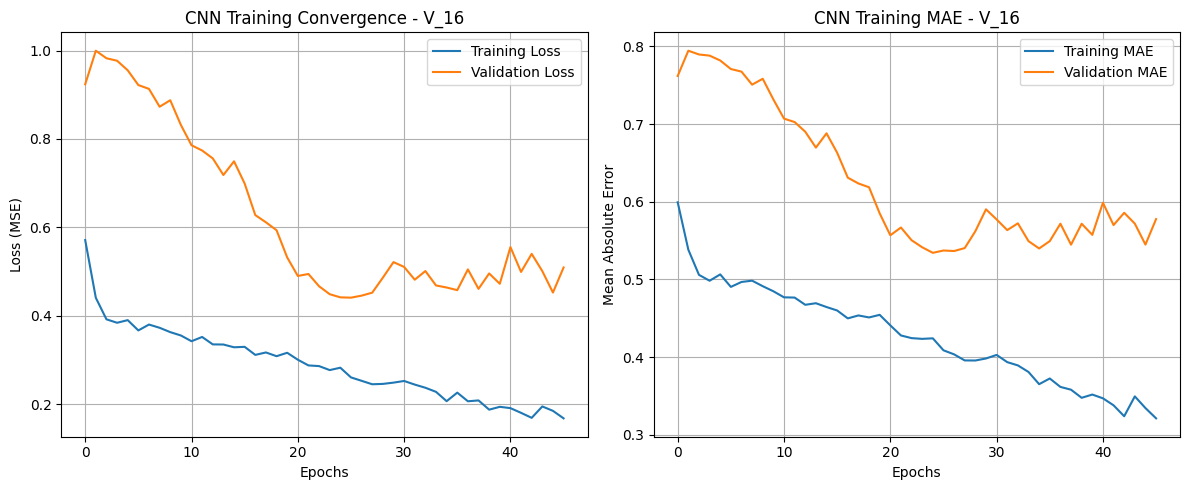


Performing architecture sensitivity analysis for CNN...
Training with Single Conv Layer architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training with Double Conv Layer architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Training with Deep Conv Network architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Training with Multi-Scale Conv architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


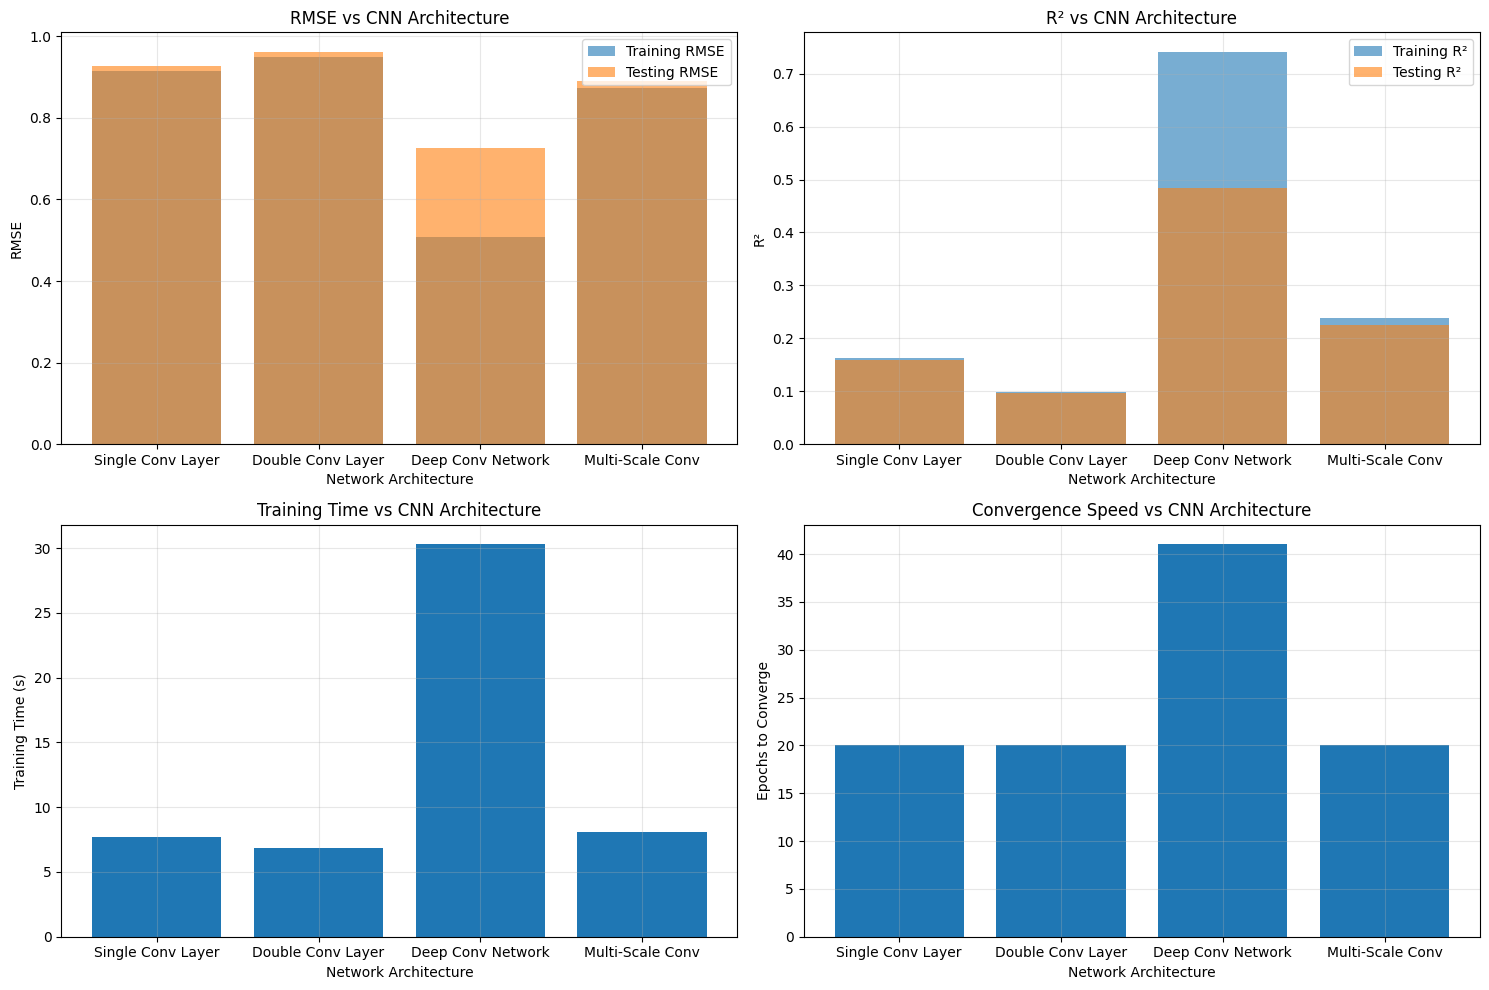


Performing kernel size and filter count analysis for V_16...
Best architecture: Deep Conv Network
Training with kernel_size=1, filters=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Training with kernel_size=1, filters=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Training with kernel_size=1, filters=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Training with kernel_size=1, filters=128...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Training with kernel_size=3, filters=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Training with kernel_size=3, filters=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Training with kernel_size=3, filters=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Training with kernel_size=3, filters=128...
25/25 ━━━━━━

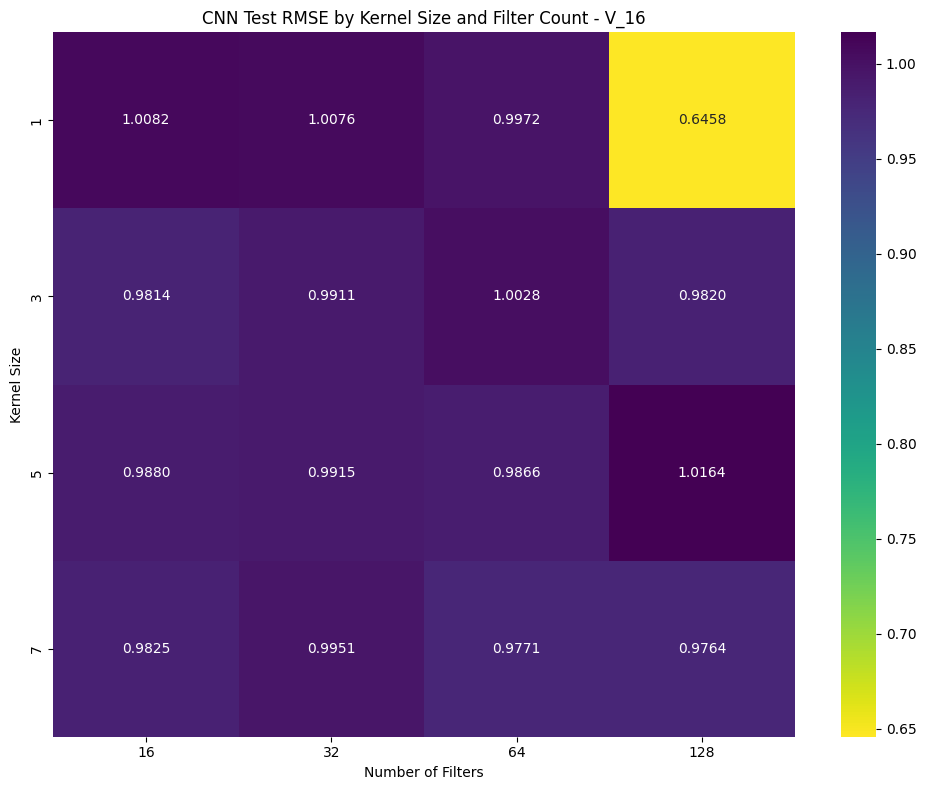


Training final CNN model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.6203 - mae: 0.6241 - val_loss: 1.1041 - val_mae: 0.8315
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.4274 - mae: 0.5303 - val_loss: 1.0927 - val_mae: 0.8349
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.4107 - mae: 0.5182 - val_loss: 1.1258 - val_mae: 0.8533
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.4054 - mae: 0.5149 - val_loss: 1.1644 - val_mae: 0.8714
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.4298 - mae: 0.5293 - val_loss: 1.2005 - val_mae: 0.8866
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3928 - mae: 0.5085 - val_loss: 1.1913 - val_mae: 0.8861
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4145 - mae: 0.5170 - val_loss: 1.0483 - val_mae: 0.8285
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.4369 - mae: 0.5341 - val_loss: 0.9579 - val_mae: 0.7894
Epoch 

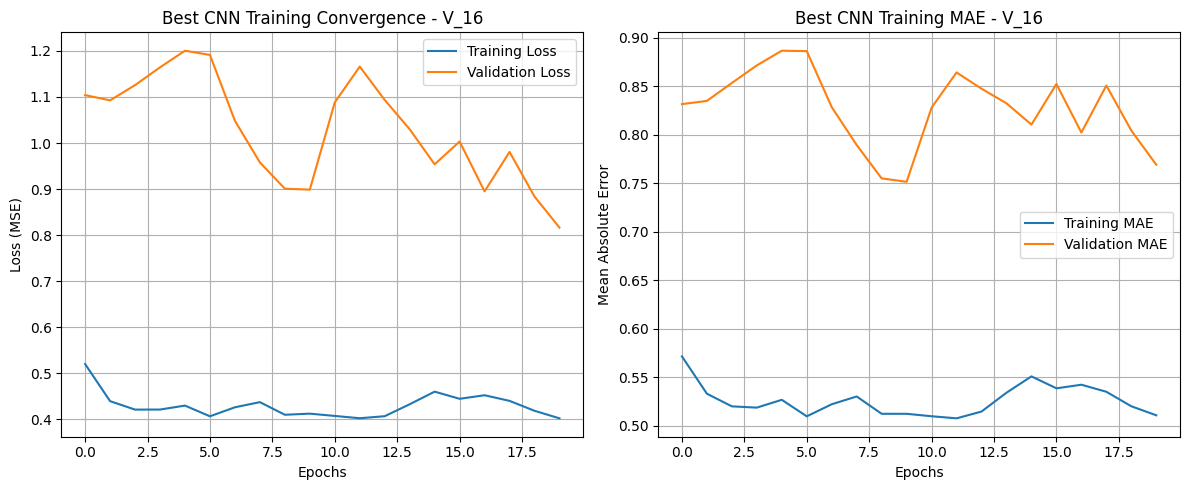

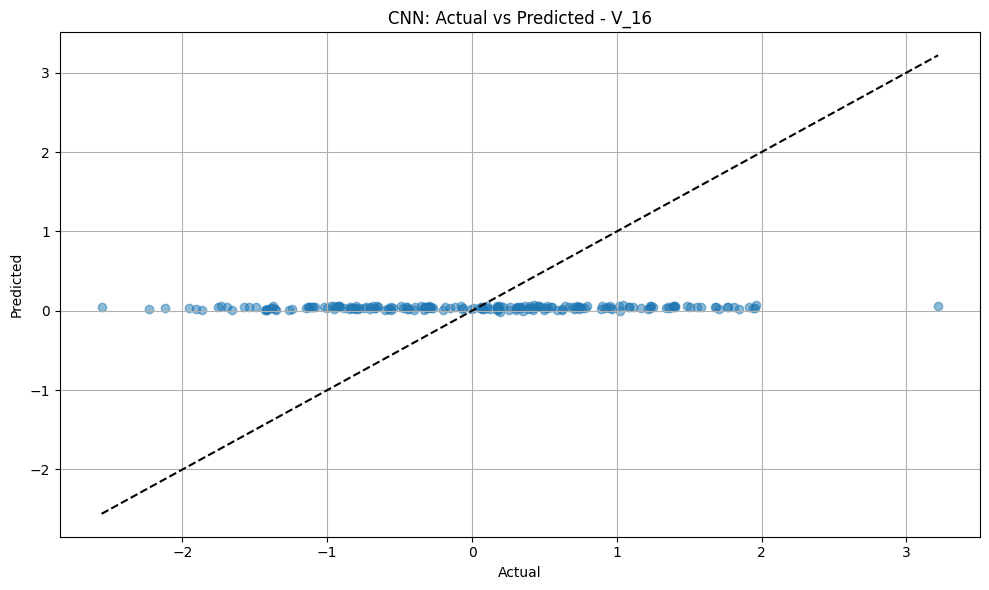

In [112]:
print("\n1. Training CNN for single voltage prediction (V_16)...")
cnn_v16_results = train_cnn_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


2. Training CNN for loss prediction...

Training base CNN model for loss...
Input shape: (800, 64, 1), Output shape: 1
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.6639 - mae: 0.6586 - val_loss: 0.8574 - val_mae: 0.7344
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4348 - mae: 0.5377 - val_loss: 0.8422 - val_mae: 0.7300
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4222 - mae: 0.5246 - val_loss: 0.7942 - val_mae: 0.7100
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4221 - mae: 0.5220 - val_loss: 0.7509 - val_mae: 0.6903
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3890 - mae: 0.5075 - val_loss: 0.7144 - val_mae: 0.6741
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3981 - mae: 0.5048 - val_loss: 0.6811 - val_mae: 0.6589
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3972 - mae: 0.5136 - val_loss: 0.6393 - val_mae: 0.6386
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

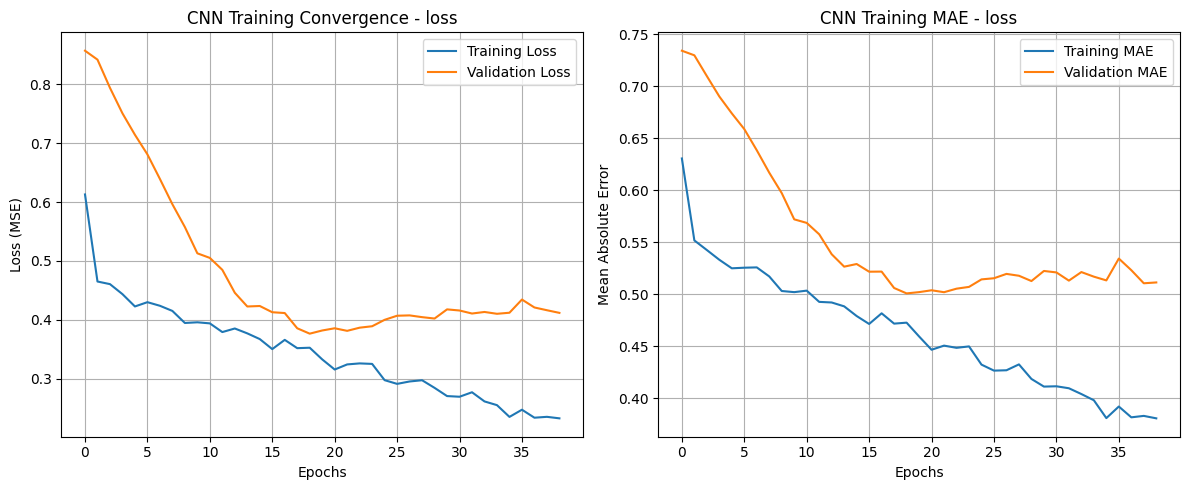


Performing architecture sensitivity analysis for CNN...
Training with Single Conv Layer architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training with Double Conv Layer architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Training with Deep Conv Network architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Training with Multi-Scale Conv architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


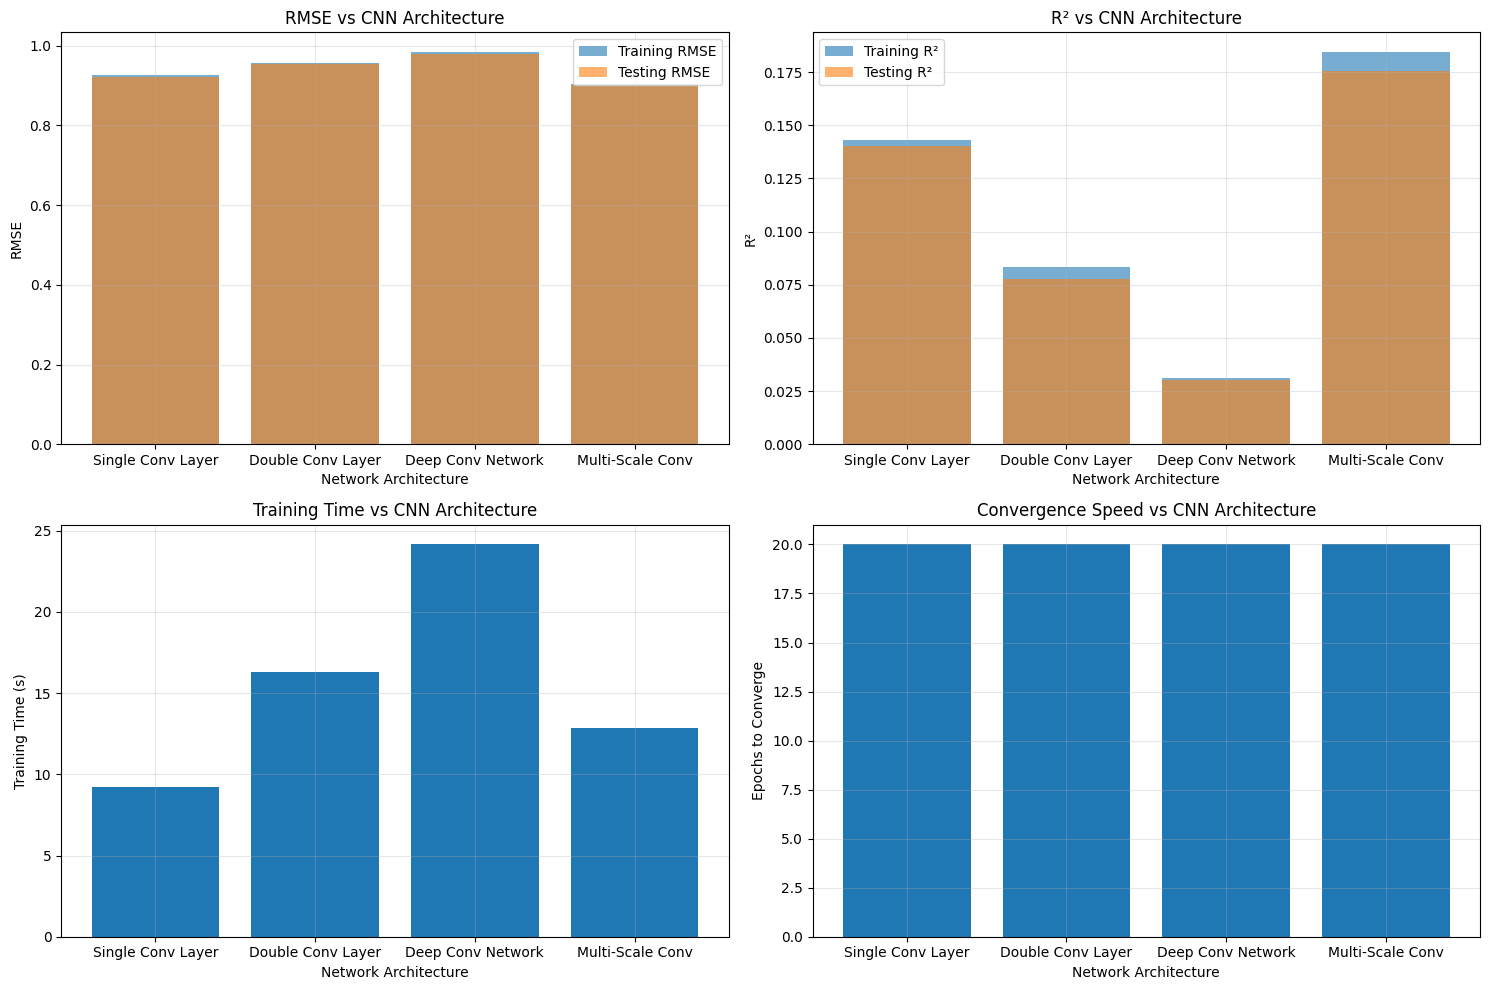


Performing kernel size and filter count analysis for loss...
Best architecture: Multi-Scale Conv
Training with kernel_size=1, filters=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Training with kernel_size=1, filters=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training with kernel_size=1, filters=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training with kernel_size=1, filters=128...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Training with kernel_size=3, filters=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Training with kernel_size=3, filters=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Training with kernel_size=3, filters=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Training with kernel_size=3, filters=128...
25/25 ━━━━━━━━━━━

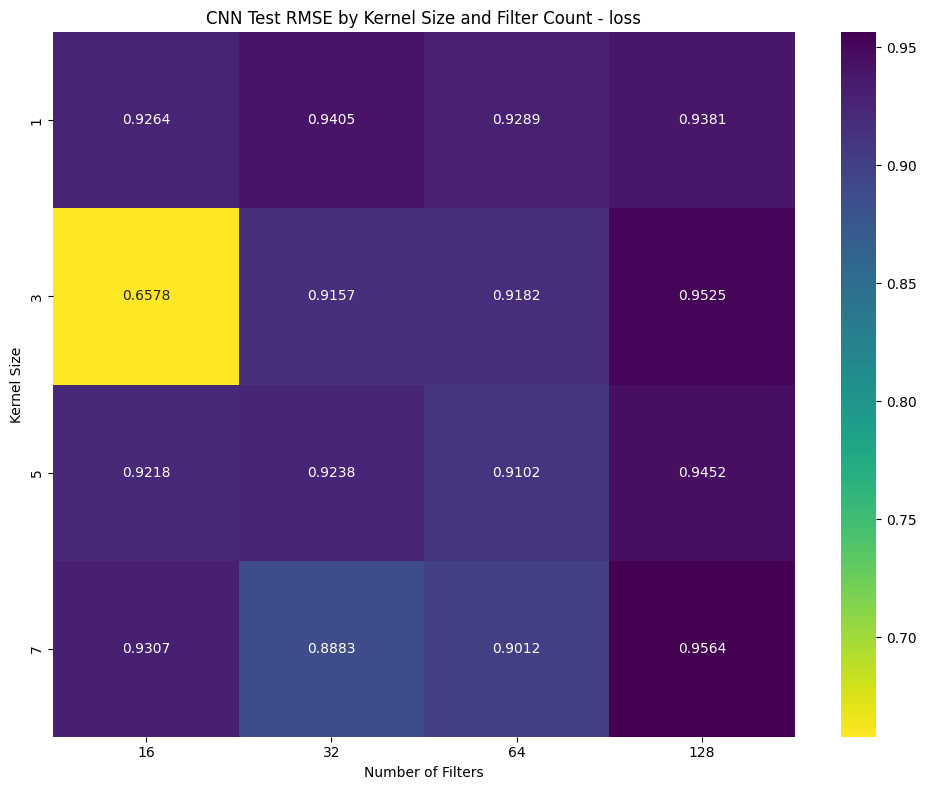


Training final CNN model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.8563 - mae: 0.7362 - val_loss: 0.8923 - val_mae: 0.7471
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4836 - mae: 0.5566 - val_loss: 0.7626 - val_mae: 0.6947
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4551 - mae: 0.5490 - val_loss: 0.7247 - val_mae: 0.6778
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4581 - mae: 0.5494 - val_loss: 0.7120 - val_mae: 0.6721
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4460 - mae: 0.5412 - val_loss: 0.6877 - val_mae: 0.6609
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4405 - mae: 0.5380 - val_loss: 0.6642 - val_mae: 0.6498
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4397 - mae: 0.5372 - val_loss: 0.6414 - val_mae: 0.6391
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4364 - mae: 0.5343 - val_loss: 0.6168 - val_mae: 0.6276
Epoch 

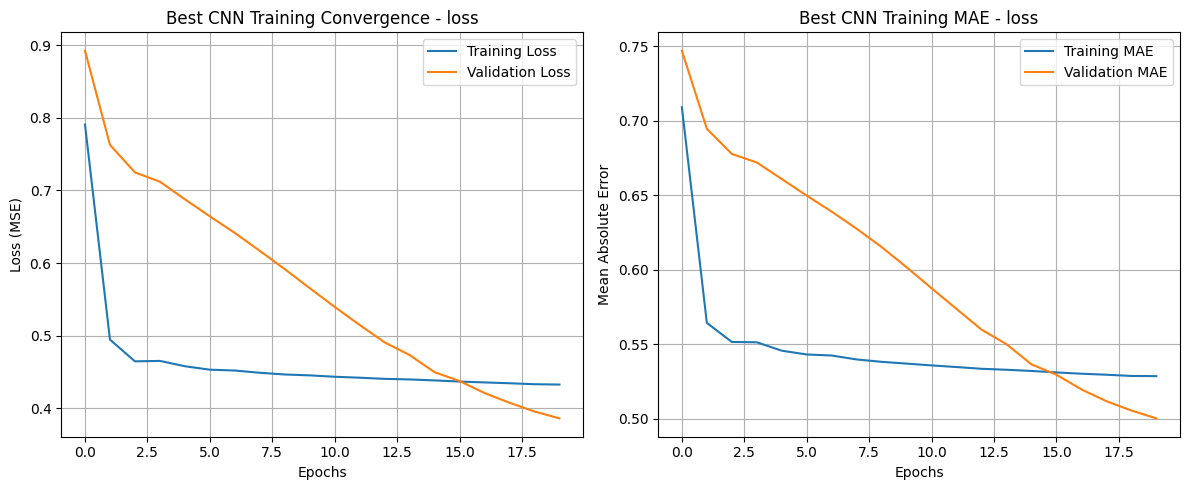


Generating feature importance visualization via activation maps...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


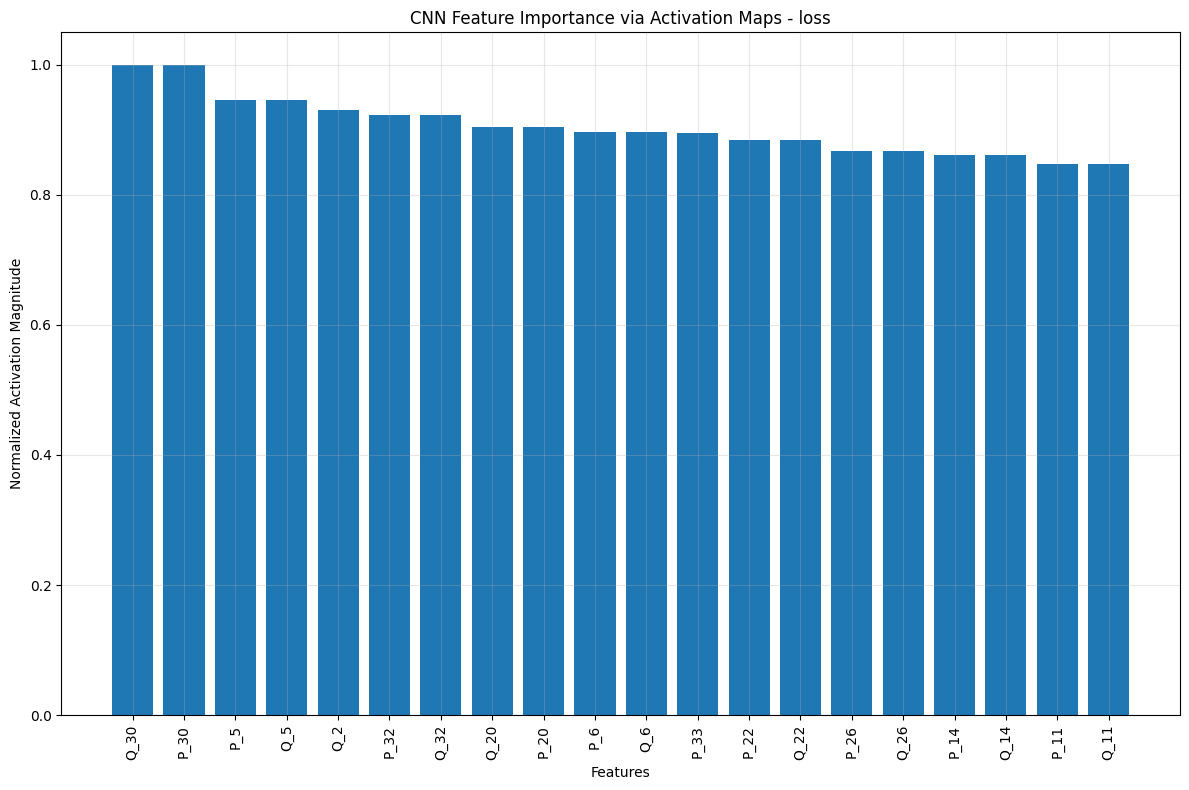

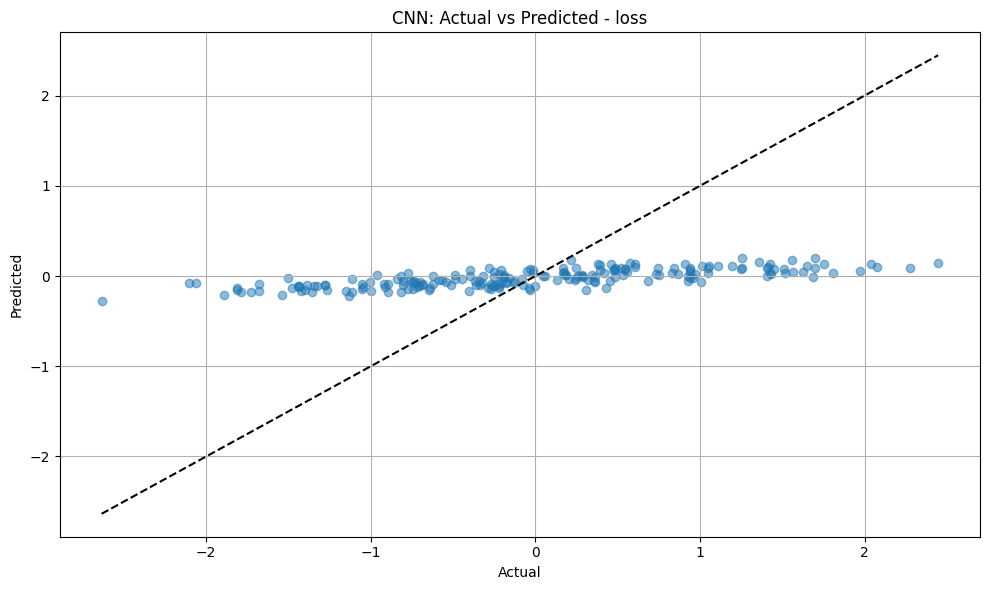

In [ ]:
print("\n2. Training CNN for loss prediction...")
cnn_loss_results = train_cnn_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


3. Training CNN for all voltages prediction...

Training base CNN model for all_voltages...
Input shape: (800, 64, 1), Output shape: 34
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.8922 - mae: 0.7509 - val_loss: 1.0387 - val_mae: 0.8065
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6796 - mae: 0.6479 - val_loss: 0.9423 - val_mae: 0.7688
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5365 - mae: 0.5794 - val_loss: 0.8819 - val_mae: 0.7444
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4733 - mae: 0.5480 - val_loss: 0.8357 - val_mae: 0.7260
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4470 - mae: 0.5324 - val_loss: 0.7949 - val_mae: 0.7088
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4116 - mae: 0.5126 - val_loss: 0.7509 - val_mae: 0.6899
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4272 - mae: 0.5248 - val_loss: 0.7058 - val_mae: 0.6695
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0

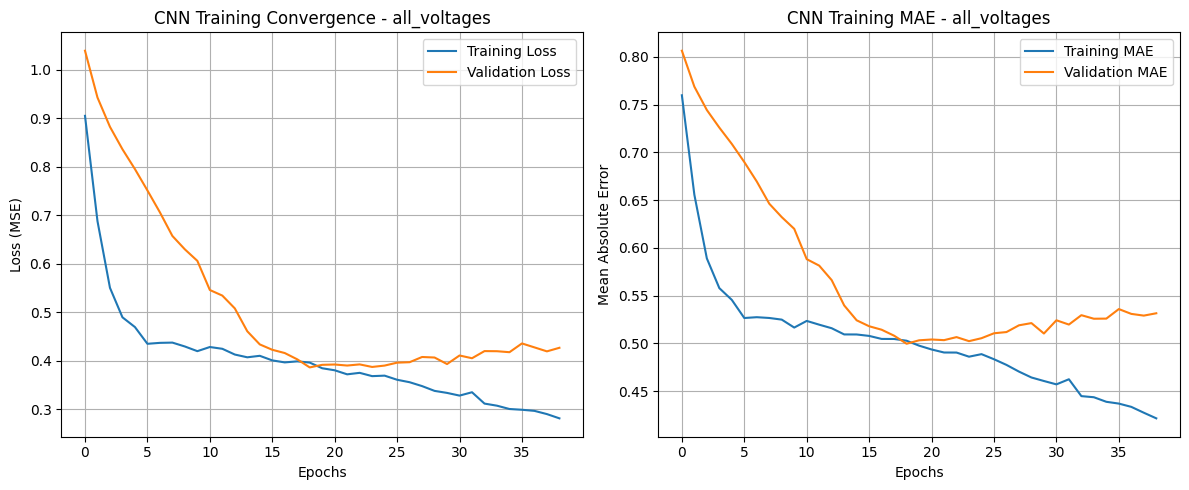


Performing architecture sensitivity analysis for CNN...
Training with Single Conv Layer architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training with Double Conv Layer architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Training with Deep Conv Network architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Training with Multi-Scale Conv architecture...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


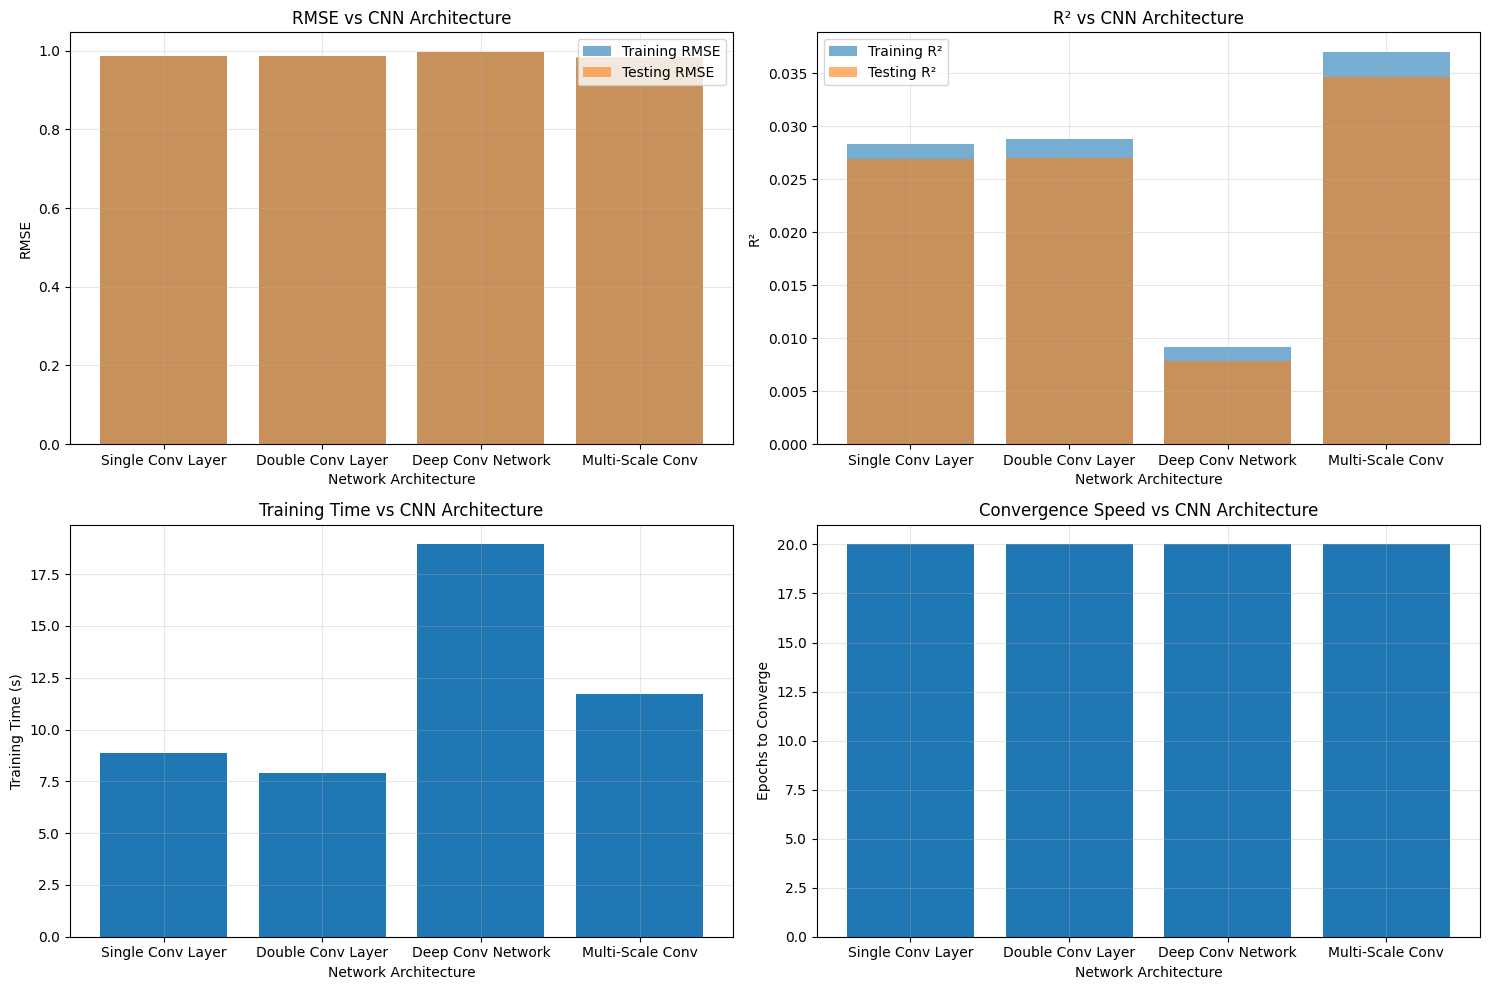


Performing kernel size and filter count analysis for all_voltages...
Best architecture: Multi-Scale Conv
Training with kernel_size=1, filters=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training with kernel_size=1, filters=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training with kernel_size=1, filters=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Training with kernel_size=1, filters=128...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training with kernel_size=3, filters=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Training with kernel_size=3, filters=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training with kernel_size=3, filters=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training with kernel_size=3, filters=128...
25/25 ━━━

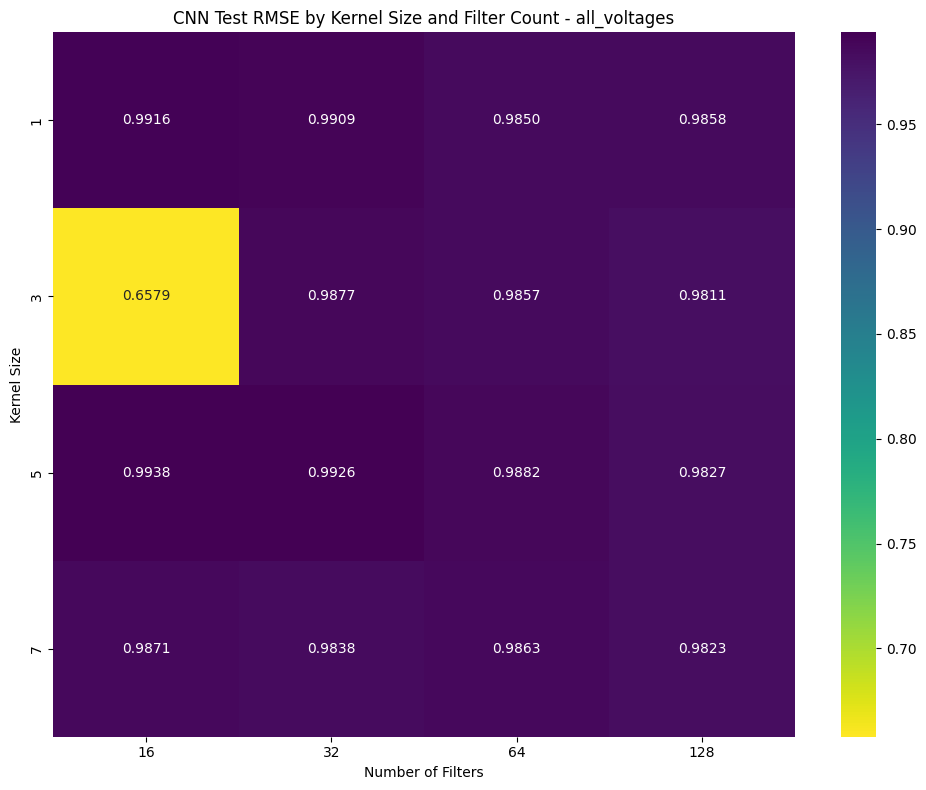


Training final CNN model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.9220 - mae: 0.7655 - val_loss: 1.0514 - val_mae: 0.8118
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8162 - mae: 0.7168 - val_loss: 0.9702 - val_mae: 0.7787
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6376 - mae: 0.6329 - val_loss: 0.8239 - val_mae: 0.7170
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5164 - mae: 0.5734 - val_loss: 0.7317 - val_mae: 0.6769
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4749 - mae: 0.5534 - val_loss: 0.6916 - val_mae: 0.6591
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4559 - mae: 0.5437 - val_loss: 0.6607 - val_mae: 0.6453
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4479 - mae: 0.5391 - val_loss: 0.6347 - val_mae: 0.6335
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4435 - mae: 0.5361 - val_loss: 0.6114 - val_mae: 0.6226
Epoch 

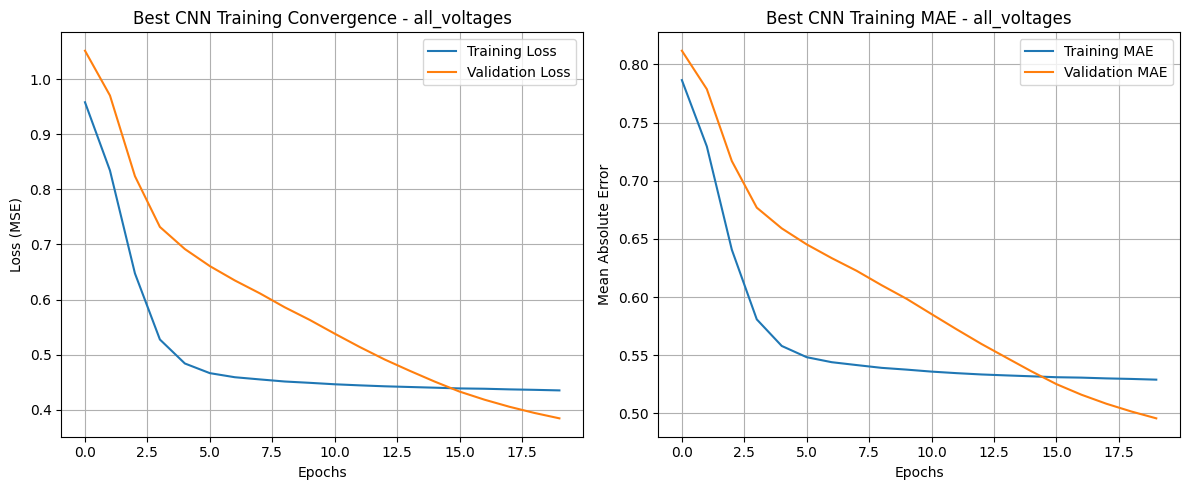


Generating feature importance visualization via activation maps...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


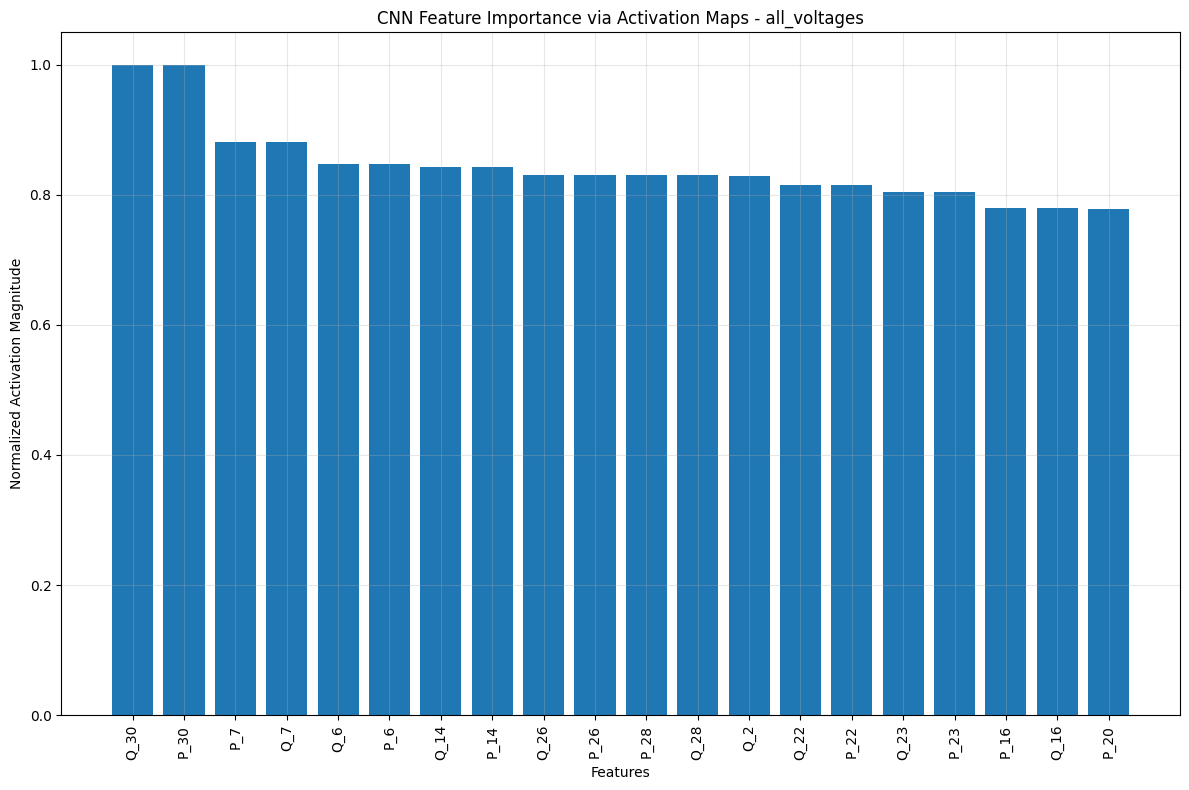

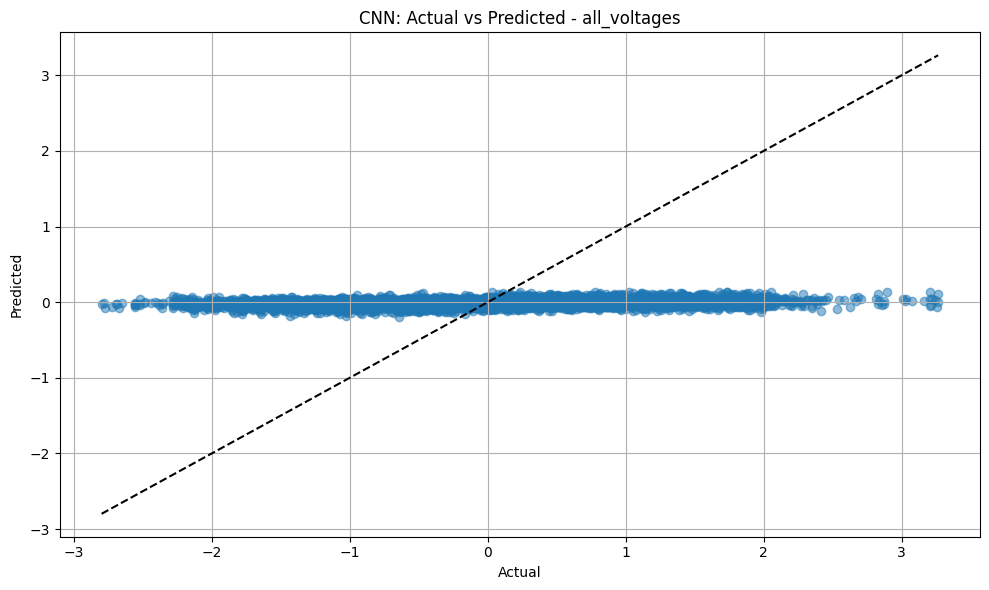

In [ ]:
print("\n3. Training CNN for all voltages prediction...")
cnn_all_v_results = train_cnn_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [ ]:
print("\nSaving trained CNN models...")

cnn_v16_results['best_model']['model'].save('models/cnn/cnn_v16_best_model.keras')
cnn_loss_results['best_model']['model'].save('models/cnn/cnn_loss_best_model.keras')
cnn_all_v_results['best_model']['model'].save('models/cnn/cnn_all_v_best_model.keras')

with open('models/cnn/cnn_v16_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': cnn_v16_results['best_model']['scaler'],
        'reshape_info': cnn_v16_results['best_model']['reshape_info'],
        'params': cnn_v16_results['best_model']['params']
    }, f)

with open('models/cnn/cnn_loss_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': cnn_loss_results['best_model']['scaler'],
        'reshape_info': cnn_loss_results['best_model']['reshape_info'],
        'params': cnn_loss_results['best_model']['params']
    }, f)

with open('models/cnn/cnn_all_v_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': cnn_all_v_results['best_model']['scaler'],
        'reshape_info': cnn_all_v_results['best_model']['reshape_info'],
        'params': cnn_all_v_results['best_model']['params']
    }, f)

print("CNN models saved successfully!")

In [ ]:
print("\n=== CNN Models Summary ===")
print(f"V_16 Prediction - Test R²: {cnn_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {cnn_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {cnn_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {cnn_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {cnn_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {cnn_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")